In [1]:
import pandas as pd
import numpy as np
import csv
import json
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import math
from matplotlib.animation import FuncAnimation
from lmfit import minimize, fit_report, Parameters
from aim2_population_model_spatial_aff_parallel import get_mod_spike
from model_constants import (MC_GROUPS, LifConstants)
from popul_model import pop_model
from aim2_population_model_spatial_aff_parallel import Afferent, SimulationConfig, Simulation

### Model Parameters

In [2]:
# lmpars_init_dict = {}
# lmpars = Parameters()
# lmpars.add('tau1', value=8, vary=False) #tauRI()
# lmpars.add('tau2', value=200, vary=False) #tauSI
# lmpars.add('tau3', value=1744.6, vary=False)#tau USI
# lmpars.add('tau4', value=np.inf, vary=False)
# lmpars.add('k1', value=.74, vary=False, min=0) #a constant
# lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
# lmpars.add('k3', value=.07, vary=False, min=0) #c constant
# lmpars.add('k4', value=.0312, vary=False, min=0)
# lmpars_init_dict['t3f12v3final'] = lmpars

# Global Variables
lmpars_init_dict = {}
lmpars = Parameters()
lmpars.add('tau1', value=8, vary=False) #tauRI(ms)
lmpars.add('tau2', value=200, vary=False) #tauSI(ms)
lmpars.add('tau3', value=1744.6, vary=False)#tauUSI(ms)
lmpars.add('tau4', value=np.inf, vary=False)
lmpars.add('k1', value=.74, vary=False, min=0) #a constant
lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
# lmpars.add('k2', value=.2088, vary=False, min=0) #b constant
# lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
lmpars.add('k3', value=.07, vary=False, min=0) #c constant
lmpars.add('k4', value=.0312, vary=False, min=0)
lmpars_init_dict['t3f12v3final'] = lmpars


#Setting global Font and fontsize to Arial, 20 respectively
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20

### Population Model Class with methods for Raidal & Spatial Model and Plotting funtino for radial

In [15]:
class VF_Population_Model:
    
    def __init__(self, vf_tip_size, aff_type, scaling_factor, density = None):
        self.sf = scaling_factor 
        self.vf_tip_size = vf_tip_size
        self.aff_type = aff_type
        self.results = None
        self.stress_data = None
        self.x_coords = None
        self.y_coords = None
        self.time_of_firing = None
        self.radial_stress_data = None
        self.radial_iff_data = None
        self.SA_radius = None
        self.g = None
        self.h = None
        self.density = density.lower().capitalize() if density else None

    """
        functino takes in a vf_tip_size (given that that there is data assicated with it) an
        afferent type, and runs the single unit model for all of those coordinates with the data

        firing time: takes either pike or a certain time, during thd ramp phase when the 
        
    """
    def spatial_stress_vf_model(self, time_of_firing = "peak", g=0.2, h= .5):
        self.time_of_firing = time_of_firing
        self.g = g
        self.h = h


        #in the case that a desnity is not specified
        coords = None
        stress_data = None
        if not self.density:
            coords = pd.read_csv(f"data/P3/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr.csv")
        #gettiong low/medium or high desnityh
        elif self.density == "Low" or self.density == "Med" or self.density == "High" or self.density == "Realistic":
            coords = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr_{self.density.lower()}.csv")
        else:
            logging.error(f"Density is not specified correctly Density Specified : {self.density}")
            return


        #assinging the instance variables for all the x coords and y coords of spatial points
        self.x_coords = [float(row[0]) for row in coords.iloc[0:].values]
        self.y_coords = [float(row[1]) for row in coords.iloc[0:].values]

        

        if not self.density:
            stress_data = pd.read_csv(f"data/P3/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr.csv")
        elif self.density == "Low" or self.density == "Med" or self.density == "High"or self.density == "Realistic":
            stress_data = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr_{self.density}.csv")
        else:
            logging.error(f"Density is not specified correctly Density Specified : {self.density}")
            
            return

        time = stress_data['Time (ms)'].to_numpy()

        afferent_type = []
        x_pos = []
        y_pos = []
        spikes = []
        mean_firing_frequency = []
        peak_firing_frequency = []
        first_spike_time = []
        last_spike_time = []
        stress_trace = []
        cumulative_mod_spike_times = []
        entire_iff = []
        #iterating through each of the coordinates
        for i, row in coords.iloc[0:].iterrows():
            i+=1 #incrementing so index starts from first index
            # print(f"index: {i}, row: {row}")
            #getting stress data

            
            if f"Coord {i} Stress (kPa)" in stress_data.columns:
                stress = stress_data[f"Coord {i} Stress (kPa)"] * self.sf

                #Debugging Statement
                # print(f"RECIEVING STRESS DATA AT COORD {i} at x:{row.iloc[0]}and y:{row.iloc[1]} MEAN STRESS IS {np.mean(stress)}")
            else:
                # logging.warning("STRESS VALUE COULD NOT BE INDEXED")
                pass

            lmpars = lmpars_init_dict['t3f12v3final']
            if self.aff_type == "RA":
                # lmpars['tau1'].value = 2.5
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0
            elif self.aff_type == "SA":
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1744.6
                lmpars['tau4'].value = np.inf
                lmpars['k1'].value = .74
                lmpars['k2'].value = 2.75
                lmpars['k3'].value = .07
                lmpars['k4'].value = .0312
                

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress, g=self.g,h =self.h )
            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                # logging.warning(f"SPIKES COULD NOT BE GENERATED FOR COORD {i} and X: {row.iloc[0]} and Y:{row.iloc[1]}, BECAUSE STRESS WAS TOO LOW")
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time,mod_fr_inst_interp)
    
            #appending stuff to lists
            afferent_type.append(self.aff_type)
            x_pos.append(row.iloc[0])
            y_pos.append(row.iloc[1])
            spikes.append(mod_spike_time)
            entire_iff.append(mod_fr_inst_interp)
            mean_firing_frequency.append(features["Average Firing Rate"])
            if time_of_firing == "peak":
                peak_firing_frequency.append(np.max(mod_fr_inst_interp))
            else:
                #firing frequency at a specific time , finds the closest iff value to the specified time 
                # Find the index of the mod_spike_time closest to time_of_firing
                # closest_spike_idx = np.argmin(np.abs(np.array(mod_spike_time) - time_of_firing))
                #////// Newcode
  
                # Compute the difference array
                difference_array = time_of_firing - np.array(mod_spike_time)

                # Find the indices where the spike times are less than the time of firing
                positive_indices = np.where(difference_array > 0)[0]

                # Check if there are valid indices
                if len(positive_indices) > 0:
                    # Get the index of the closest spike time (less than the time of firing)
                    closest_spike_idx = positive_indices[np.argmin(difference_array[positive_indices])]

                    # Use the closest index to append the value
                    temp_fr_inst_interp = mod_fr_inst_interp[closest_spike_idx]
                else:
                    # Handle the case where no spike times are less than the time of firing
                    temp_fr_inst_interp = 0  # or some default value, depending on your requirements






                # Debugging Statements
                print(f"MOD_SPIKE_TIME:{mod_spike_time}")
                print(f"TIME_OF_FIRING: {mod_fr_inst_interp}")
                print(f"MOD_SPIKE_TIME_SHAPE: {len(mod_spike_time)}")
                print(f"MOD_FR_INST_INTERP_SHAPE: {len(mod_fr_inst_interp)}")
                # print(f"Closest Spike Index: {closest_spike_idx}")
                print(f"IFF OF 1st FIRING: { mod_fr_inst_interp[0]}")
                if len(mod_spike_time) > 1:
                    print(f"IFF OF 2nd FIRING: {mod_fr_inst_interp[1]}")
                
                # Get the corresponding mod_fr_inst_interp value tied to this spike time
                # temp_fr_inst_interp = mod_fr_inst_interp[closest_spike_idx]
                # Append the instantaneous firing frequency at the closest spike time
                peak_firing_frequency.append(temp_fr_inst_interp)

            # print(f"mod_spike_time {mod_spike_time}")
        
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != None else None)
            last_spike_time.append(mod_spike_time[-1])
            stress_trace.append(stress)
            # logging.warning(f"MOD_FR_INST_INTERP_SHAPE: {mod_fr_inst_interp}")
            cumulative_mod_spike_times.append(mod_spike_time)
            
        model_results = {
            'afferent_type': self.aff_type,
            'x_position': x_pos,
            'y_position': y_pos,
            'spike_timings' : spikes,
            'mean_firing_frequency' : mean_firing_frequency,
            'peak_firing_frequency' : peak_firing_frequency, 
            'first_spike_time': first_spike_time,
            'last_spike_time' : last_spike_time,
            'each_coord_stress': stress_trace, 
            'entire_iff' : entire_iff,
            'cumulative_mod_spike_times': cumulative_mod_spike_times
        }

        self.results = model_results
        return model_results

    def radial_stress_vf_model(self,g= 0.2, h= .5):

        """ Read in the Radial which has sample stress traces for every 2mm from a center point
        to calculate firing"""
        if self.aff_type == "SA":
            self.g = 0.2
            self.h = 0.5
        elif self.aff_type == "RA":
            self.g = 0.4
            self.h = 1.0

        #regex pattern for exstracting the distance from the middle point
        distance_regex = r'\d\.\d{2}'

        radial_stress = None
        if not self.density:
            radial_stress = pd.read_csv(f"data/P3/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr.csv")
        elif self.density == "Low" or self.density == "Med" or self.density == "High" or self.density == "Realistic":
            print(f"Reading in data for {self.density} density")
            radial_stress = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr_{self.density.lower()}.csv")
        else:
            logging.error(f"Density is not specified correctly Density Specified : {self.density}")
            return
        radial_time = radial_stress['Time (ms)'].to_numpy()
        
        stress_data = {}
        iff_data = {}
        not_generated_radii = []

        # logging.warning(f"LENGTH OF radial_stress.columns: {len(radial_stress.columns)}")
        # Inner loop to iterate through radial distances
        for col in radial_stress.columns[1:]:

            
            LifConstants.set_resolution(1)
            matches = re.findall(distance_regex, col)
            if matches:
                distance_from_center = float(matches[0])
            else:
                logging.error(f"NO MATCHES FOUND FOR {col}")
                continue #skipts the current column and proceeds to the next

            # Initialize lists for each coordinate-distance pair
            afferent_type = []
            spikes = []
            mean_firing_frequency = []
            peak_firing_frequency = []
            first_spike_time = []
            last_spike_time = []

            # if radial_spatial_flag:
            #     radial_stress_vals = radial_stress[col]
            #     radial_stress_max = np.max(radial_stress_vals)
            #     distance_scaling_factor = spatial_stress_max / radial_stress_max
            #     radial_spatial_flag = False
            
            #where the scaling happens
            scaled_stress = radial_stress[col] *  self.sf

            stress_data[distance_from_center] = {
                "Time": radial_time,
                distance_from_center: scaled_stress.to_numpy()
            }

            lmpars = lmpars_init_dict['t3f12v3final']

            if afferent_type == "RA":
                # lmpars['tau1'].value = 2.5
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0
            elif afferent_type == "SA":
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1744.6
                lmpars['tau4'].value = np.inf
                lmpars['k1'].value = .74
                lmpars['k2'].value = 2.75
                # lmpars['k2'].value = .2088  
                lmpars['k3'].value = .07
                lmpars['k4'].value = .0312
                        

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, stress_data[distance_from_center]["Time"], stress_data[distance_from_center][distance_from_center],g=self.g, h = self.h)

            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                # logging.warning(f"SPIKES COULD NOT BE GENERATED FOR {self.vf_tip_size}")
                not_generated_radii.append(distance_from_center)
                iff_data[distance_from_center] = None
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, radial_time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time, mod_fr_inst_interp)

            # Append single values to the lists
            afferent_type.append(afferent_type)
            spikes.append(len(mod_spike_time) if len(mod_spike_time) != 0 else None)
            mean_firing_frequency.append(features["Average Firing Rate"])
            peak_firing_frequency.append(np.max(mod_fr_inst_interp))
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != 0 else None)
            last_spike_time.append(mod_spike_time[-1])

            # Store each coordinate-distance dictionary within iff_data
            iff_data[distance_from_center] = {
                'Time' :  stress_data[distance_from_center]["Time"].tolist(),
                'stress_data' :  stress_data[distance_from_center][distance_from_center].tolist(),
                'afferent_type': afferent_type,
                'num_of_spikes': spikes[0],
                'mean_firing_frequency': mean_firing_frequency[0],
                'peak_firing_frequency': peak_firing_frequency[0],
                'first_spike_time': first_spike_time[0],
                'last_spike_time': last_spike_time[0],
                'mod_spike_time': mod_spike_time.tolist(),
                'entire_iff ' : mod_fr_inst_interp.tolist()
            }
        self.radial_stress_data = stress_data
        self.radial_iff_data = iff_data

    def plot_spatial_coords(self, label = True):
        """
        Plots the iffs on a grid for the original n points, the magniude of the peak firing
        frequency directly affects the size of the circle plotted, and the opacity
        """
        #colors for differnet afferents
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))

        # Plot the stimulus locations as circles
        x_positions = self.results.get("x_position")
        y_positions = self.results.get("y_position")
        mean_iffs = self.results.get("mean_firing_frequency")
        peak_iffs = self.results.get("peak_firing_frequency")
        spike_timings = self.results.get("spike_timings")
        entire_iff = self.results.get("entire_iff")

        # print(f"peak_iffs len {len(peak_iffs)}")
        # for x,y, peak in zip(x_positions, y_positions, peak_iffs):
        #     print(f"x: {x} y: {y} peak_iff: {peak* 1e3}")
            
    
        x_positions = [float(value) for value in x_positions]
        y_positions = [float(value) for value in y_positions]
        #scaling peak_iffs so it looks better when plotting

        # for time, iff, peak_iff in zip(spike_timings, entire_iff, peak_iffs):
        #     print(f"Time: {time} IFF: {iff}, PEAK: {peak_iff}")
            
        alphas = [float(value) / max(peak_iffs) if value != 0 else 0 for value in peak_iffs]    
  
        #Scatter plot
        # Plot the stimulus locations as circles
        for x_pos, y_pos, radius, alpha in zip(x_positions, y_positions, peak_iffs, alphas):
            print(f"plotting {x_pos} {y_pos} {radius} {alpha}")
            plt.gca().add_patch(
                patches.Circle((x_pos, y_pos), radius*2, edgecolor='black', facecolor = colors.get(self.aff_type) , linewidth=1, alpha = 0.5)
            )
        
        #calculating the Stimulus Point
        idx_of_max_iff = mean_iffs.index(np.max(mean_iffs))
        x_stim = x_positions[idx_of_max_iff]
        y_stim = y_positions[idx_of_max_iff]

        #plotting the circle where the center is the point of max stimulus
        # plt.gca().add_patch(
        #     patches.Circle((x_stim,y_stim),self.SA_Radius, edgecolor='black', facecolor='none', linewidth=1) 
        # )

        if label == True:
            plt.xlabel('Length (mm)')
            plt.ylabel('Width (mm)')
            plt.title(f"{self.density if self.density else ''} {self.vf_tip_size} VF {self.aff_type} firing at {self.time_of_firing} ms Stress Distribution")
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.xlim(0, 15)  # Expands the X-axis slightly to capture all activity
        plt.ylim(0,15)   # Ensures all Y-axis activity is visible
        # plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
        # plt.ylim(min(y_positions) - 1, max(y_positions) + 1)

        # plt.savefig(f"vf_graphs/aggregated_results_on_grid/{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")
        # plt.savefig(f"vf_graphs/spatial_plots/{self.density if self.density else ''}{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")
        plt.show()


    '''
    In order to run this instace method, the following  three methods must have been already run 
        vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
        vf_model.radial_stress_vf_model(.2,.5)
        vf_model.run_single_unit_model_combined_graph()

    '''
    @staticmethod
    def cumulative_afferent_over_time(afferent_type, plot_cumulative=True, vf_tip_sizes=[3.61,4.08, 4.17,4.31, 4.56], colors = ['#0072B2', '#E69F00', '#009E73', '#F0E442', '#CC79A7'], density=None):
        labels = [f"Tip Size {size}" for size in vf_tip_sizes]

        # Create a single figure
        plt.figure(figsize=(10, 6))
        vf_cumulative_data = {}
        for vf_tip, color, label in zip(vf_tip_sizes, colors, labels):
            print(f"VF_TIP: {vf_tip}")
            # Initialize the VF model for each tip size
            vf_model = VF_Population_Model(vf_tip, afferent_type, scaling_factor=1.0, density=density)
            vf_model.radial_stress_vf_model(g =.2 if afferent_type =="SA" else .4 , h =.5 if afferent_type =="SA" else .1)
            vf_model.run_single_unit_model_combined_graph(plot=False)

            # Get model results
            model_results = vf_model.spatial_stress_vf_model()
            if not model_results:
                logging.error(f"No results for VF tip size {vf_tip}")
                continue
            first_spike_times = model_results["first_spike_time"]
            if not first_spike_times:
                logging.warning(f"No spike times for {vf_tip}")
                continue
            spike_timings = model_results["spike_timings"]
            # print(f"Spike_timings: {spike_timings}")
            first_spike_times = []


            spike_timings = model_results["spike_timings"]
            for st in spike_timings:
                if len(st)>1:
                    # print(st[1])
                    first_spike_times.append(st[1])
                    # print(f"Spike Timings length: {len(st[1:])}")
            


            #soring based on zipped 
            zipped = list(zip(first_spike_times, model_results["x_position"], model_results["y_position"]))
            sorted_zipped = sorted(zipped, key = lambda x: x[0])
            sorted_spike_times, sorted_x_positions, sorted_y_positions = zip(*sorted_zipped)
            
            # print (f"first_spike_times: {sorted_spike_times}")
            # print(f"x_positions: {sorted_x_positions}")
            # print(f"y_positions: {sorted_y_positions}")
            # entire_iff = model_results["entire_iff"]
            # for iff in entire_iff:
            #     if len(iff) > 1:
            #         print(f"IFF: {iff[1]}")
            #         print(f"IFF: {iff[1]}")
            # print(f"All Spikes: {model_results["cumulative_mod_spike_times"]}")
            

            # Dictionary to store the count of afferents recruited over time
            time_and_afferents_triggered = {}

            # Count the number of afferents recruited at each spike time
            for spike_time in first_spike_times:
                if spike_time in time_and_afferents_triggered.keys():
                    time_and_afferents_triggered[spike_time] += 1
                else:
                    time_and_afferents_triggered[spike_time] = 1

            # Sort the dictionary by spike times
            spike_times_sorted = sorted(time_and_afferents_triggered.keys())
            time_and_afferent_keys_sorted = {time_stamp: time_and_afferents_triggered[time_stamp] for time_stamp in spike_times_sorted}

            # Logic for cumulative summation of afferents over time
            cumulative_afferents = {}
            cumulative_counter = 0
            for time in time_and_afferent_keys_sorted.keys():
                cumulative_counter += time_and_afferents_triggered[time]
                cumulative_afferents[time] = cumulative_counter

            # Plot cumulative or instantaneous data
            if plot_cumulative:

                plt.plot(cumulative_afferents.keys(), cumulative_afferents.values(), marker='o', color=color, label=label)
            else:
                plt.scatter(time_and_afferents_triggered.keys(), time_and_afferents_triggered.values(), marker='o', color=color, label=label)

            vf_cumulative_data[vf_tip] = cumulative_afferents
        # Add labels, legend, and grid
        if not density:
            plt.title(f"{density if density else ''} DensityCumulative Afferents Over Time" if plot_cumulative else "Instantaneous Afferents Over Time", fontsize=14, fontweight="bold")

        plt.xlim(0,800)
        plt.xlabel("Time (ms)", fontsize=12)
        plt.ylabel("Number of Afferents Recruited", fontsize=12)
        plt.grid(alpha=0.5)
        plt.legend(title="VF Tip Sizes", fontsize=16, markerscale=0.8, loc='best')
        plt.tight_layout()
        plt.title(f"Cumulation of {afferent_type} Afferents")
        plt.savefig(f"vf_graphs/furthest_difference_before_firing/cumu_afferents_time/{density if density else ''}_{afferent_type}_cumulative_afferents.png", bbox_inches='tight')
        # plt.show()
        return vf_cumulative_data

    '''
    In order to run this instace method, the following  three methods must have been already run 
        vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
        vf_model.radial_stress_vf_model(.2,.5)
        vf_model.run_single_unit_model_combined_graph()

    '''
    @staticmethod
    def cumulative_firing_over_time(afferent_type = None, cumulative=True, vf_tip_sizes=[3.61, 4.17, 4.56], colors=['red', 'blue', 'green'], density = None):
        labels = [f"Tip Size {size}" for size in vf_tip_sizes]
        
        plt.figure(figsize=(10, 6))
        
        for vf_tip, color, label in zip(vf_tip_sizes, colors, labels):
            print(f"VF_TIP: {vf_tip}")
            vf_model = VF_Population_Model(vf_tip, afferent_type, scaling_factor=1.0, density=density.lower().capitalize())
            vf_model.radial_stress_vf_model(0.2, 0.5)
            vf_model.run_single_unit_model_combined_graph(plot = False)

            # Get model results
            model_results = vf_model.spatial_stress_vf_model()
            mod_spikes = model_results["spike_timings"]
            entire_iff = model_results["entire_iff"]

            # Creating a dict of {spike_times: firing at that time}
            spike_times_and_iffs = {}
            for spike_time_at_point, iff_at_point in zip(mod_spikes, entire_iff):
                for spike_time, iff in zip(spike_time_at_point, iff_at_point):
                    if spike_time in spike_times_and_iffs.keys():
                        spike_times_and_iffs[spike_time] += (iff * 1e3)
                    else:
                        spike_times_and_iffs[spike_time] = (iff * 1e3)


            # Sorting the dictionary by spike_times
            spike_times_sorted = sorted(spike_times_and_iffs.keys())
            spike_times_and_iffs = {time_stamp: spike_times_and_iffs[time_stamp] for time_stamp in spike_times_sorted}

            # Logic for calculating cumulative firing
            cumulative_iffs = {}
            cumulative_counter = 0
            for time in spike_times_and_iffs.keys():
                cumulative_counter += spike_times_and_iffs[time]
                cumulative_iffs[time] = cumulative_counter

            # Plotting cumulative or instantaneous firing
            if cumulative:
                plt.scatter(cumulative_iffs.keys(), cumulative_iffs.values(), marker='o', color=color, label=label)
            else:
                plt.scatter(spike_times_and_iffs.keys(), spike_times_and_iffs.values(), marker='o', color=color, label=label)

        # Add labels, legend, and grid
        plt.title(f"{density if density else ''} Density Cumulative IFFs Over Time" if cumulative else "Instantaneous IFFs Over Time", fontsize=14, fontweight="bold")
        plt.xlabel("Time (ms)", fontsize=12)
        plt.ylabel("Total Firing Frequency", fontsize=12)
        plt.grid(alpha=0.5)
        plt.legend(title="VF Tip Sizes")
        plt.tight_layout()
        plt.show()


    def run_single_unit_model_combined_graph(self, stress_threshold = 0, plot = True):
        
        #variable for The radius for SA, setting it to a really large variable
        SA_radius = 0
        if plot:
            fig, axes = plt.subplots(5, 5, figsize=(20, 20))
            fig.subplots_adjust(hspace=0.5, wspace=0.4)
            axes = axes.flatten()

        # finding comon limits
        common_x_min = 0
        common_x_max = max(data['Time'][-1] for data in self.radial_stress_data.values())
        common_stress_max =0 
        xommon_iff_max = 0 

        legend = False
        # Iterate through each entry in the stress_data dictionary and each subplot
        for idx, (distance, data) in enumerate(self.radial_stress_data.items()):
            if idx >= 25:  # Only plot up to 25 entries for the 5x5 grid
                break
            
            time = data['Time']  # Extract the time array
            stress_values =  data[distance]  


            lmpars = lmpars_init_dict['t3f12v3final']
            LifConstants.set_resolution(1)
            if self.aff_type == "RA":
                # lmpars['tau1'].value = 2.5  #this is the original value
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0
            elif self.aff_type == "SA":
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1744.6
                lmpars['tau4'].value = np.inf
                lmpars['k1'].value = .74
                lmpars['k2'].value = 2.75
                lmpars['k3'].value = .07
                lmpars['k4'].value = .0312

            groups = MC_GROUPS

            ####added streses threshold logic 
            if np.max(stress_values) < stress_threshold:
                # Zero out the stress trace
                stress_values = np.zeros_like(stress_values)    



            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values,g= self.g,h= self.h )


            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                # logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
                
                continue
            #updating the size rf of the stimlus 
            if distance > SA_radius:
                    SA_radius = distance
            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst
            

            #logic for getting the iff values at at around 2 seconds
            # if distance == 0.0:
            #     for spike_time,iff in zip(mod_spike_time, mod_fr_inst_interp):
            #         if spike_time >= 1750 and spike_time <= 2250:
            #             print(f"Time (ms): {spike_time} Stress (kPa):{stress_values[int(spike_time)]} IFF (hz): {iff*1e3}")

            #addding the logic for the limits of stress and iff
            if not legend:
                common_stress_max = np.max(stress_values)+50
                common_iff_max = np.max(mod_fr_inst_interp*1e3)+50
            
            if plot:
                ax = axes[idx]
                ax2 = ax.twinx()  # Create twin axis on the right

                # Plot IFF (Hz) on the left y-axis
                ax.plot(mod_spike_time, mod_fr_inst_interp * 1e3, label="IFF (Hz)", 
                        marker='o', linestyle='none', color='blue')
                # ax.set_ylabel('Firing Rate (Hz)', color='blue')
                ax.tick_params(axis='y', labelcolor='blue')
                if self.vf_tip_size == 3.61:
                    ax.set_ylim(0, 525)
                elif self.vf_tip_size == 4.17:
                    ax.set_ylim(0, 525)
                elif self.vf_tip_size == 4.31:
                    ax.set_ylim(0, 525)
                elif self.vf_tip_size == 4.56:
                    ax.set_ylim(0, 525)

                # Plot Stress (kPa) on the right y-axis
                ax2.plot(time, stress_values, label="Stress (kPa)", color='red')
                # ax2.set_ylabel('Stress (kPa)', color='red')
                ax2.tick_params(axis='y', labelcolor='red')
                if self.vf_tip_size == 3.61:
                    ax2.set_ylim(0, 140)
                elif self.vf_tip_size == 4.17:
                    ax2.set_ylim(0, 300)
                elif self.vf_tip_size == 4.31:
                    ax2.set_ylim(0, 350)
                elif self.vf_tip_size == 4.56:
                    ax2.set_ylim(0, 400)


                # Title and X-axis
                ax.set_title(f'Distance {distance:.2f} mm')
                ax.set_xlabel('Time (ms)')
                ax.set_xlim(common_x_min, common_x_max)
                if not legend:
                    axes[idx].legend()
                    ax.set_ylabel('Firing Rate (Hz)', color='blue')
                    ax2.set_ylabel('Stress (kPa)', color='red')
                    legend= True

        if plot:
            # Hide any unused subplots
            for ax in axes[len(self.radial_stress_data):]:
                ax.axis('off')

            lmpars = lmpars_init_dict['t3f12v3final']
            tau1 = lmpars["tau1"]
            k1 = lmpars["k1"] #a value
            k2 = lmpars["k2"] #b value
            k3 = lmpars["k3"] #c value
            k4 = lmpars["k4"] #idk what this parameters is
            
            plt.suptitle(
                f"Radial graph for Density {self.density} vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
                
            )
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} g:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
            
        self.SA_Radius = SA_radius
    

    def sensitivity_analysis(self, parameter_of_variation,  stress_threshold = 0):
        #potential values
        #resetting parameters from previous sensitivty analysis if altered
        lmpars = lmpars_init_dict['t3f12v3final']
        lmpars["tau1"].value = 8
        lmpars["tau2"].value = 200
        lmpars["tau3"].value = 1744.6
        lmpars["tau4"].value = np.inf
        lmpars["k1"].value = .74
        lmpars["k2"].value = 2.75
        lmpars["k3"].value = .07
        lmpars["k4"].value = .0312

        sensitivity_values = []
        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            sensitivity_values = [1,2.5,8,30]
        elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
            sensitivity_values = [1,50,100,200, 250]
        elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
            sensitivity_values = [1,2,30,100]
        elif parameter_of_variation == "k1" or parameter_of_variation == "a":
            sensitivity_values = [10,20,30,40]
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            sensitivity_values = [2,4,8,16]
        elif parameter_of_variation == "g":
            sensitivity_values = [0.5, 0.75, 1.0, 1.25]
        elif parameter_of_variation == "h":
            sensitivity_values = [0, 0.25, 0.50, 0.75, 1.0]


        #variable for The radius for SA, setting it to a really large variable
        SA_radius = 0
        fig, axes = plt.subplots(5, 5, figsize=(20, 20))
        fig.subplots_adjust(hspace=0.5, wspace=0.4)
        axes = axes.flatten()

        colors = plt.cm.viridis(np.linspace(0,1,len(sensitivity_values)))

        # finding comon limits
        common_x_min = 0
        common_x_max = max(data['Time'][-1] for data in self.radial_stress_data.values())
        common_stress_max =0 
        xommon_iff_max = 0 

        legend = False
        # Iterate through each entry in the stress_data dictionary and each subplot


            #loop for all the square/ radii away from the stimuli   
        for idx, (distance, data) in enumerate(self.radial_stress_data.items()):
            if idx >= 25:  # Only plot up to 25 entries for the 5x5 grid
                break
            
            ax = axes[idx]
            ax2 = ax.twinx()  # Create twin axis on the right
            time = data['Time']  # Extract the time array
            stress_values = data[distance]  # Apply scaling factor

            for sv,color in zip(sensitivity_values,colors):
                # stress_values =  data[distance]  
                lmpars = lmpars_init_dict['t3f12v3final']
                LifConstants.set_resolution(1)
                if self.aff_type == "RA":
                    lmpars['tau1'].value = 2.5
                    lmpars['tau2'].value = 200
                    lmpars['tau3'].value = 1
                    lmpars['k1'].value = 35
                    lmpars['k2'].value = 0
                    lmpars['k3'].value = 0.0
                    lmpars['k4'].value = 0

                # Update the parameter value
                if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
                    lmpars["tau1"].value = sv
                elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
                    lmpars["tau2"].value = sv
                elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
                    lmpars["tau3"].value = sv
                elif parameter_of_variation == "k2" or parameter_of_variation == "b":
                    lmpars["k2"].value = sv
                elif parameter_of_variation == "k1" or parameter_of_variation == "a":
                    lmpars["k1"].value = sv
                elif parameter_of_variation == "g":
                    self.g = sv
                elif parameter_of_variation == "h":
                    self.h = sv
                


                groups = MC_GROUPS

                ####added streses threshold logic 
                if np.max(stress_values) < stress_threshold:
                    # Zero out the stress trace
                    stress_values = np.zeros_like(stress_values)    

                ####
                mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values,g= self.g,h= self.h )


                if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                    # logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
                    
                    continue
                #updating the size rf of the stimlus 
                if distance > SA_radius:
                        SA_radius = distance
                if len(mod_spike_time) != len(mod_fr_inst):
                    if len(mod_fr_inst) > 1:
                        mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                    else:
                        mod_fr_inst_interp = np.zeros_like(mod_spike_time)
                else:
                    mod_fr_inst_interp = mod_fr_inst

                #addding the logic for the limits of stress and iff
                if not legend:
                    common_stress_max = np.max(stress_values)+50
                    common_iff_max = np.max(mod_fr_inst_interp*1e3)+50


                # Plot IFF (Hz) on the left y-axis
                ax.plot(mod_spike_time, mod_fr_inst_interp * 1e3, label= sv,
                        linestyle='solid', color=color)
                # ax.set_ylabel('Firing Rate (Hz)', color='blue')
            ax.tick_params(axis='y', labelcolor='blue')
            if self.vf_tip_size == 3.61:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.17:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.31:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.56:
                ax.set_ylim(0, 525)

            # Plot Stress (kPa) on the right y-axis
            ax2.plot(time, stress_values, label="Stress (kPa)", color='red')
            # ax2.set_ylabel('Stress (kPa)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            if self.vf_tip_size == 3.61:
                ax2.set_ylim(0, 140)
            elif self.vf_tip_size == 4.17:
                ax2.set_ylim(0, 300)
            elif self.vf_tip_size == 4.31:
                ax2.set_ylim(0, 350)
            elif self.vf_tip_size == 4.56:
                ax2.set_ylim(0, 400)


            # Title and X-axis
            ax.set_title(f'Distance {distance:.2f} mm')
            ax.set_xlabel('Time (ms)')
            ax.set_xlim(common_x_min, common_x_max)
            if not legend:
                axes[idx].legend()
                ax.set_ylabel('Firing Rate (Hz)', color='blue')
                ax2.set_ylabel('Stress (kPa)', color='red')
                legend= True

        # Hide any unused subplots
        for ax in axes[len(self.radial_stress_data):]:
            ax.axis('off')

        lmpars = lmpars_init_dict['t3f12v3final']
        tau1 = lmpars["tau1"]
        k1 = lmpars["k1"] #a value
        k2 = lmpars["k2"] #b value
        k3 = lmpars["k3"] #c value
        k4 = lmpars["k4"] #idk what this parameters is
        

        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI:varying g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"     
            )
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:varying c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "g":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:varying h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "h":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:varying a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"   
            )
        elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "k1" or parameter_of_variation == "a":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:varying b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )

        
        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: varying h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:varying c:{k3.value}.png")   
        elif parameter_of_variation == "h":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:varying h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "g":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:varying a:{k1.value} b:{k2.value} c:{k3.value}.png")        
        elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "k1" or parameter_of_variation == "a":\
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:varying b:{k2.value} c:{k3.value}.png")
    
        self.SA_Radius = SA_radius

    def radial_visualization_on_spatial_coords(self):
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))

        # Extract relevant data
        distance_data = self.radial_iff_data
        distances = [d for d in distance_data.keys() if distance_data[d] is not None]
        
        if not distances:
            print("No firing data available.")
            return  # Stop execution if no valid data

        peak_iffs = [distance_data[distance]["peak_firing_frequency"] for distance in distances]
        alphas = [float(value) / max(peak_iffs) if value != 0 else 0 for value in peak_iffs]

        # **Find the final firing radius**
        final_radius = max(distances)

        for i, (distance, alpha, radius) in enumerate(zip(distances, alphas, peak_iffs)):
            # **Dashed Radial Line (Only up to the last firing radius)**
            if distance <= final_radius:
                plt.plot([0, distance], [0, 0], linestyle="dashed", color="black", linewidth=1, alpha=0.5)

            # **Colored Circle at Radial Distance (Only fors firing afferents)**
            plt.gca().add_patch(
                patches.Circle((distance, 0), radius, edgecolor='black',
                            facecolor=colors.get(self.aff_type), linewidth=1, alpha=0.5)
            )

            # **Rotated Label for Each Circle (Only if a circle is plotted)**
            if i==0:
                continue
            plt.text(distance, -radius - 0.5, f"{distance:.2f} mm", fontsize=12, ha="center", color="black",
                    rotation=90, va="center")

        # **Draw a Red Line at Final Radius of Firing**
        plt.axvline(x=final_radius, color="red", linestyle="solid", linewidth=2, ymin=0.45, ymax =0.55)

        # **Formatting the Plot**
        plt.xlabel('Distance from Center (mm)')
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.xlim(0, final_radius + 1)  # Buffer for visibility
        plt.ylim(-0.5, 0.5)  # Center circles along y=0
        plt.gca().yaxis.set_visible(False)  # Hides everything related to x-axis
        plt.gca().xaxis.set_visible(False)  # Hides everything related to x-axis
        
    

    @staticmethod
    def radial_visualization_on_spatial_coords(aff_type,vf_tip_sizes=[3.61, 4.08, 4.17,4.31, 4.56], density="Realistic"):
        """
        Static method that ensures all VF tip sizes appear correctly in the radial visualization.
        Parameters:
            - vf_tip_sizes (list): List of VF tip sizes to plot.
            - aff_type (str): Type of afferent ("SA" or "RA").
            - density (str): Density type (e.g., "Realistic", "Low", etc.).
        """

        # Define colors for different tip sizes
        tip_colors = ['#440154', '#3b528b', '#21908c', '#5dc963', '#fde725']
        # tip_colors = ['#440154', '#3b528b', '#21908c', '#fde725']

        plt.figure(figsize=(10, 10))
        y_offset = 0  # Space between different tip sizes
        legend_handles = []  # Store legend elements
        max_firing_radius = 0  # To dynamically set x-axis limit

        for vf_idx, (vf_tip, color) in enumerate(zip(vf_tip_sizes, tip_colors)):
            logging.warning(f"{vf_tip}")
            # Create VF model for each tip size
            vf_model = VF_Population_Model(vf_tip, aff_type, scaling_factor=1.0, density=density)
            vf_model.radial_stress_vf_model()
            # vf_model.run_single_unit_model_combined_graph()

            # Extract radial data
            distance_data = vf_model.radial_iff_data
            distances = [d for d in distance_data.keys() if distance_data[d] is not None]

            if not distances:
                print(f"No firing data for VF tip size {vf_tip}")
                continue

            peak_iffs = [distance_data[distance]["peak_firing_frequency"] for distance in distances]
            max_peak = max(peak_iffs) if peak_iffs else 1  # Avoid division by zero
            alphas = [float(value) / max_peak if value != 0 else 0 for value in peak_iffs]

            # **Find the final firing radius for this VF tip**
            final_radius = max(distances)
            max_firing_radius = max(max_firing_radius, final_radius)  # Track max firing radius
            final_area = np.pi * (max_firing_radius**2)

            # **Y-axis offset for stacking tip sizes distinctly**
            base_y_position = 10 - (vf_idx * 2)  # Stagger different tip sizes for clarity

            for distance, alpha, radius in zip(distances, alphas, peak_iffs):
                # **Ensure Circles are Proportional to the Final Radius**
                scaled_radius = np.sqrt(radius) * 0.4  

                # **Plot the firing zone circle at the correct y-axis position**
                circle = patches.Circle((distance, final_area), scaled_radius, edgecolor='black',
                                        facecolor=color, linewidth=1, alpha=0.5)
                plt.gca().add_patch(circle)

            # **Find last circle position for the red tick**
            last_circle_x = distances[-1]
            last_circle_y = final_area

            # **Place the small red tick at the last circle**
            plt.plot([last_circle_x, last_circle_x], [last_circle_y - 0.5, last_circle_y + 0.5], 
                    color="red", linewidth=2)

            # **Add red text annotation at the tick**
            plt.text(last_circle_x + 0.1, last_circle_y + 0.5, f"{final_radius:.2f} mm", 
                    fontsize=12, color="red", ha="left", va="center")

            # **Store legend information**
            legend_handles.append(plt.Line2D([0], [0], color=color, lw=4, label=f"Tip {vf_tip} mm"))

        # **Plot Formatting**
        plt.xlabel('Distance from Center (mm)', fontsize=14)
        plt.ylabel('Receptive Field size (mm²)', fontsize=14)

        # **Fix aspect ratio to prevent distortion**
        plt.gca().set_aspect('auto')

        # **Adjust x and y limits for readability**
        plt.xlim(0, max_firing_radius + 2)  # Ensure all VF tips are included
        plt.ylim(10, 28)  # Space circles along the y-axis

        # **Add legend**
        plt.legend(handles=legend_handles, title="Tip Sizes", loc="best")

        plt.grid(False)

        # **Fix overlapping x-axis labels**
        plt.xticks(rotation=45)  

        # **Hide unnecessary spines**
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.title(f"Radial Visualization of {aff_type} Afferents", fontsize=16, fontweight="bold")
        plt.show()

    def get_SA_radius(self):
        return self.SA_Radius
    
    def get_model_results(self):
        return self.results
    
    def get_radial_iff_data(self):
        return self.radial_iff_data


Reading in data for Realistic density
Reading in data for Realistic density
Reading in data for Realistic density
Reading in data for Realistic density
Reading in data for Realistic density
Reading in data for Realistic density


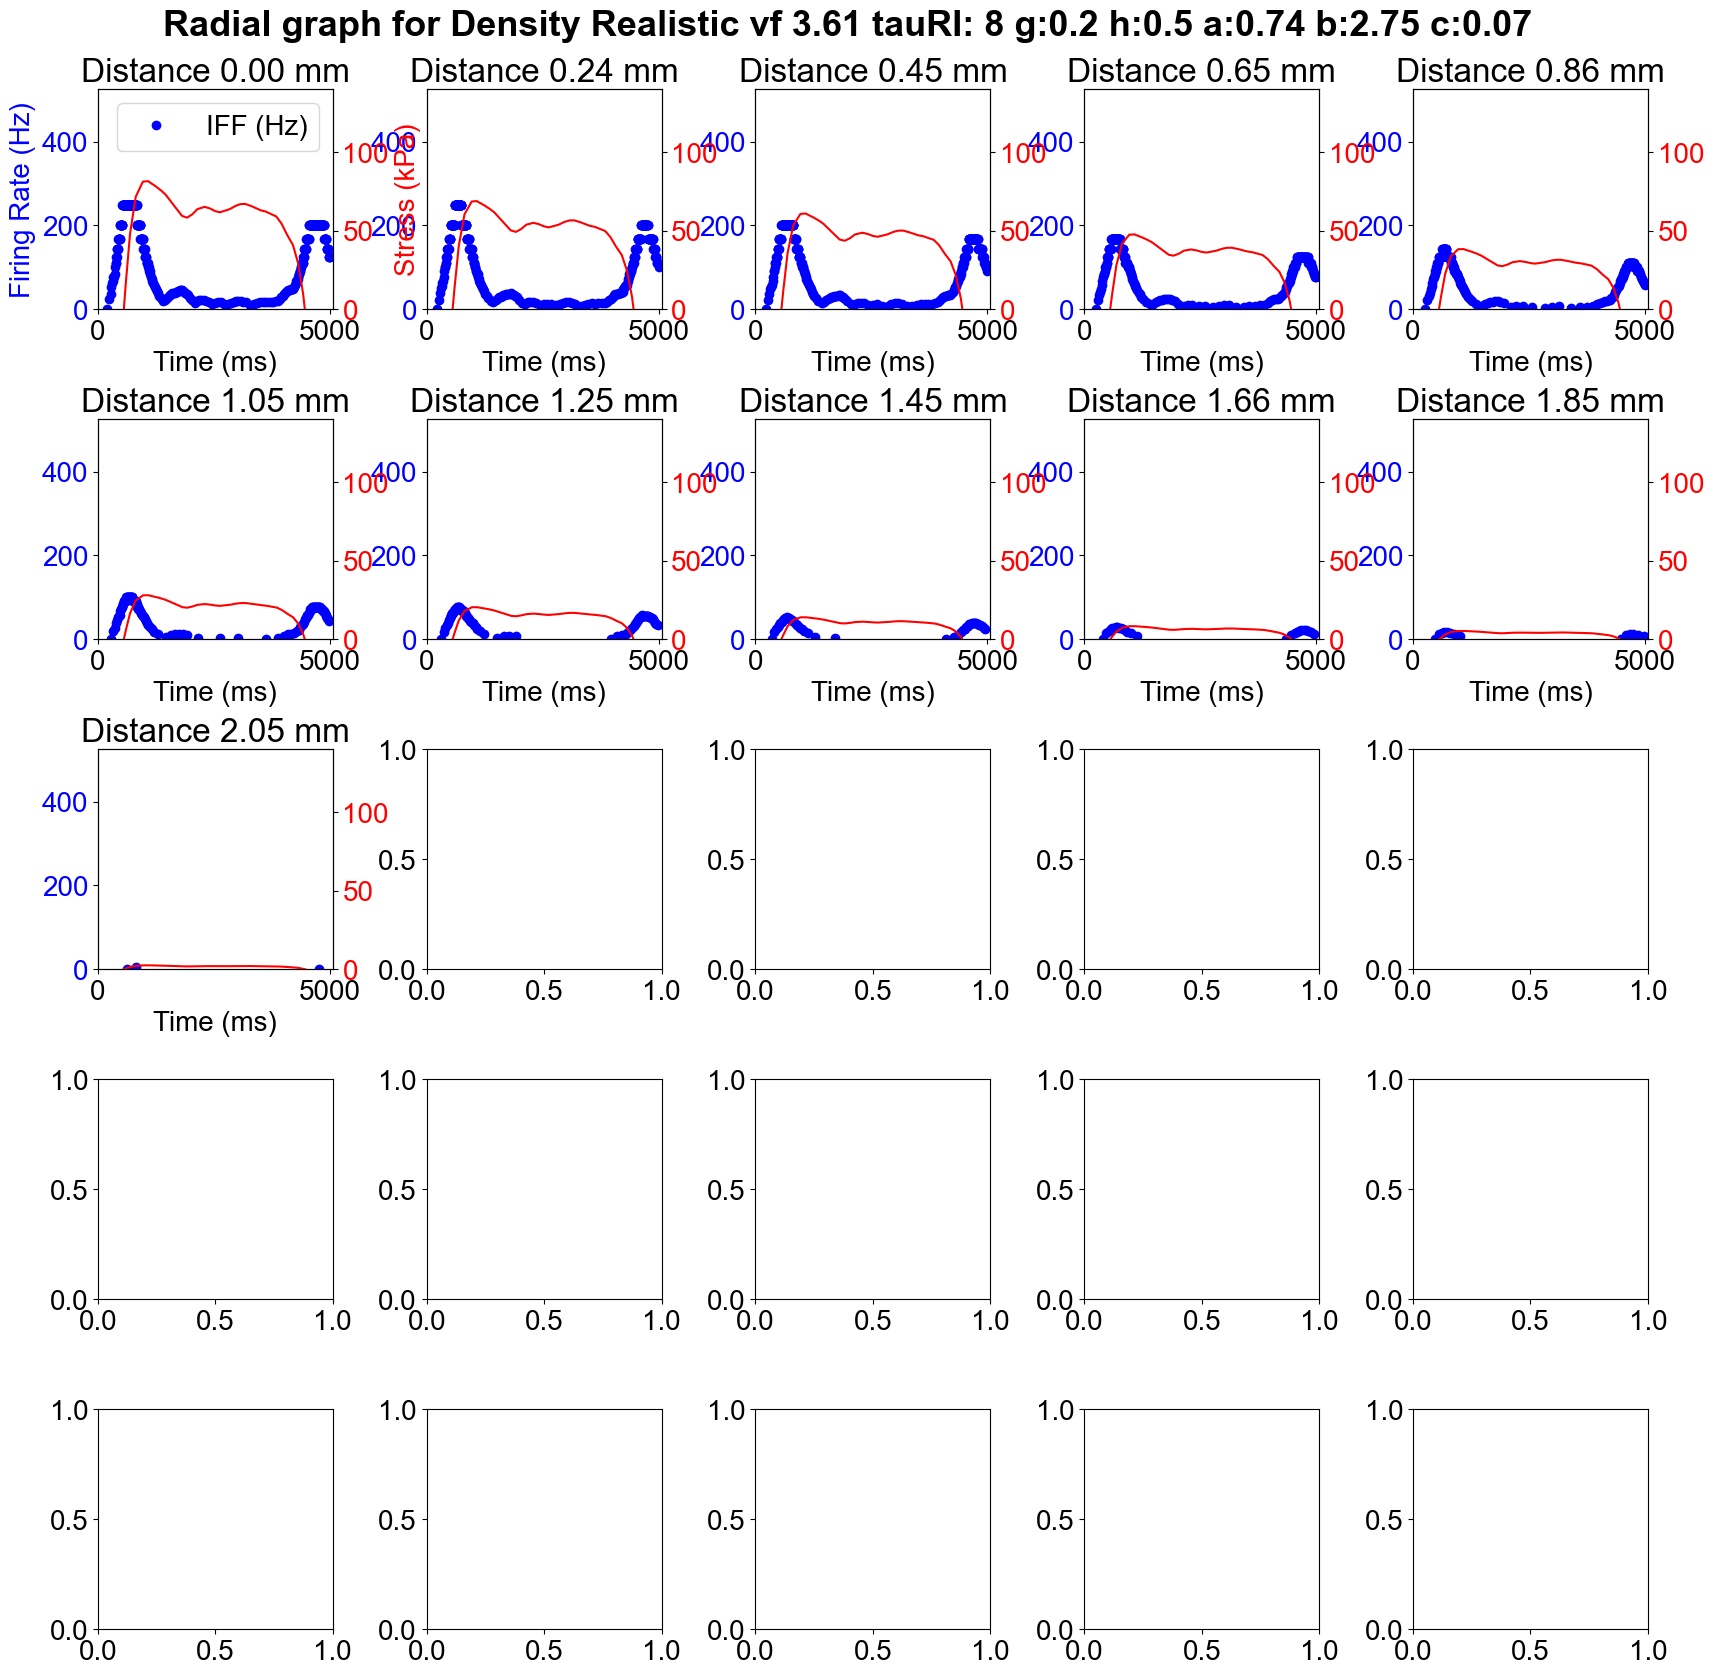

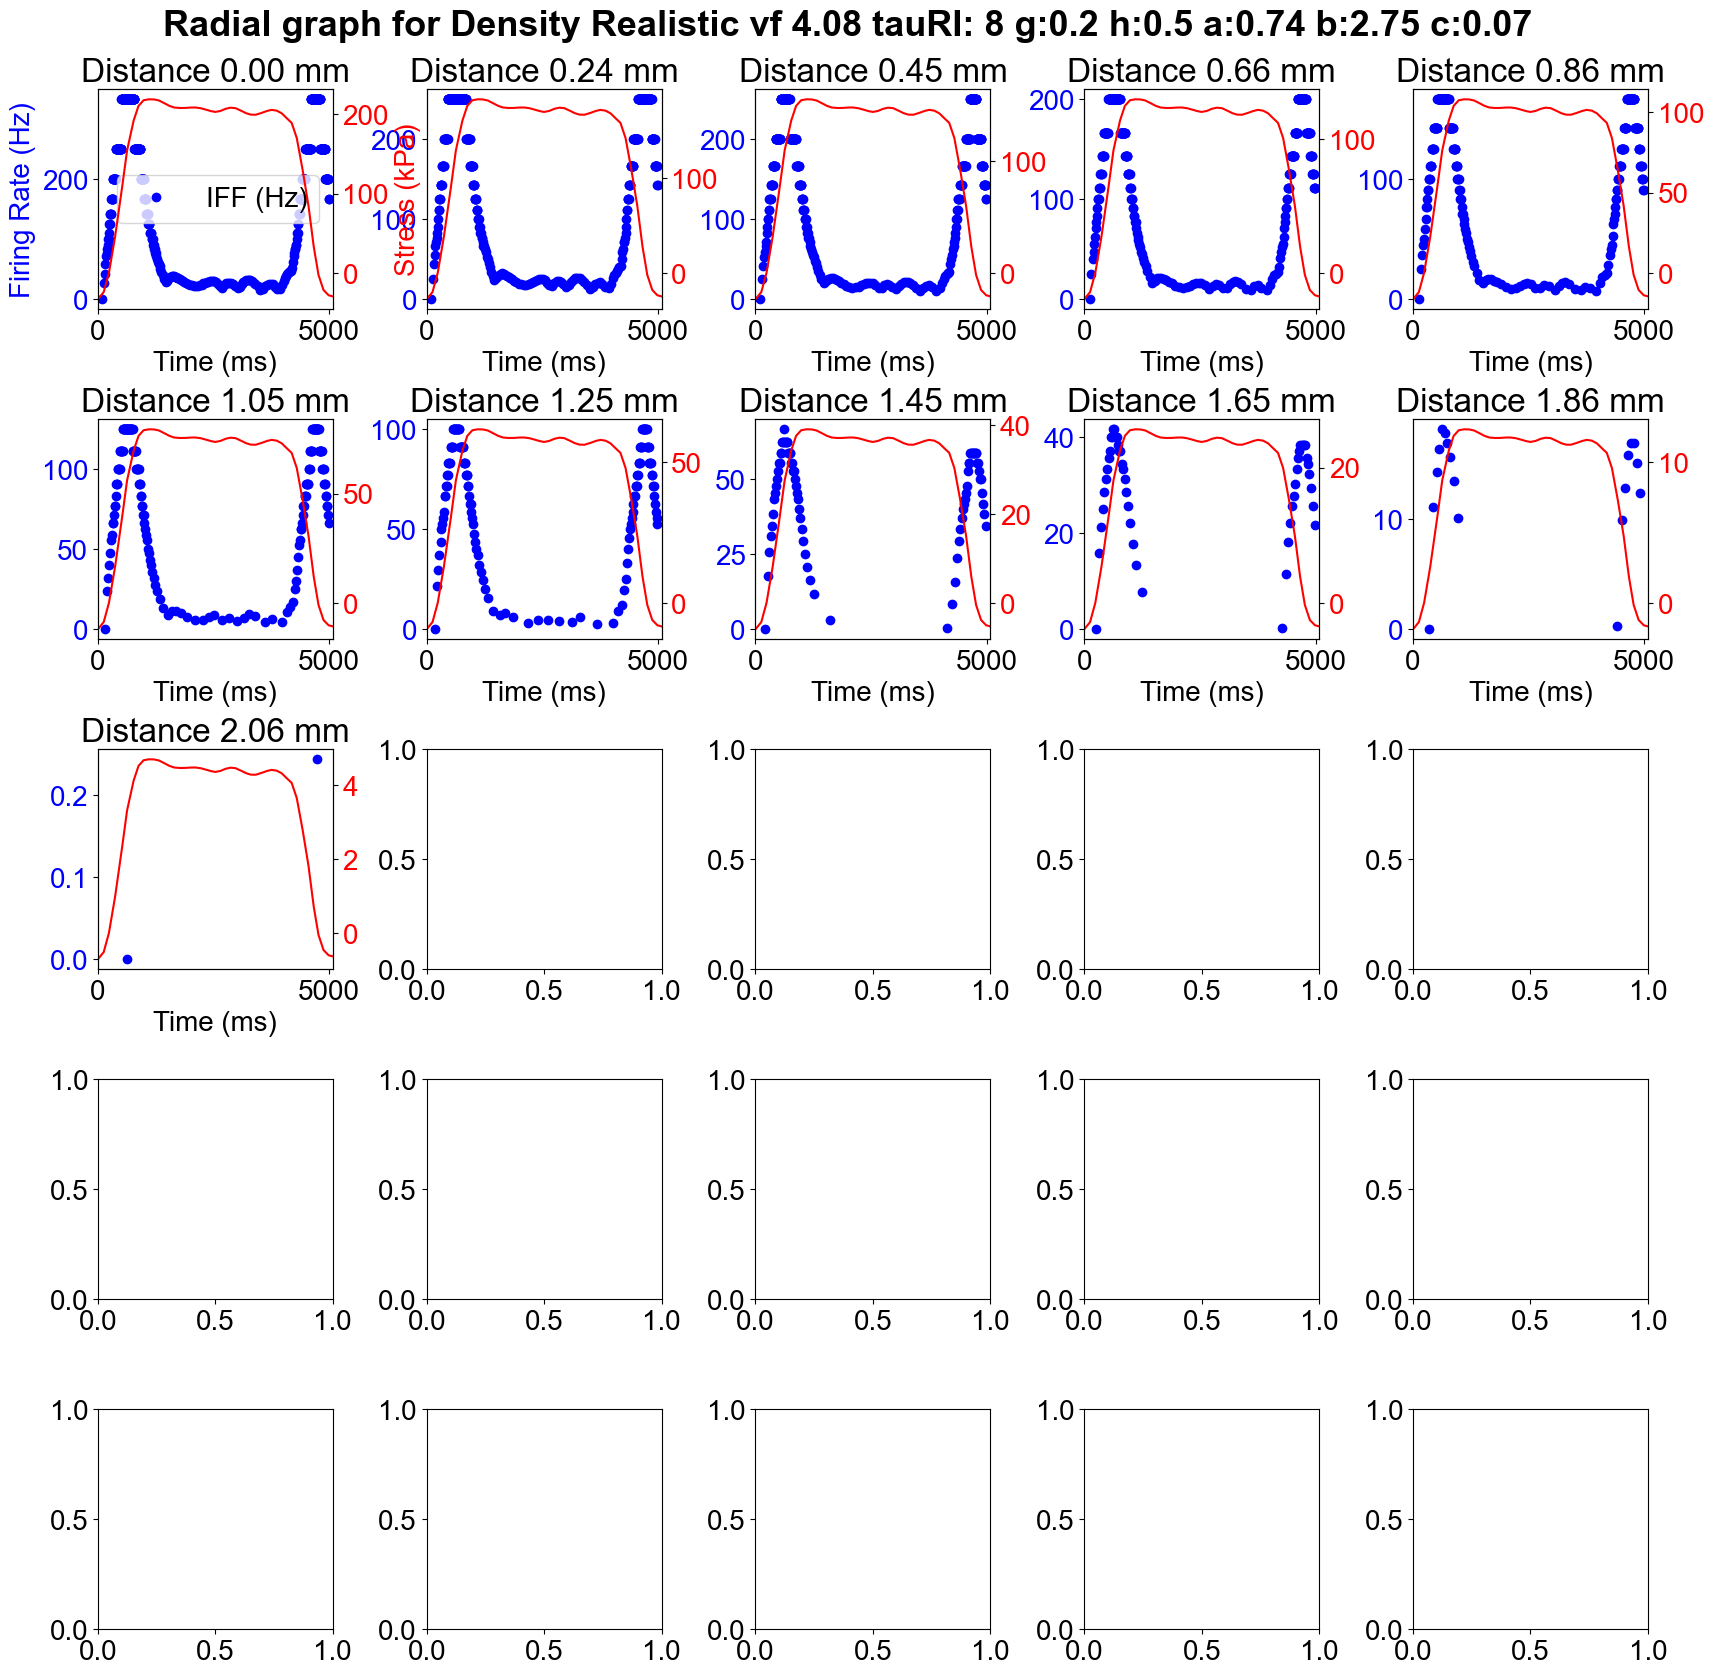

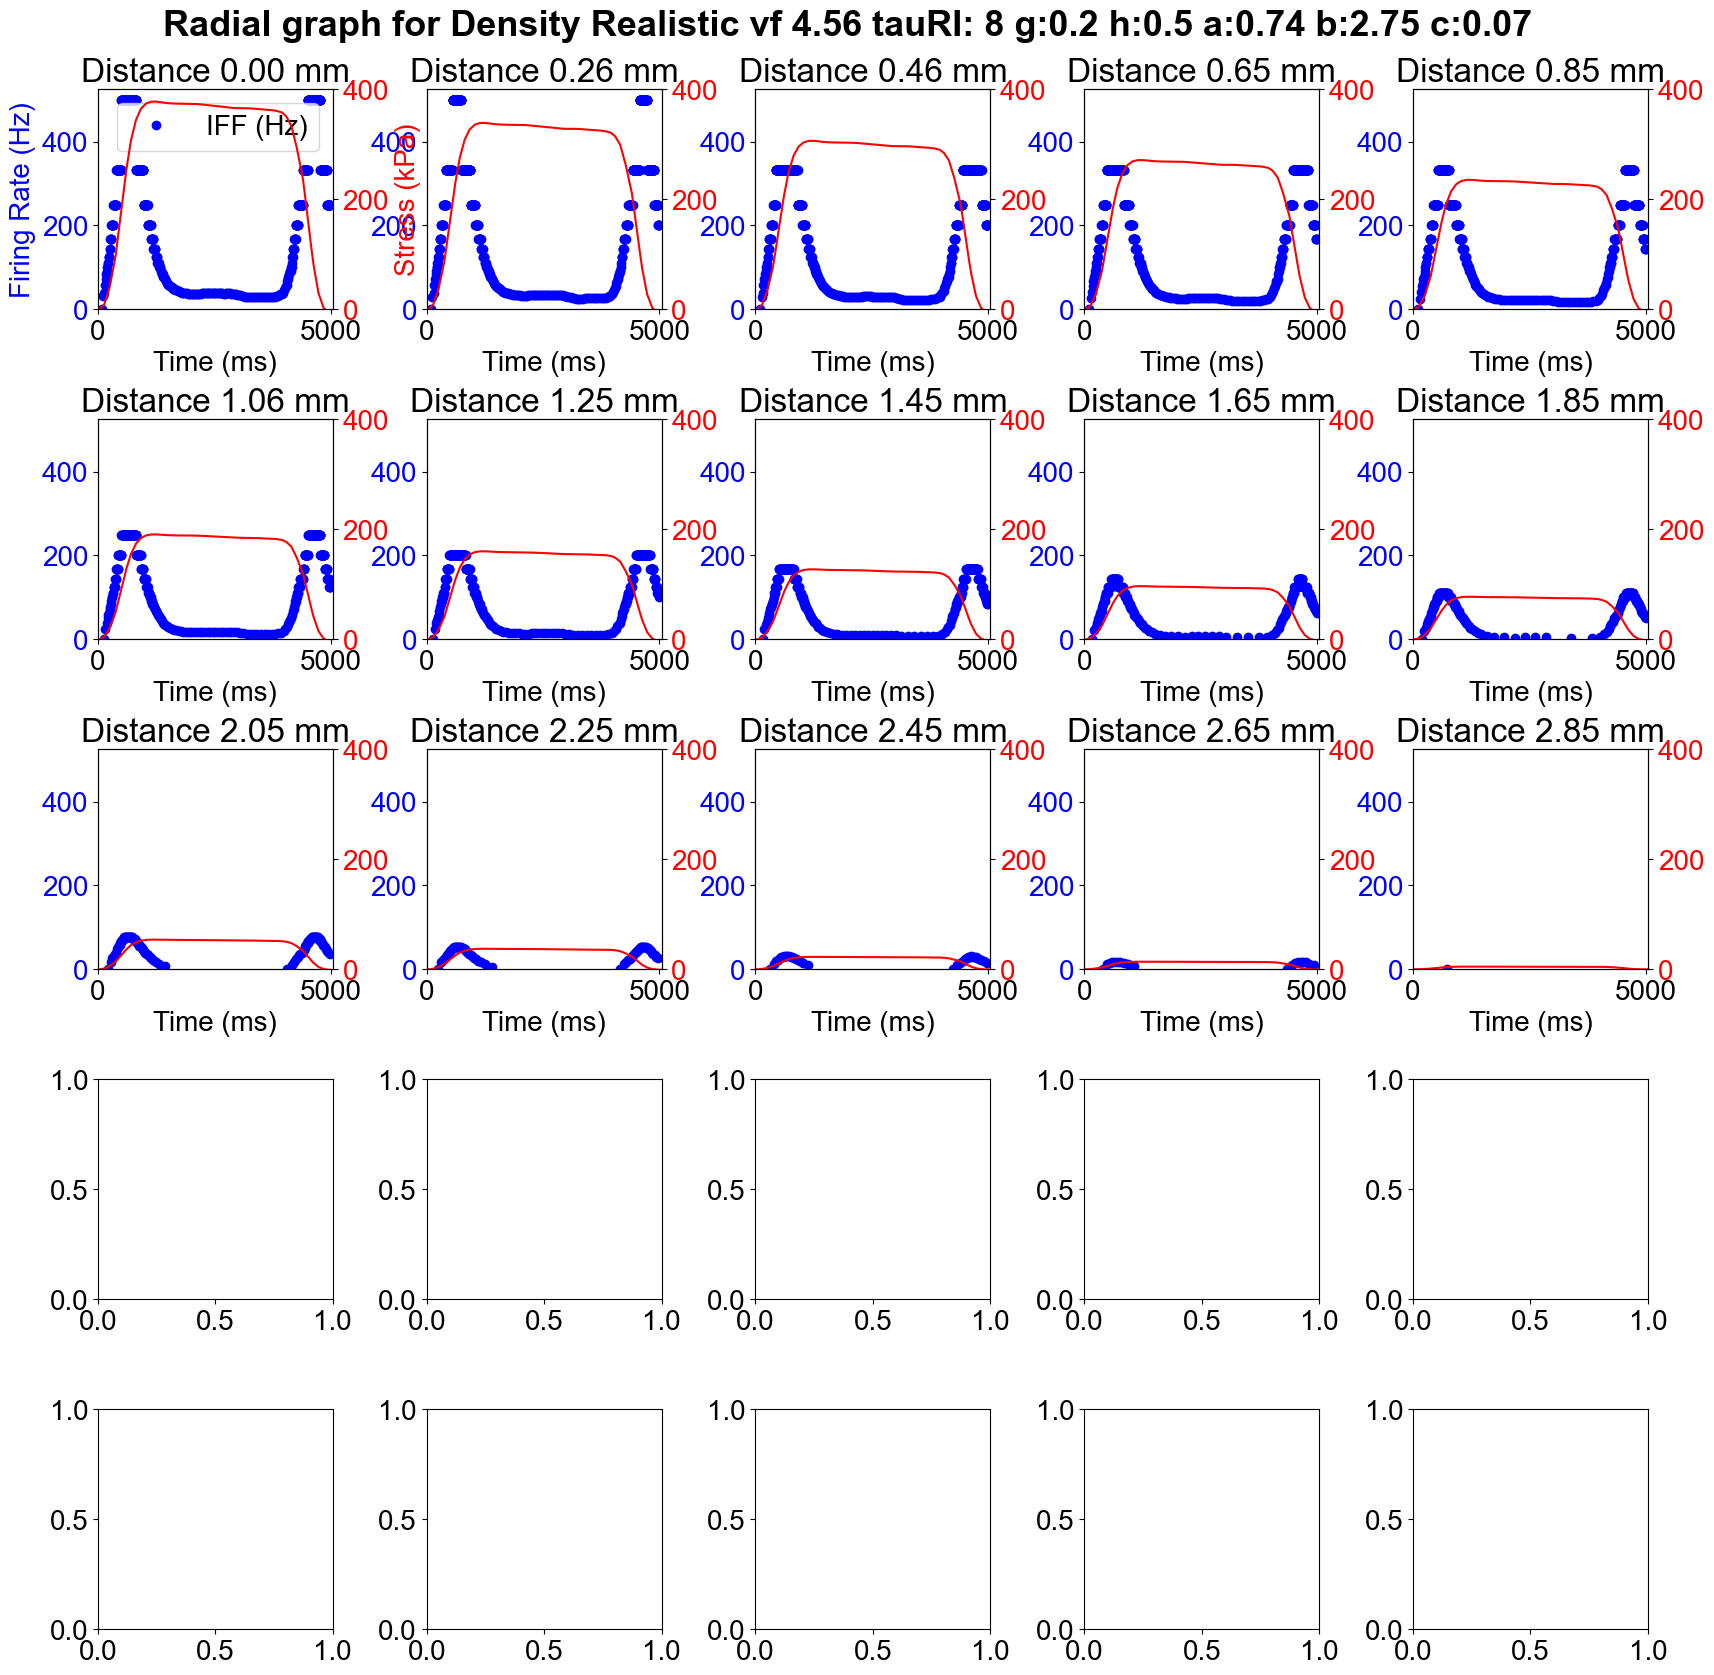

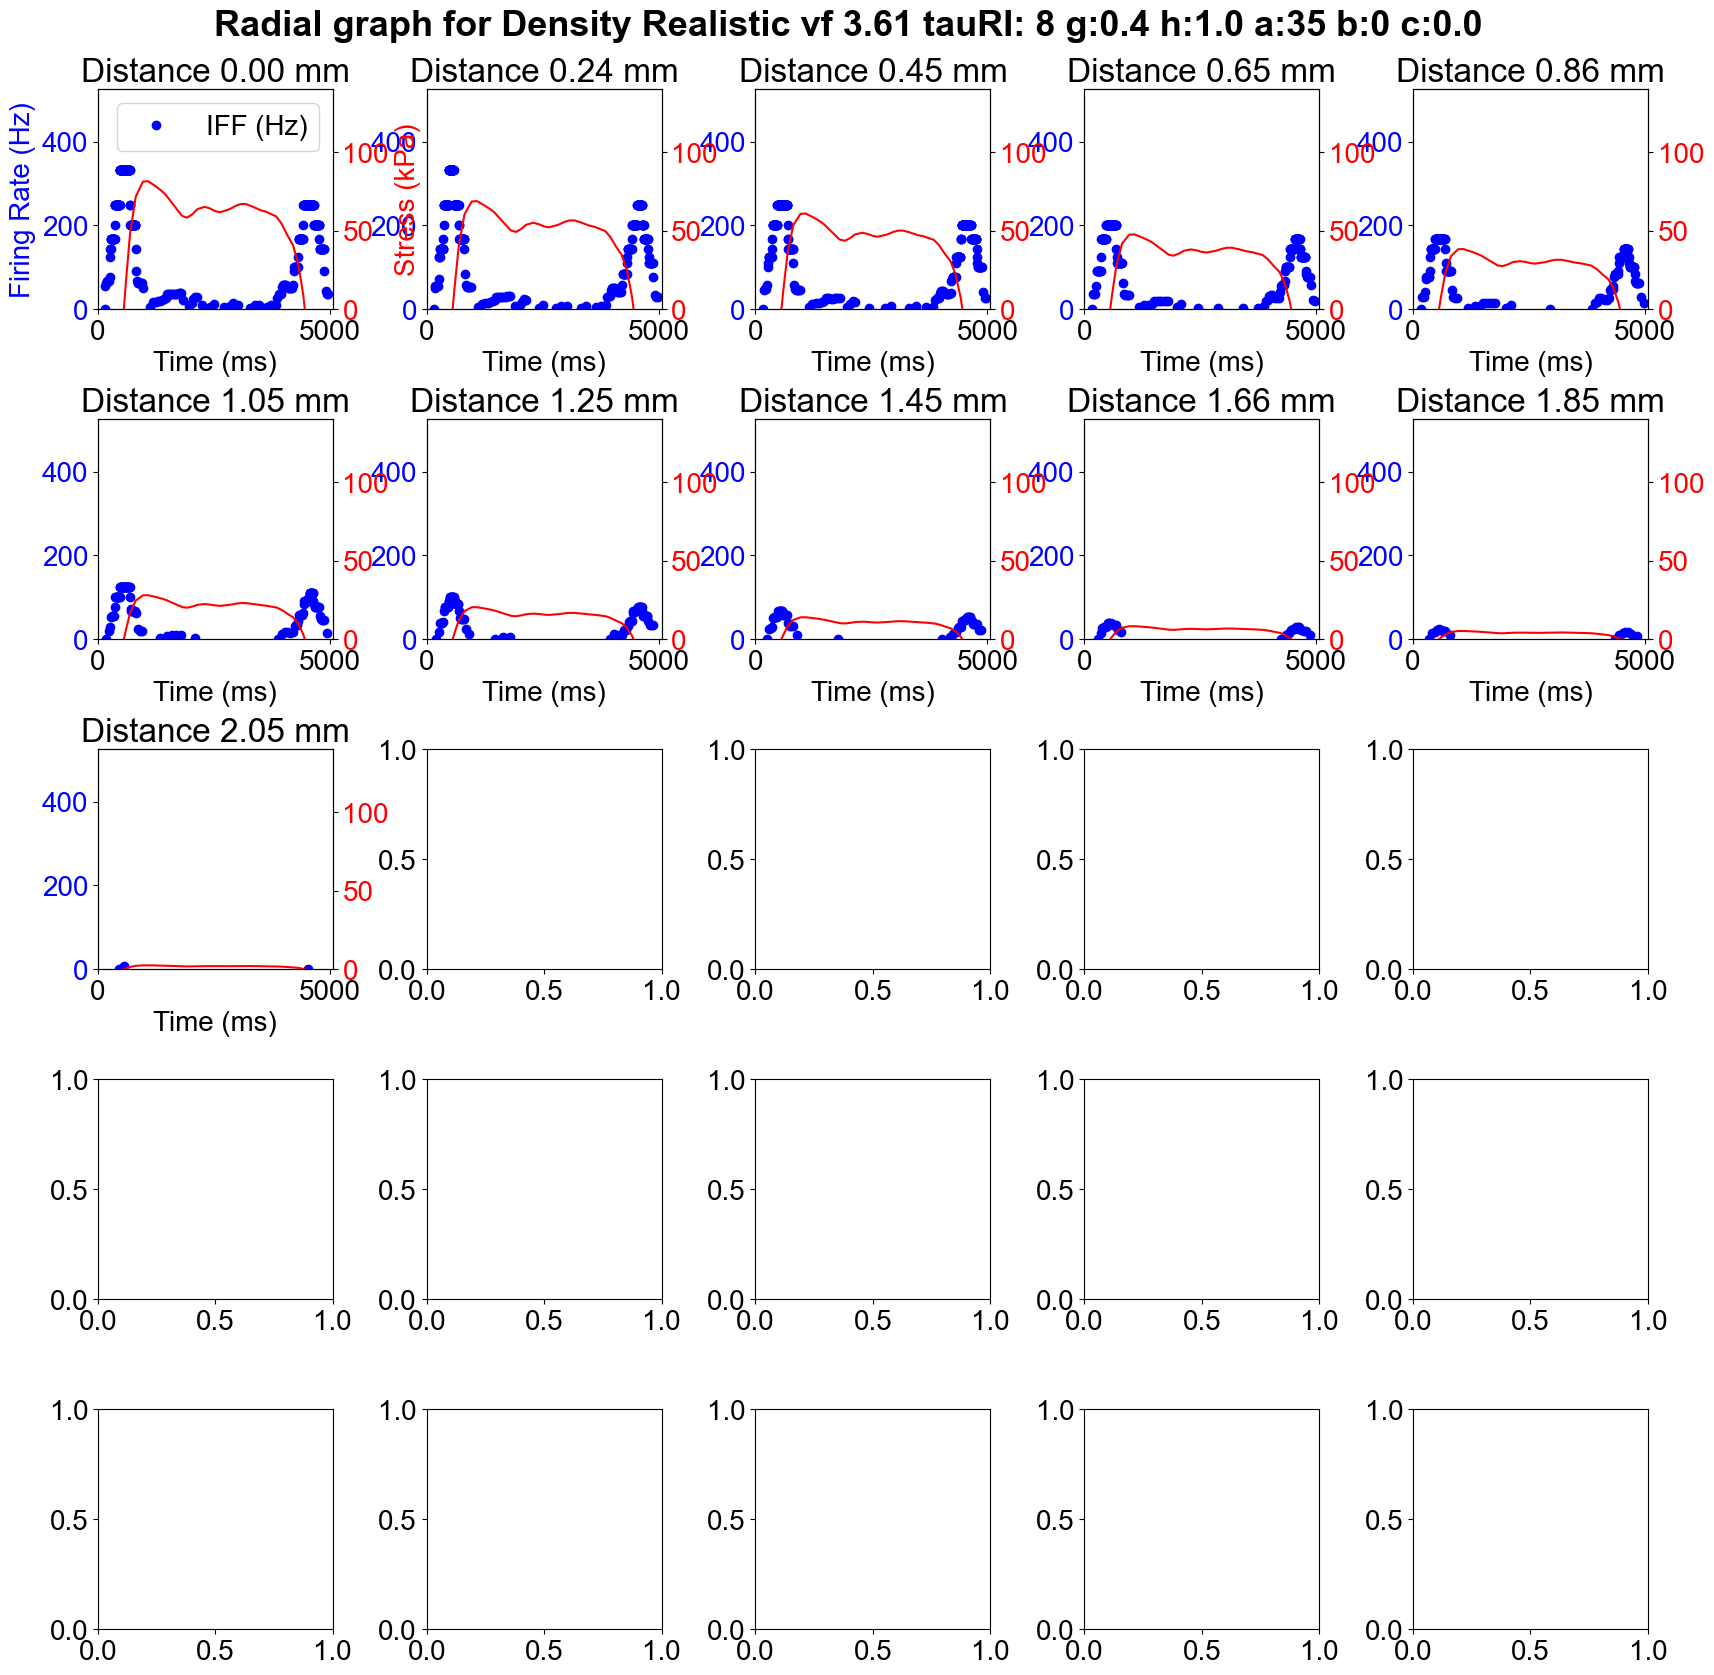

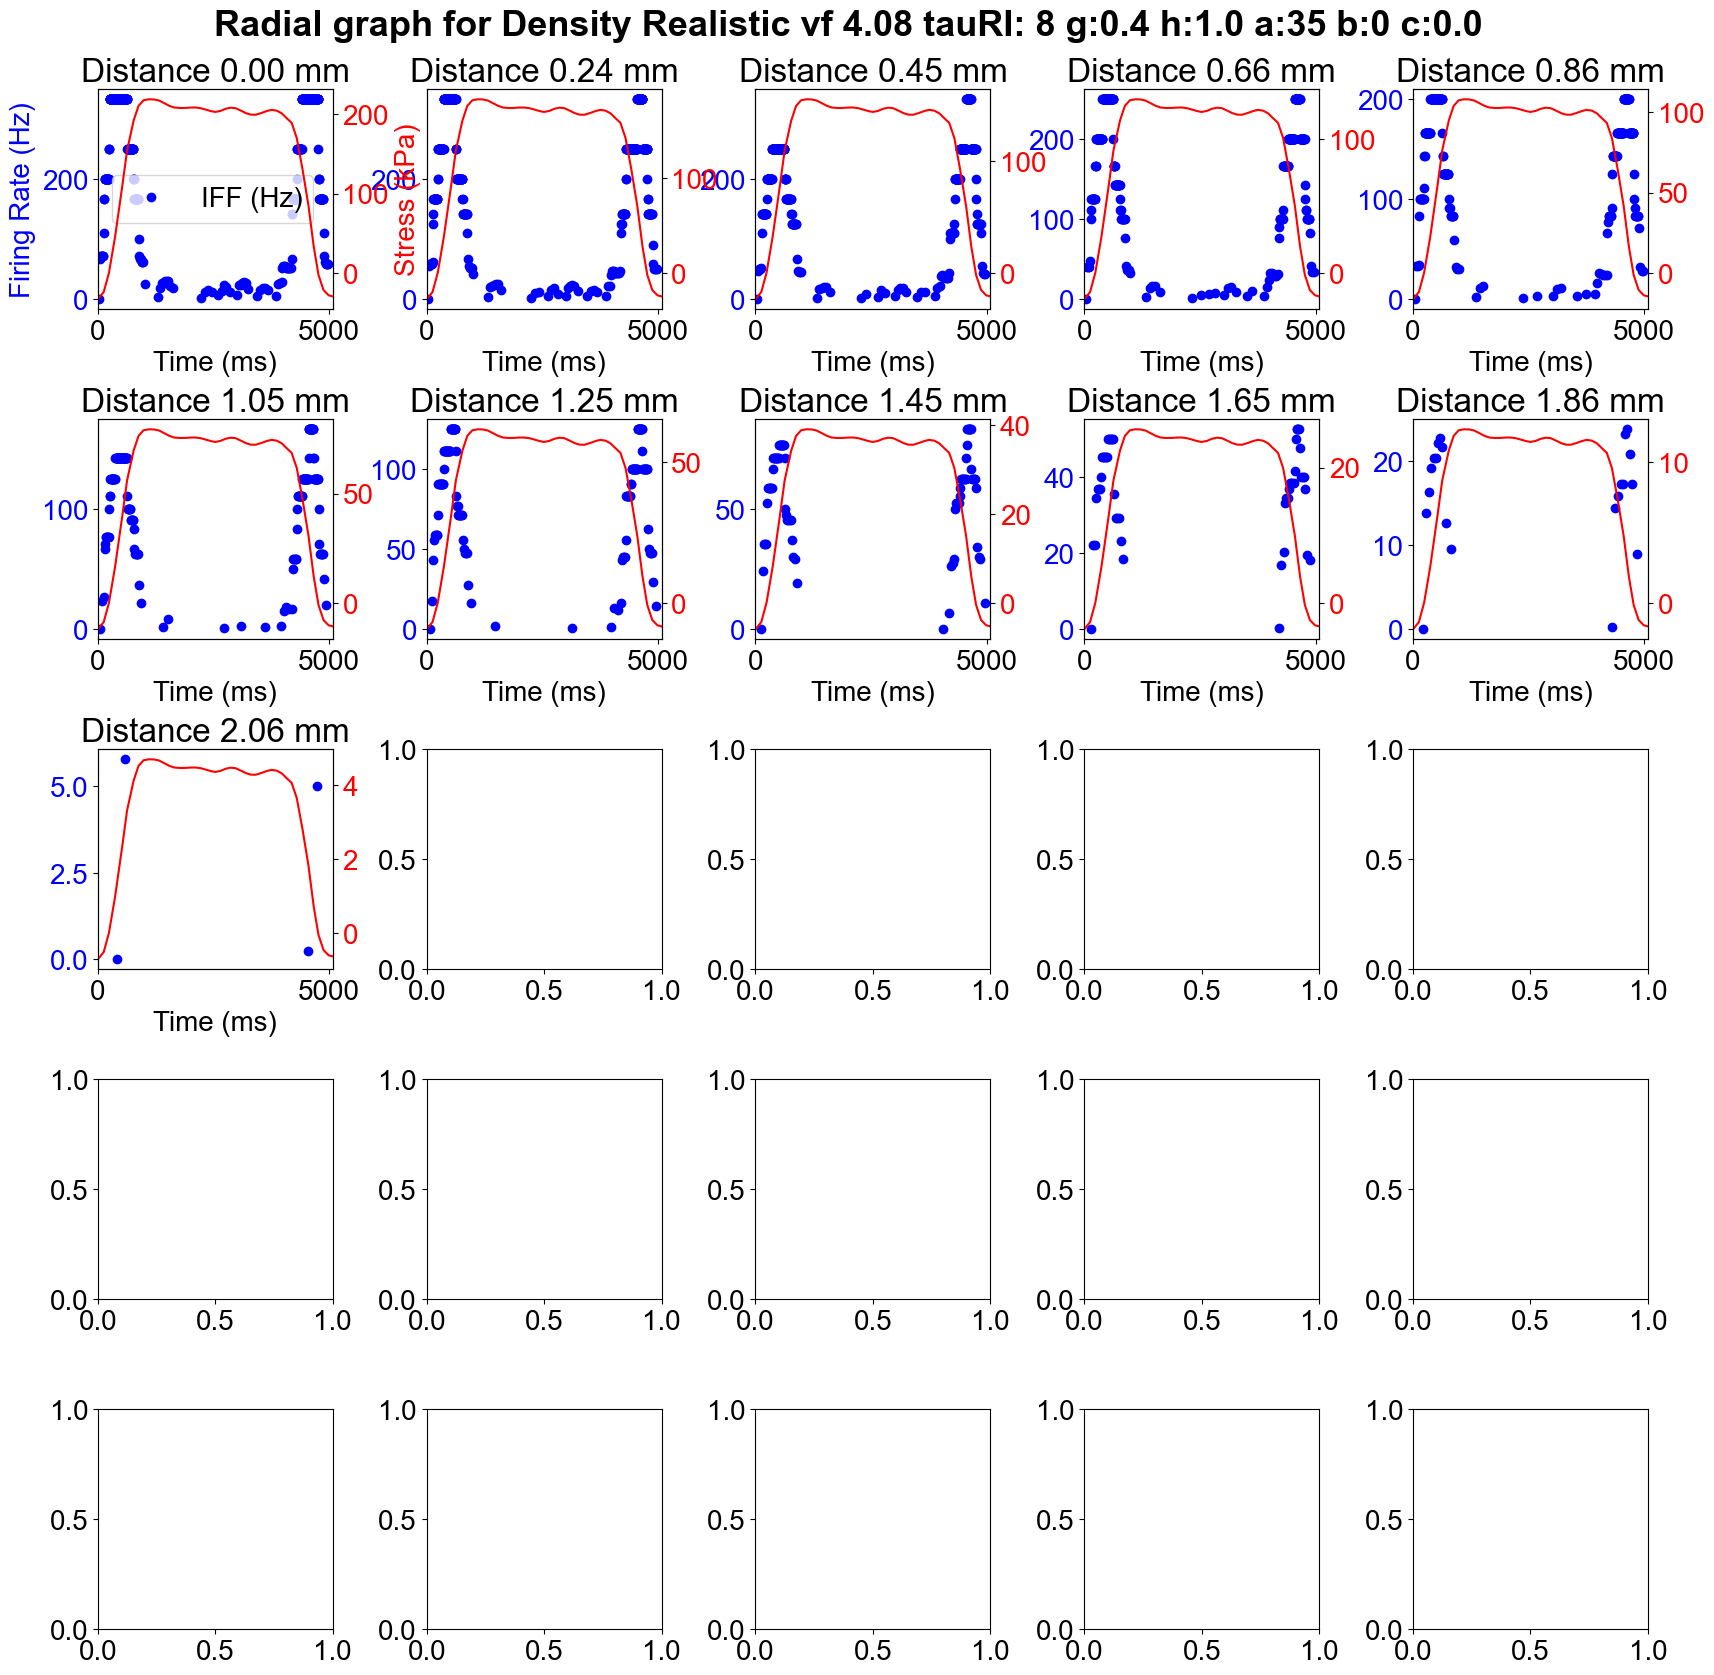

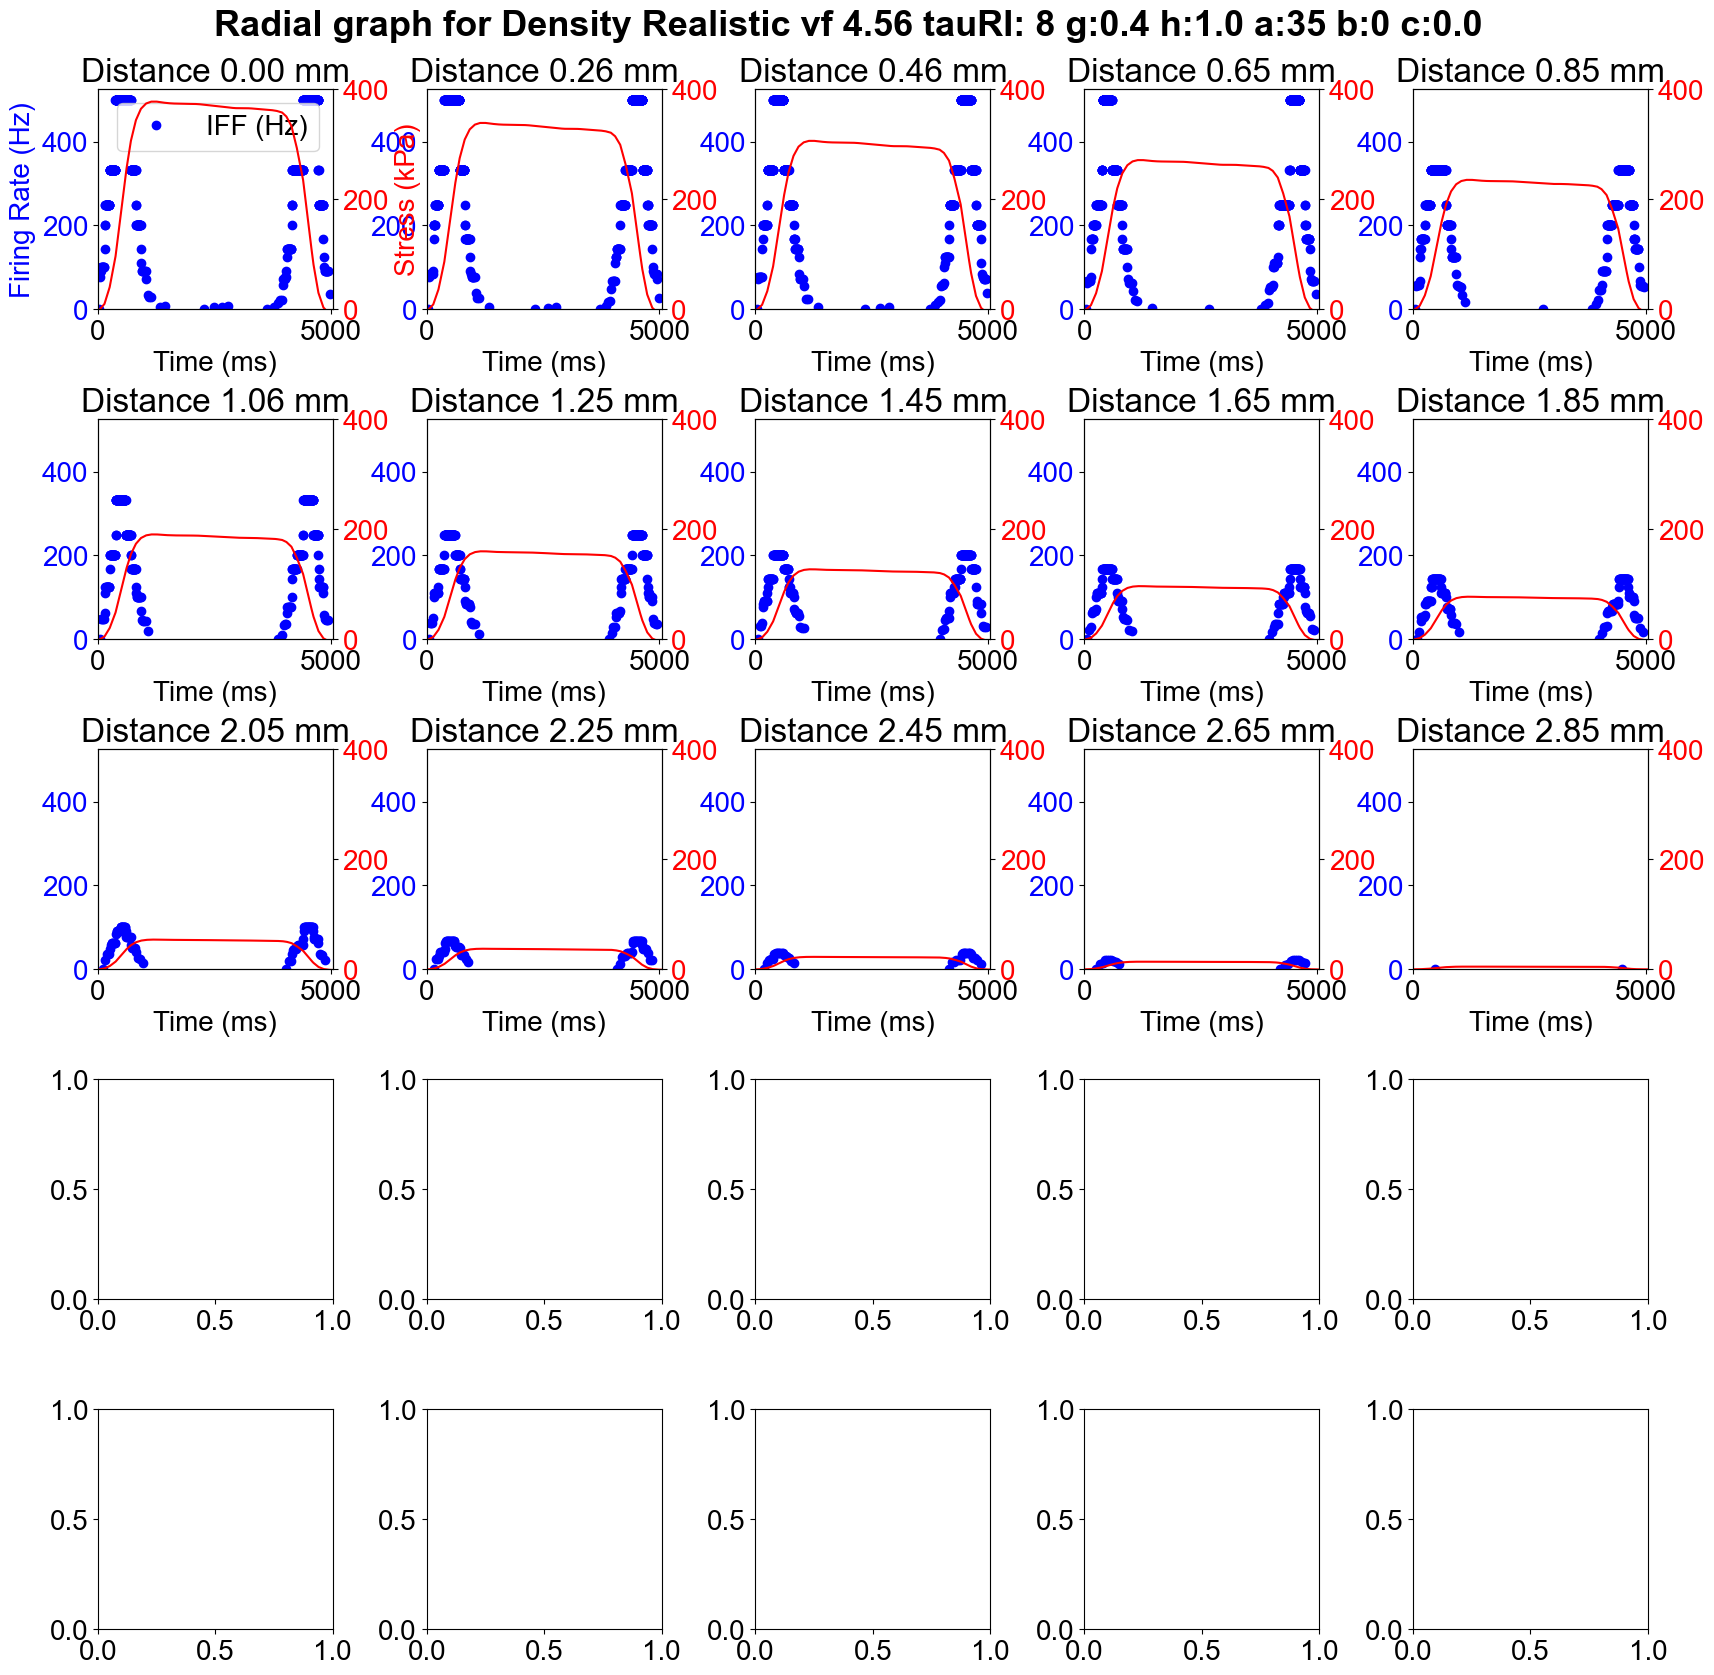

In [11]:
for aff_type in ["SA","RA"]:
    for vf_tip in [3.61,4.08,4.56]:
        vf_model = VF_Population_Model(vf_tip, aff_type, scaling_factor=1.0, density="Realistic")
        vf_model.radial_stress_vf_model()
        vf_model.run_single_unit_model_combined_graph()

Reading in data for Realistic density


Reading in data for Realistic density


Reading in data for Realistic density


Reading in data for Realistic density


Reading in data for Realistic density


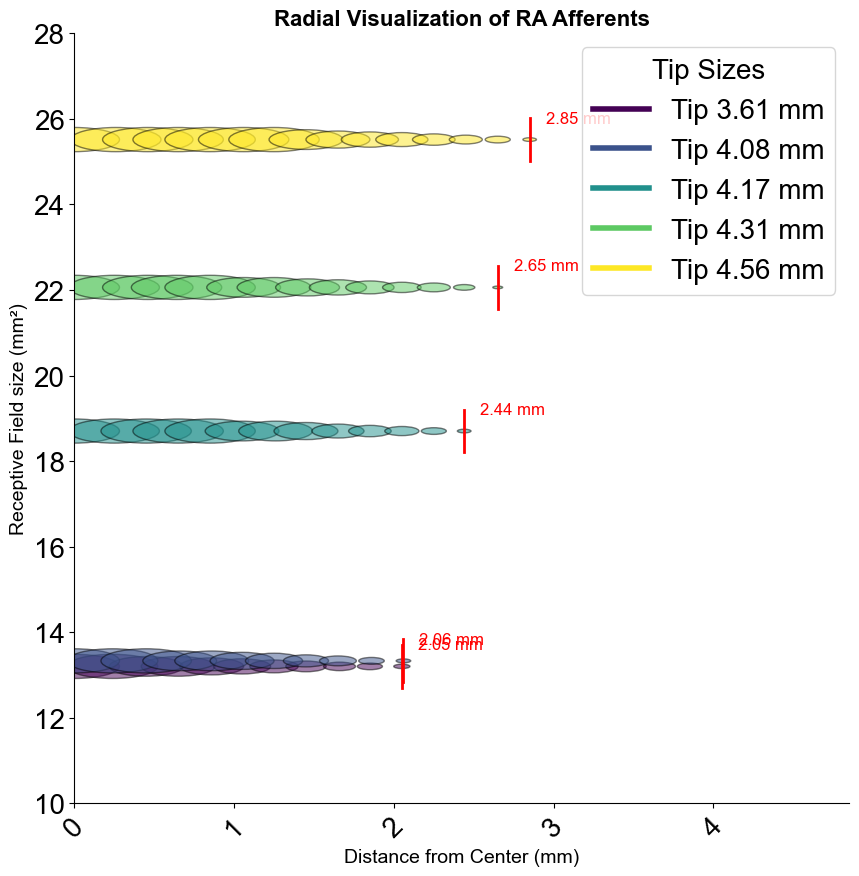

In [7]:
VF_Population_Model.radial_visualization_on_spatial_coords(aff_type="RA")

Reading in data for Realistic density


Reading in data for Realistic density


Reading in data for Realistic density


Reading in data for Realistic density


Reading in data for Realistic density


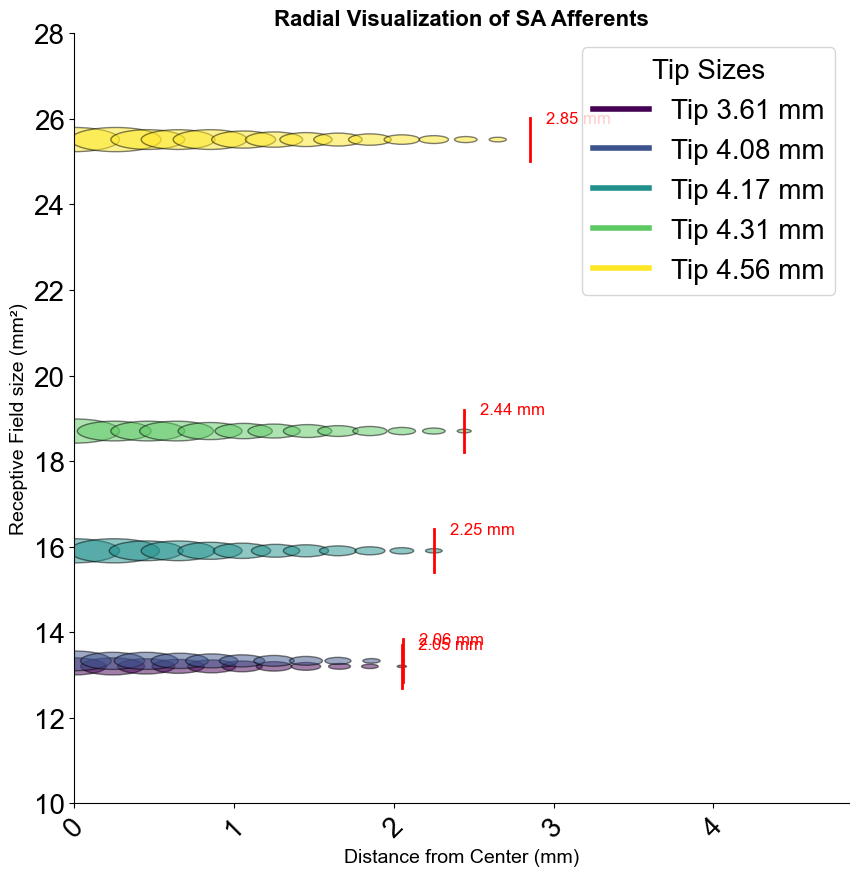

In [8]:
VF_Population_Model.radial_visualization_on_spatial_coords(aff_type="SA")
# VF_Population_Model.radial_visualization_on_spatial_coords(aff_type="SA")


### Doing a Sensitivity Analysis to tune different parameters

In [ ]:
sensitivity_variables = ["k1"]

vf_model = VF_Population_Model(3.61, "RA", scaling_factor= 1.0, density = "Med")

vf_model.radial_stress_vf_model(.4,1)

for var in sensitivity_variables:
    vf_model.sensitivity_analysis(var)

In [ ]:
tau1_values = [1,8,30,100]
k2_values = [2,4,8,16]
h_values = [0.1,0.2,0.3,0.4,0.5]
g_values = [0, 0.25, 0.50, 0.75, 1.0]

vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
lmpars = lmpars_init_dict['t3f12v3final']

for value in tau1_values:
    lmpars["tau1"].set(value = value)
    vf_model.radial_stress_vf_model()
for value in k2_values:
    lmpars["k2"].set(value = value)
    vf_model.radial_stress_vf_model()
for value in h_values:
    vf_model.radial_stress_vf_model(value, 1)
for value in g_values:
    vf_model.radial_stress_vf_model(.4, value)

### Normal Radial Model Plots

VF_TIP: 3.61
Reading in data for Realistic density
VF_TIP: 4.08
Reading in data for Realistic density
VF_TIP: 4.17
Reading in data for Realistic density
VF_TIP: 4.31
Reading in data for Realistic density
VF_TIP: 4.56
Reading in data for Realistic density


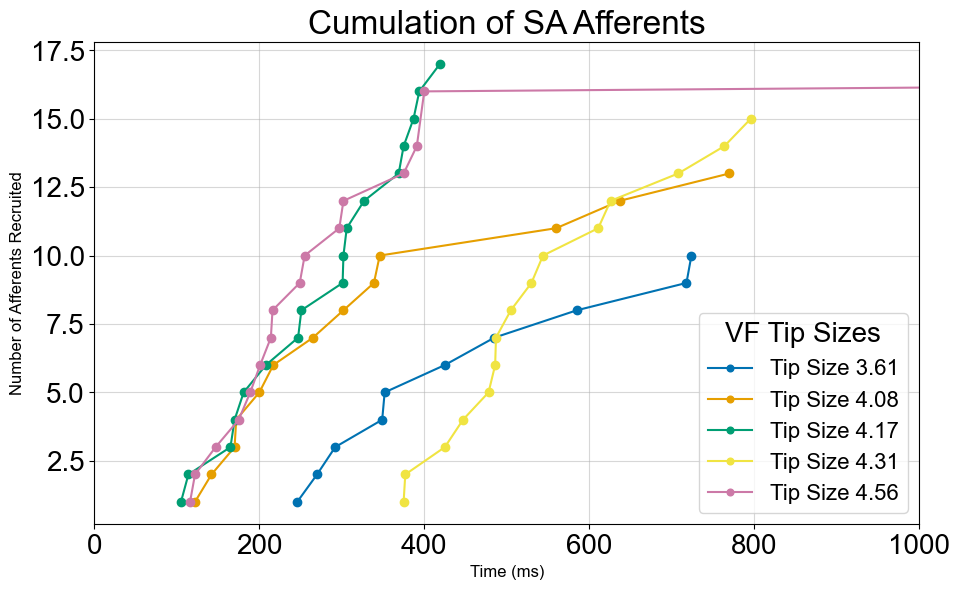

In [ ]:
VF_Population_Model.cumulative_afferent_over_time(afferent_type="SA", density = "Realistic")


#### Generating the Spatial Plots

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

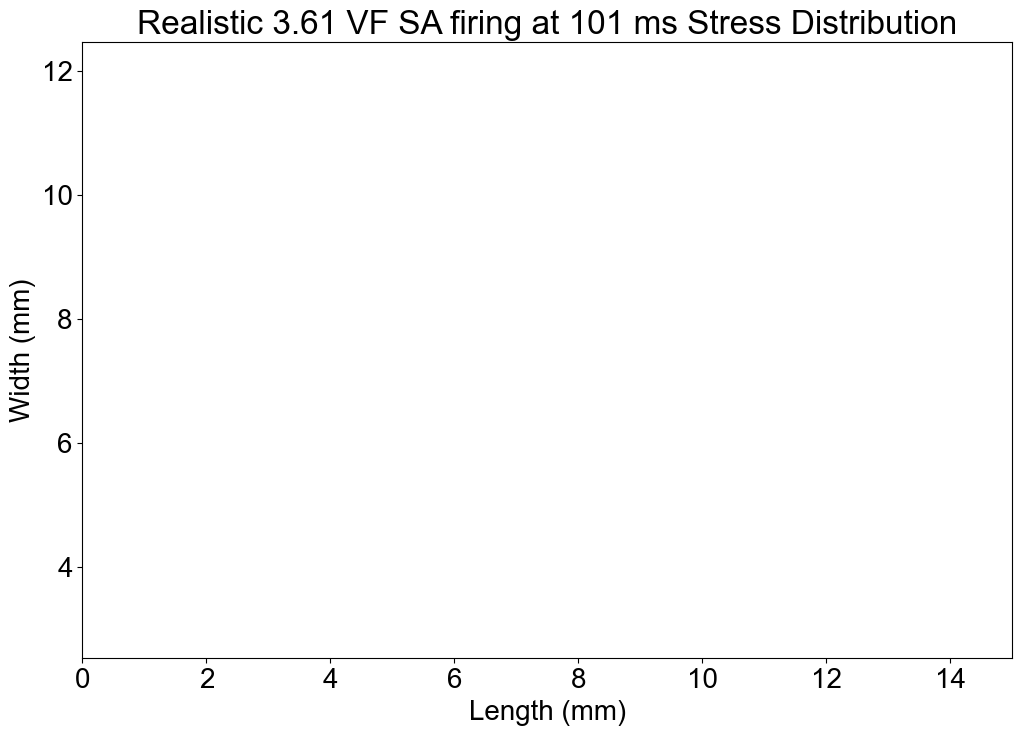

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

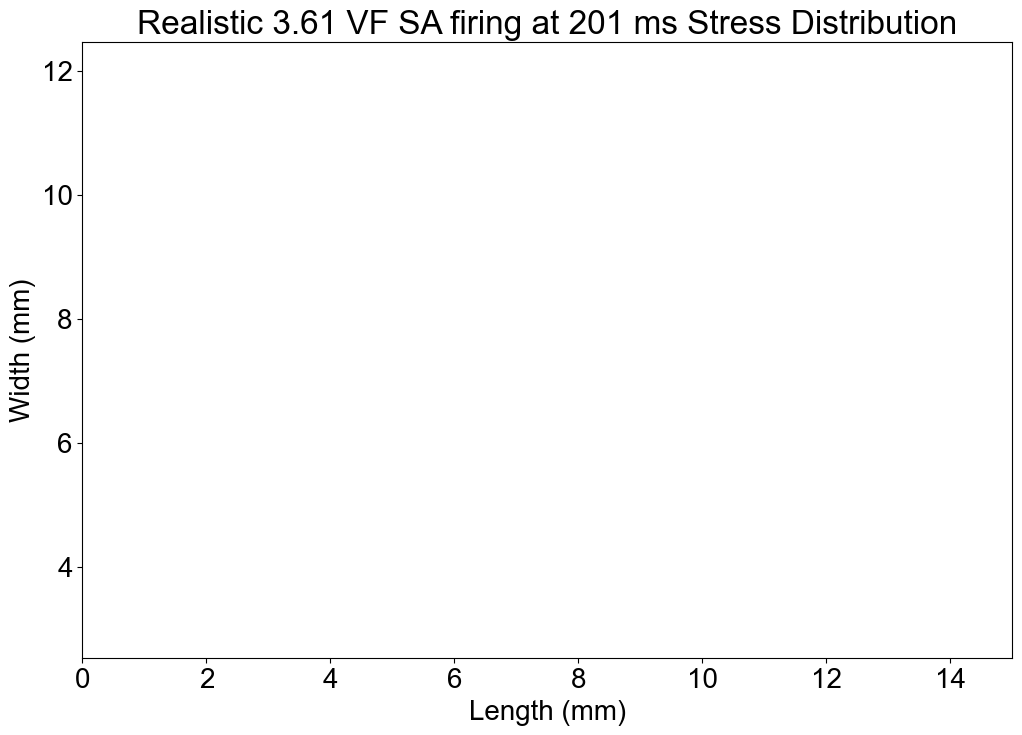

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

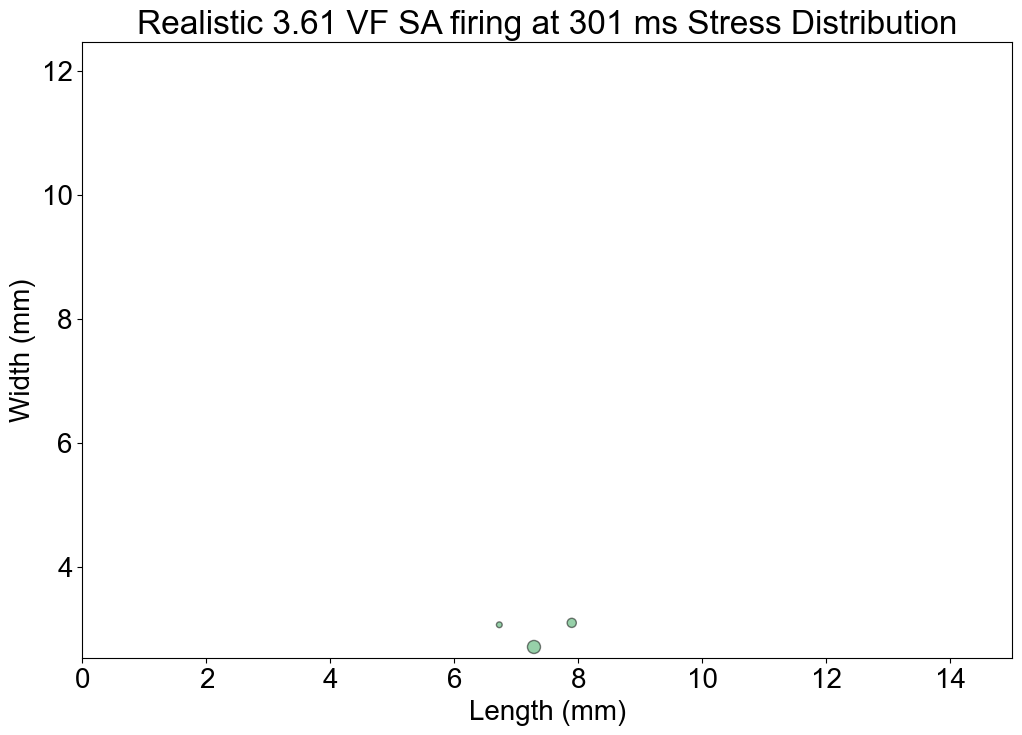

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

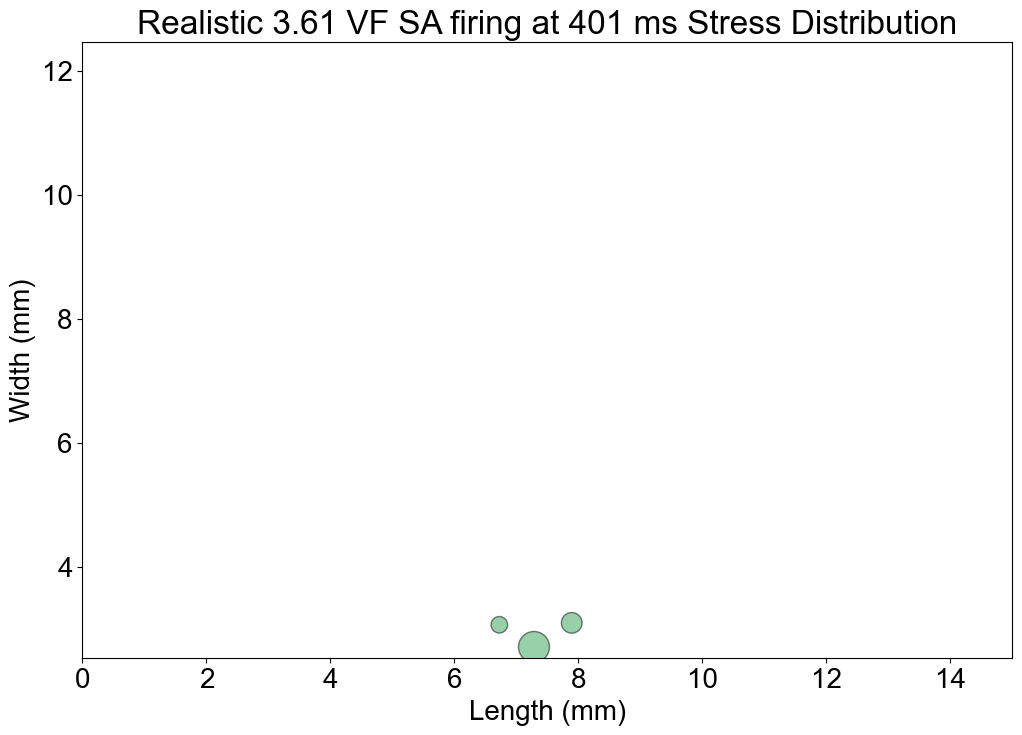

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

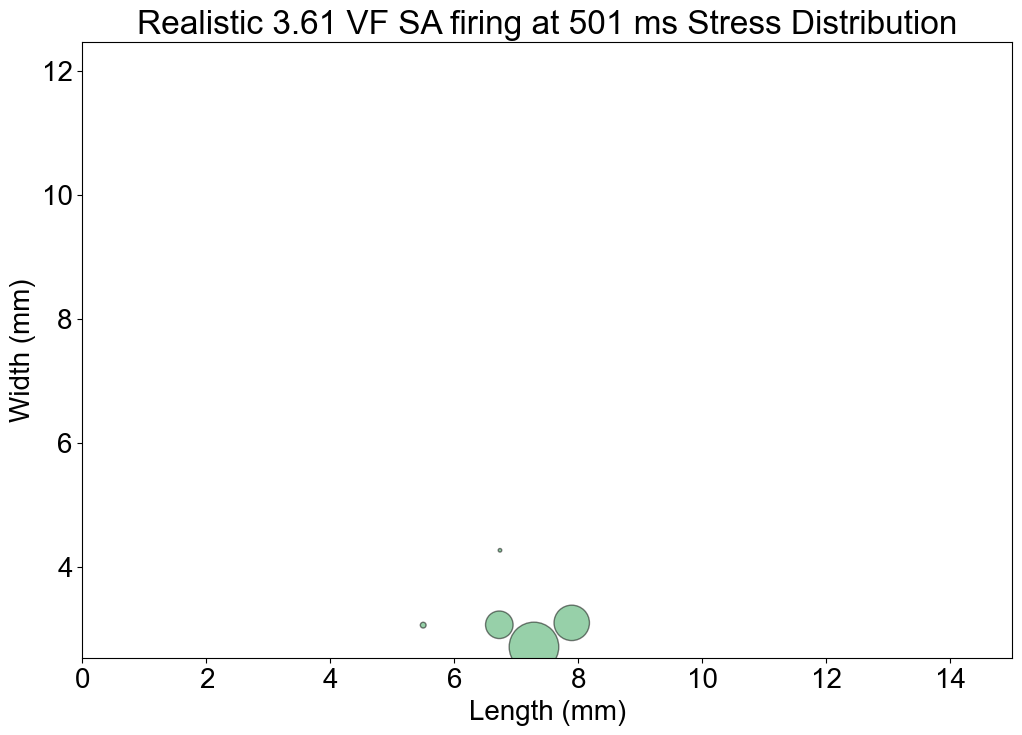

Reading in data for Realistic density


TypeError: can only concatenate str (not "int") to str

In [ ]:
for index, vf_tip in enumerate(vf_cumulative_SA.keys()):
    if index == 1:
        break
    for time_of_firing in vf_cumulative_SA[vf_tip].keys():
        vf_model = VF_Population_Model(vf_tip_size= vf_tip,aff_type= "SA", scaling_factor= 1.0, density="Realistic")
        vf_model.radial_stress_vf_model(g = .2, h = .5)
        vf_model.run_single_unit_model_combined_graph(plot=False)
        vf_model.spatial_stress_vf_model(time_of_firing= time_of_firing+1)
        vf_model.plot_spatial_coords()

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

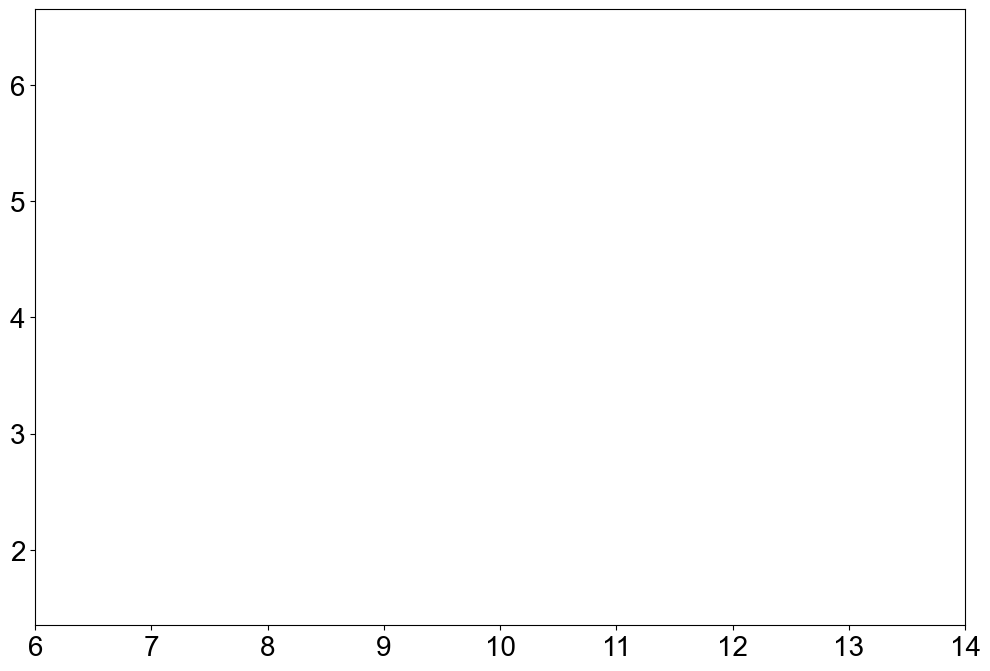

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

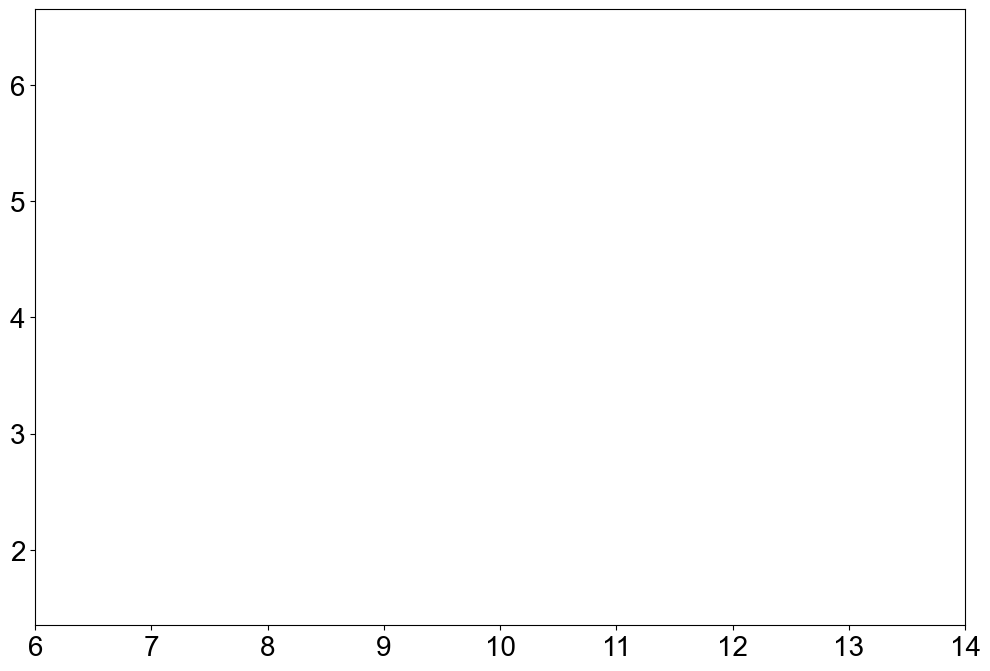

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

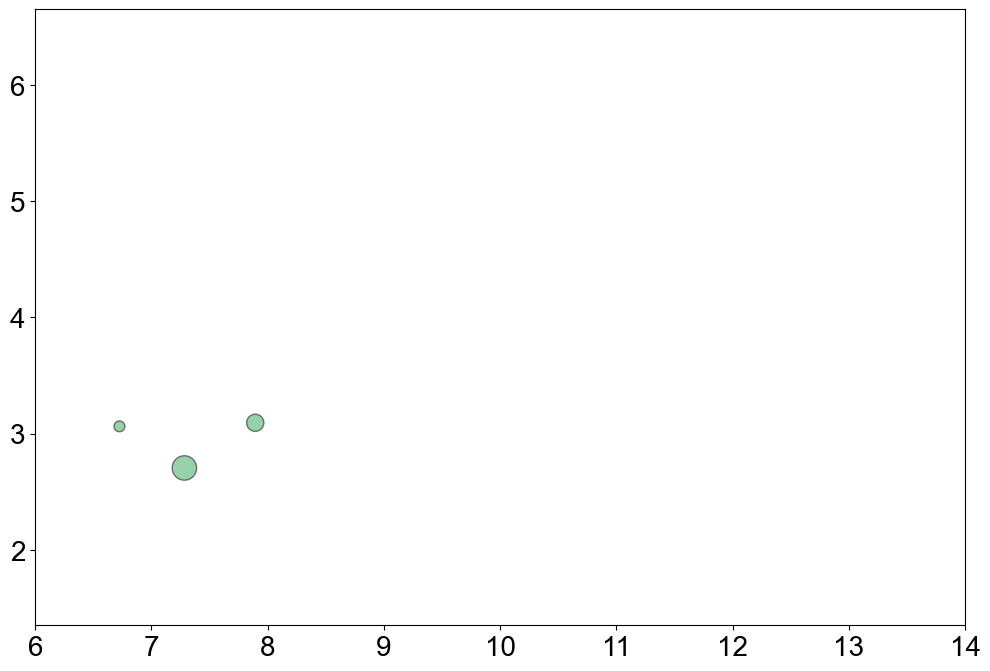

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

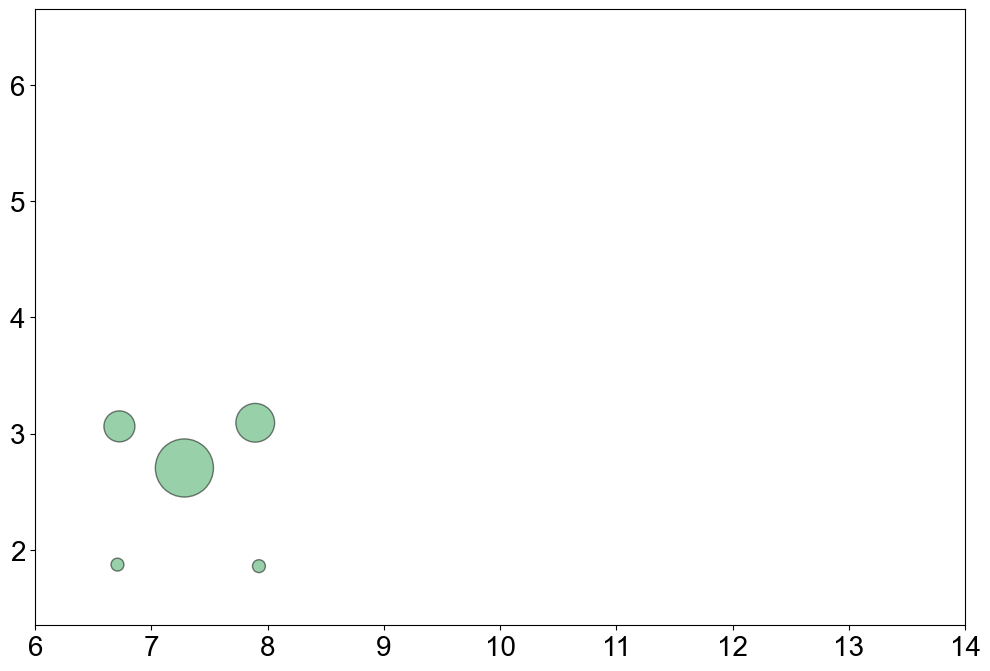

Reading in data for Realistic density
MOD_SPIKE_TIME:[ 205.  246.  273.  292.  308.  323.  336.  349.  361.  371.  380.  389.
  397.  405.  412.  419.  426.  433.  439.  445.  451.  457.  463.  469.
  475.  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  529.
  533.  537.  541.  545.  549.  553.  557.  561.  565.  569.  573.  577.
  581.  585.  589.  593.  597.  601.  605.  609.  613.  617.  621.  625.
  629.  633.  637.  641.  645.  649.  653.  657.  661.  665.  669.  673.
  677.  681.  685.  689.  693.  697.  701.  705.  709.  713.  717.  721.
  725.  729.  733.  737.  741.  745.  749.  753.  757.  761.  765.  769.
  773.  777.  781.  785.  789.  793.  797.  801.  805.  809.  813.  817.
  821.  825.  829.  833.  837.  842.  847.  852.  857.  862.  867.  872.
  877.  882.  887.  892.  897.  902.  907.  912.  918.  924.  930.  936.
  942.  948.  954.  960.  966.  972.  979.  986.  993. 1000. 1007. 1015.
 1023. 1031. 1039. 1048. 1057. 1066. 1075. 1085. 1095. 1106. 1117. 1129

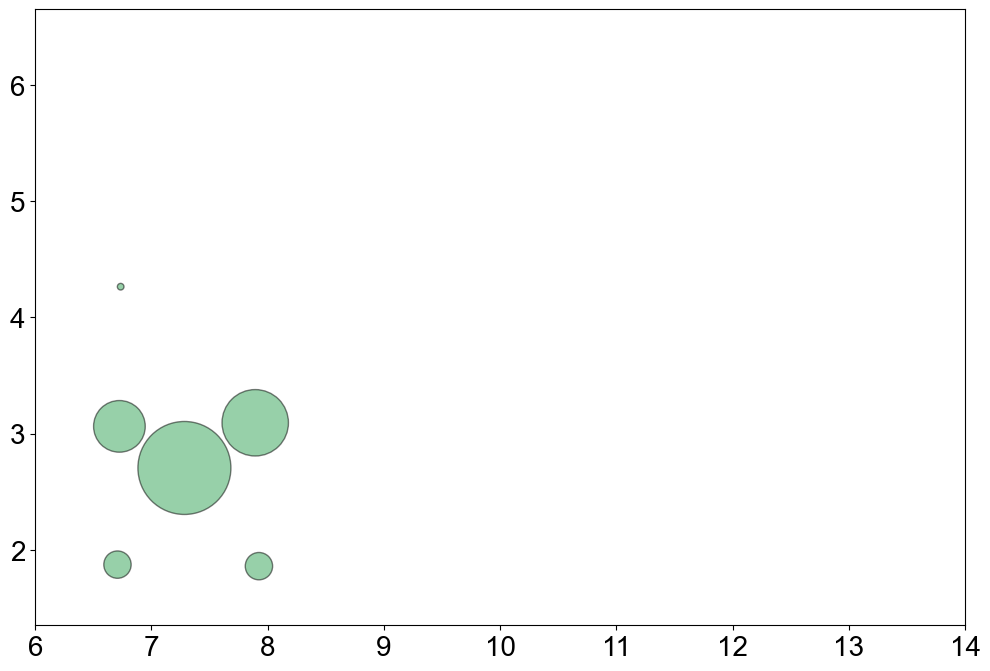

Reading in data for Realistic density
plotting 7.28337 2.70374 0.25 1.0
plotting 5.54576 1.85384 0.0 0
plotting 6.70757 1.87233 0.09090909090909091 0.36363636363636365
plotting 7.92439 1.85912 0.08333333333333333 0.3333333333333333
plotting 5.49658 3.05579 0.043478260869565216 0.17391304347826086
plotting 6.72428 3.06161 0.16666666666666666 0.6666666666666666
plotting 7.89256 3.09245 0.2 0.8
plotting 9.11829 3.15286 0.007352941176470588 0.029411764705882353
plotting 5.51816 4.26853 0.007518796992481203 0.03007518796992481
plotting 6.735 4.26303 0.027777777777777776 0.1111111111111111
plotting 7.91051 4.25534 0.014084507042253521 0.056338028169014086


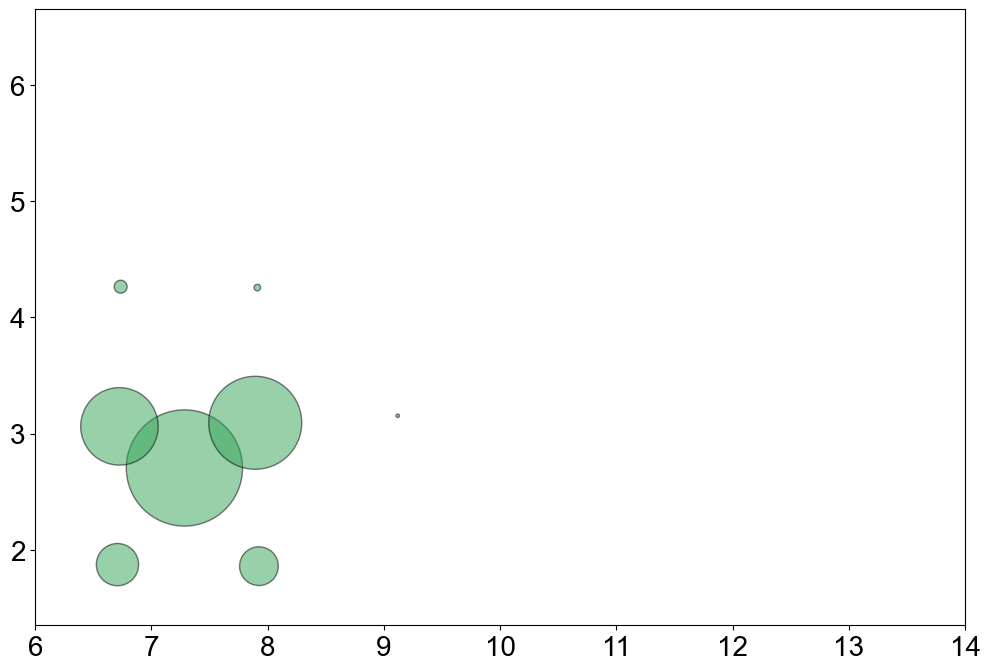

In [14]:

for af_type in ["SA"]:
    keep_legend = True
    for vf_tip_size in [3.61]:
        for t_of_f in [100,200,300,400,500, "peak"]:
            vf_model = VF_Population_Model(vf_tip_size= vf_tip_size,aff_type= af_type, scaling_factor= 1.0, density="Realistic")
            vf_model.radial_stress_vf_model(g = .2 if af_type == "SA" else .4, h = .5 if af_type == "SA" else .1)
            vf_model.run_single_unit_model_combined_graph(plot=False)
            vf_model.spatial_stress_vf_model(time_of_firing=t_of_f)
            vf_model.plot_spatial_coords(label=False)
            # if keep_legend:
            #     vf_model.plot_spatial_coords(label=True)
            #     keep_legend = False
            # else:
            #     vf_model.plot_spatial_coords(label=False)

Reading in data for Low density
plotting 7.62012 2.64159 0.25 1.0
plotting 5.52104 2.53415 0.1111111111111111 0.4444444444444444
plotting 8.49662 2.46603 0.14285714285714285 0.5714285714285714


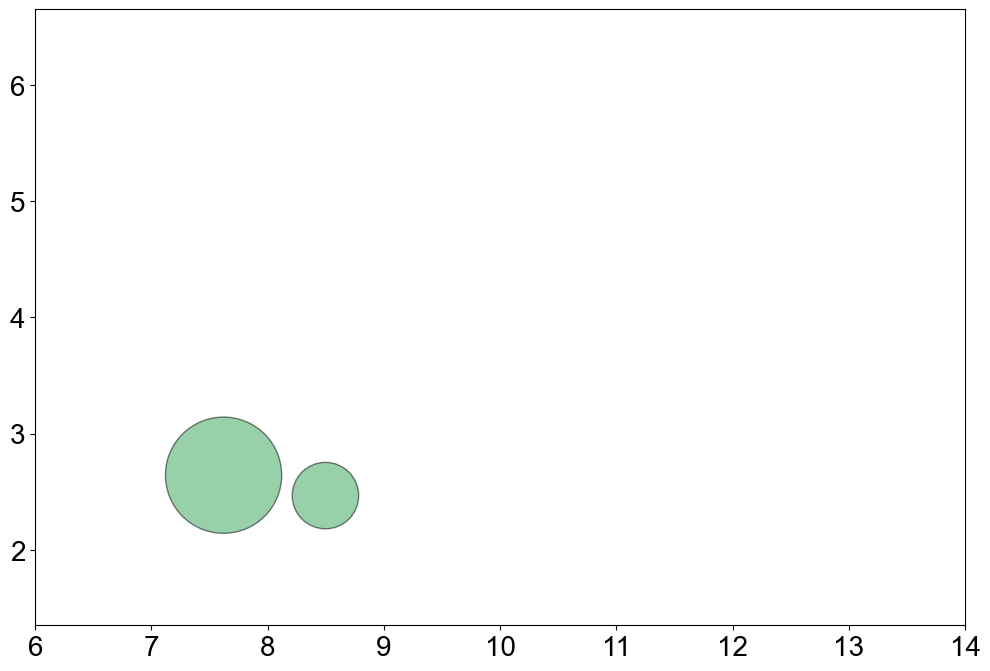

Reading in data for Low density
plotting 7.93266 4.6816 0.3333333333333333 1.0
plotting 5.46216 2.45279 0.01098901098901099 0.032967032967032975
plotting 8.49857 2.50772 0.007936507936507936 0.023809523809523808
plotting 5.44323 5.47563 0.047619047619047616 0.14285714285714285
plotting 8.4411 5.49109 0.2 0.6000000000000001


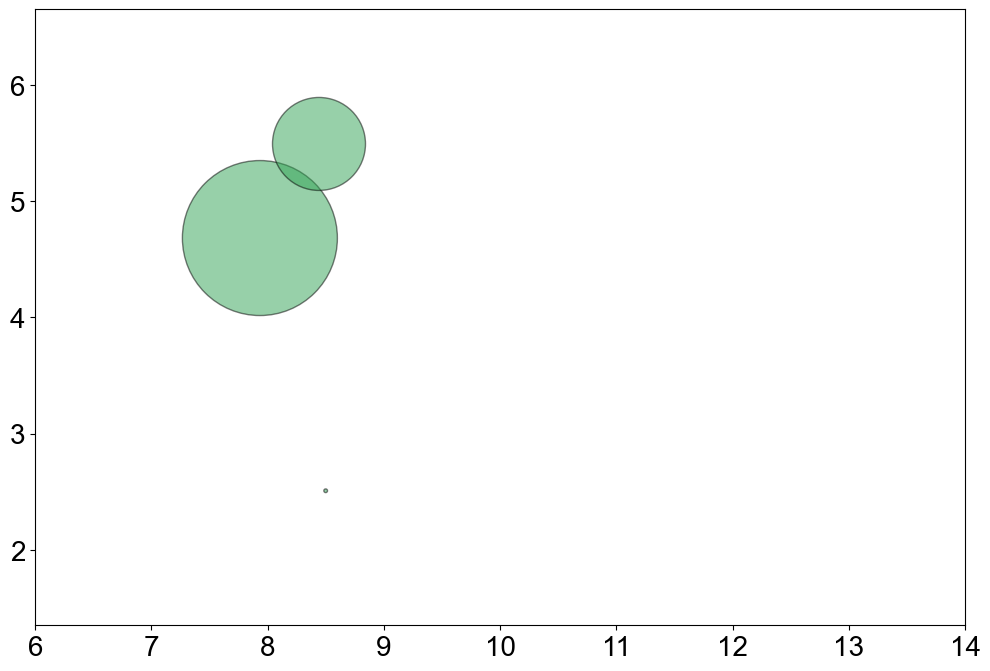

Reading in data for Low density
plotting 7.94645 6.44402 0.5 1.0
plotting 5.52779 5.4947 0.013333333333333334 0.02666666666666667
plotting 8.51027 5.44531 0.25 0.5
plotting 8.55564 8.53305 0.022727272727272728 0.045454545454545456


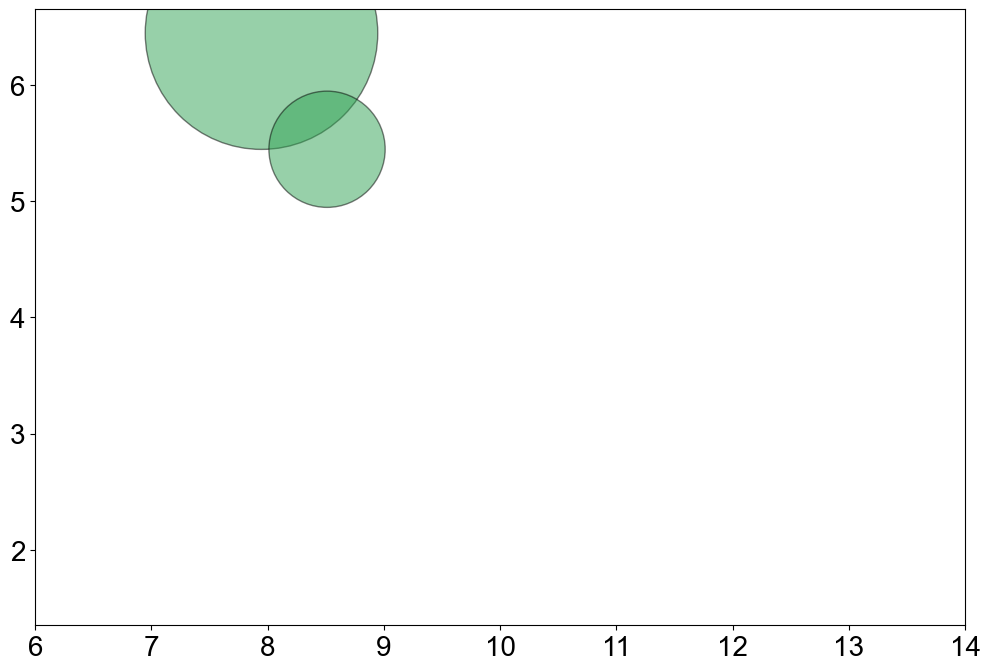

Reading in data for Low density
plotting 7.19751 3.10237 0.5 1.0
plotting 5.51548 2.49686 0.16666666666666666 0.3333333333333333
plotting 8.51201 2.54518 0.25 0.5


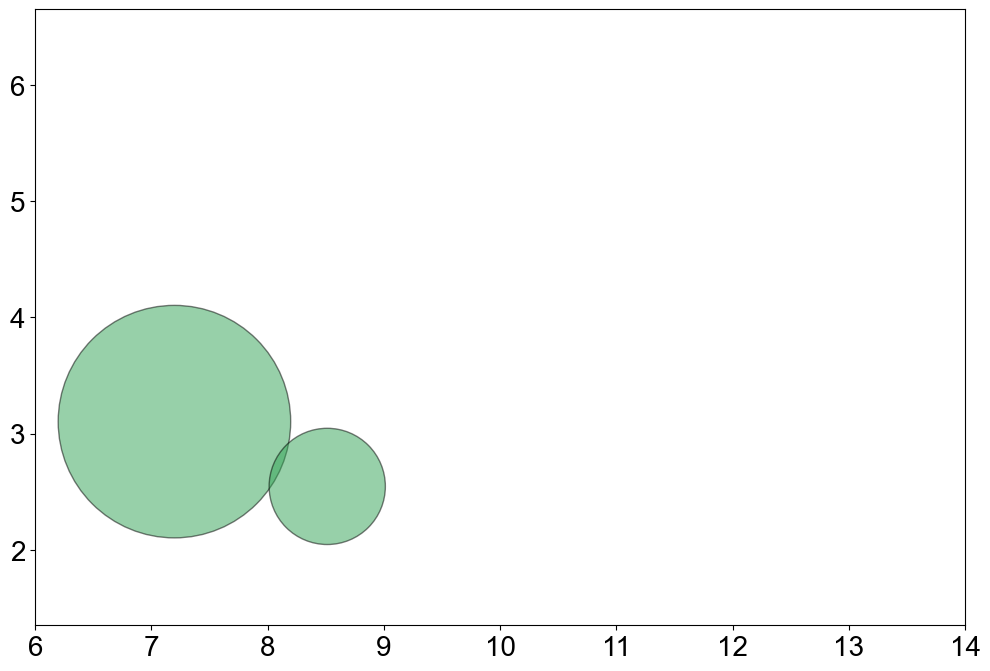

Reading in data for Low density
plotting 8.43014 4.23195 0.5 1.0
plotting 8.67169 2.39392 0.125 0.25
plotting 5.69895 5.39752 0.1111111111111111 0.2222222222222222
plotting 8.645 5.42587 0.25 0.5


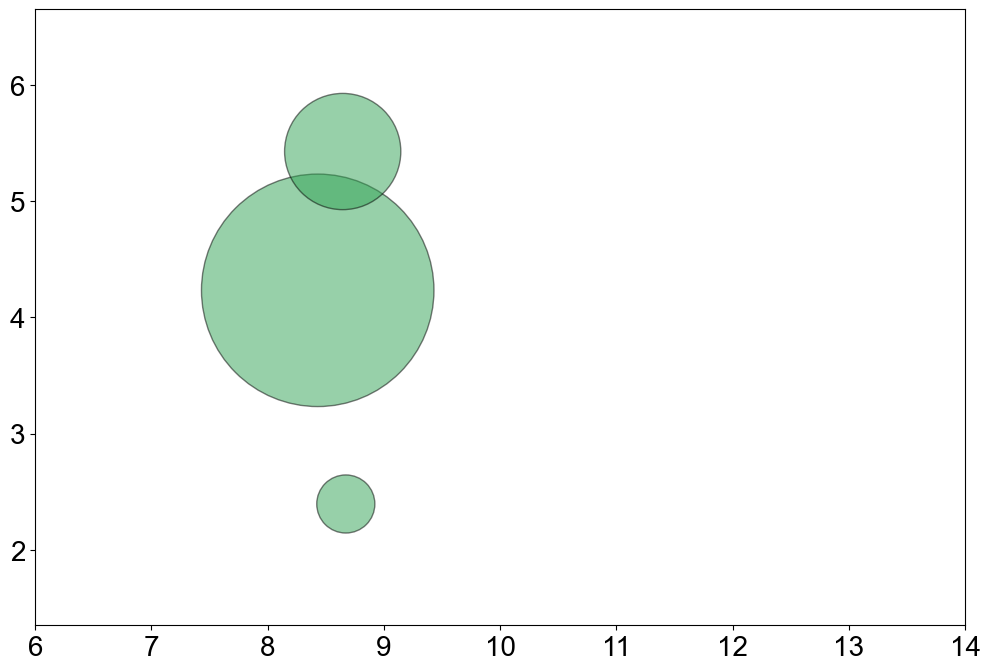

Reading in data for Low density
plotting 7.62012 2.64159 0.2 1.0
plotting 5.52104 2.53415 0.07692307692307693 0.38461538461538464
plotting 8.49662 2.46603 0.1 0.5


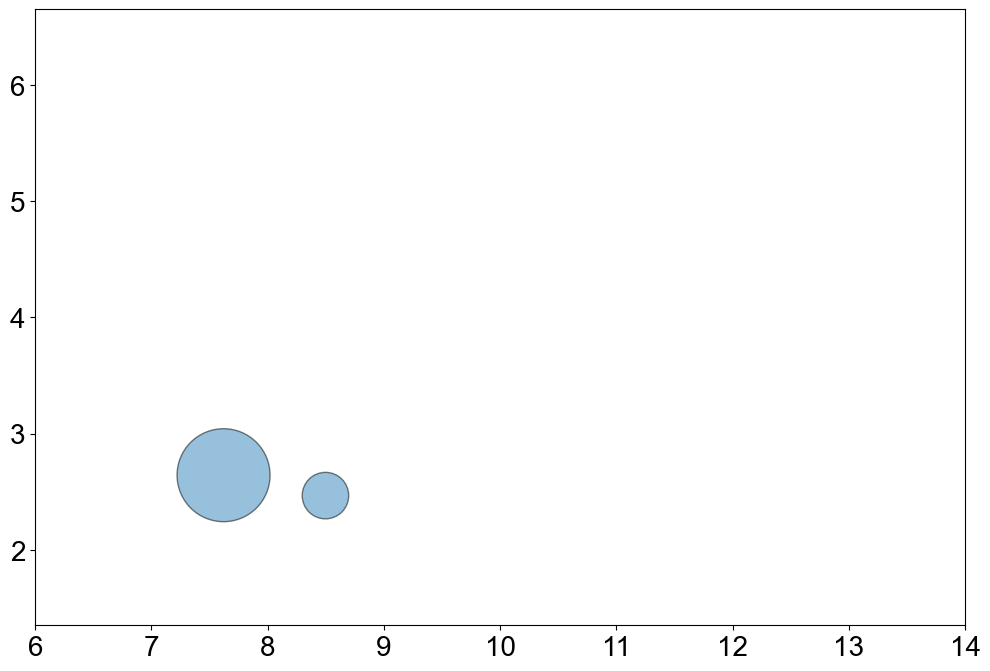

Reading in data for Low density
plotting 7.93266 4.6816 0.2 1.0
plotting 5.46216 2.45279 0.00024330900243309004 0.0012165450121654502
plotting 5.44323 5.47563 0.02857142857142857 0.14285714285714285
plotting 8.4411 5.49109 0.1111111111111111 0.5555555555555555


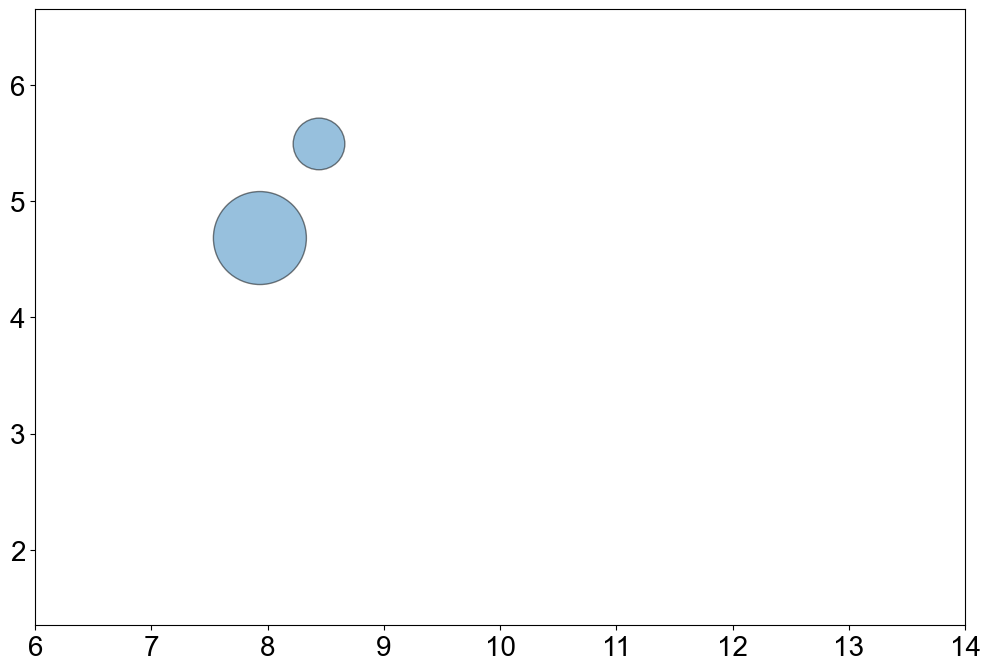

Reading in data for Low density
plotting 7.94645 6.44402 0.25 1.0
plotting 5.52779 5.4947 0.006329113924050633 0.02531645569620253
plotting 8.51027 5.44531 0.14285714285714285 0.5714285714285714
plotting 8.55564 8.53305 0.011764705882352941 0.047058823529411764


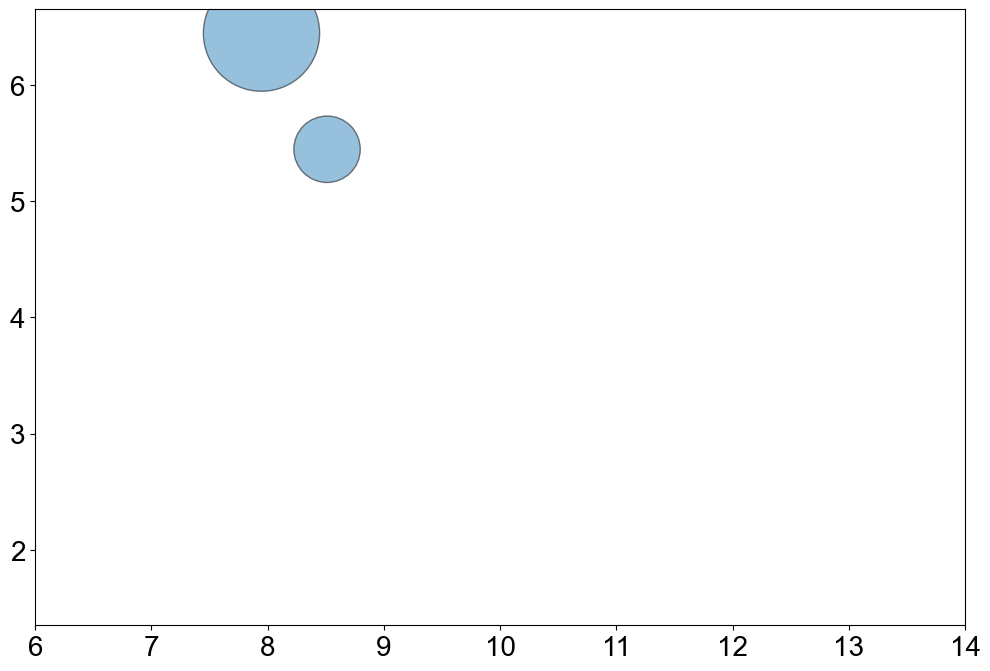

Reading in data for Low density
plotting 7.19751 3.10237 0.25 1.0
plotting 5.51548 2.49686 0.1111111111111111 0.4444444444444444
plotting 8.51201 2.54518 0.16666666666666666 0.6666666666666666


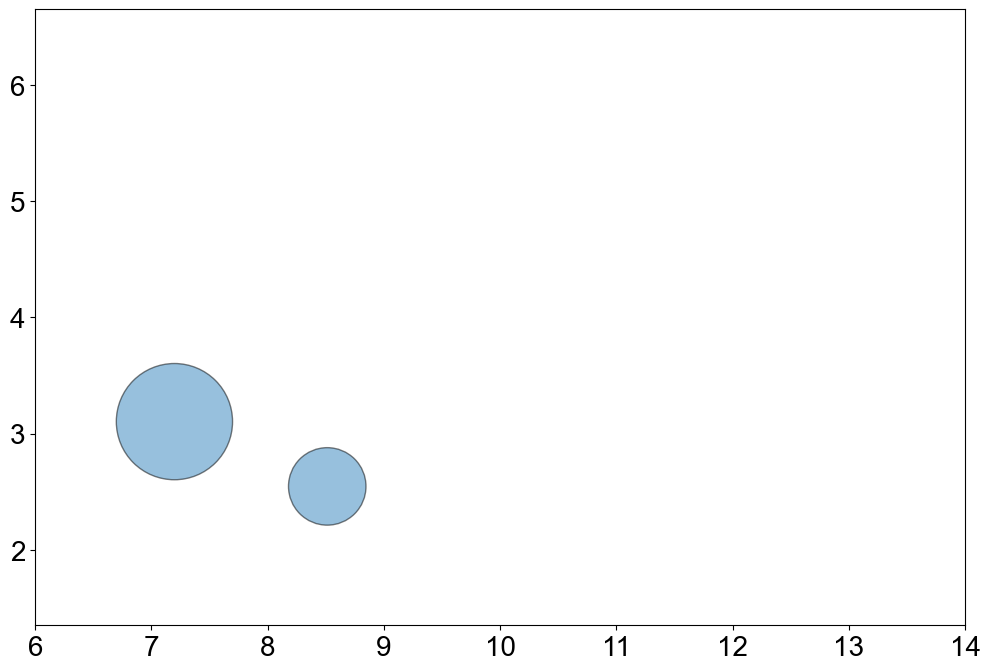

Reading in data for Low density
plotting 8.43014 4.23195 0.3333333333333333 1.0
plotting 8.67169 2.39392 0.08333333333333333 0.25
plotting 5.69895 5.39752 0.06666666666666667 0.2
plotting 8.645 5.42587 0.16666666666666666 0.5


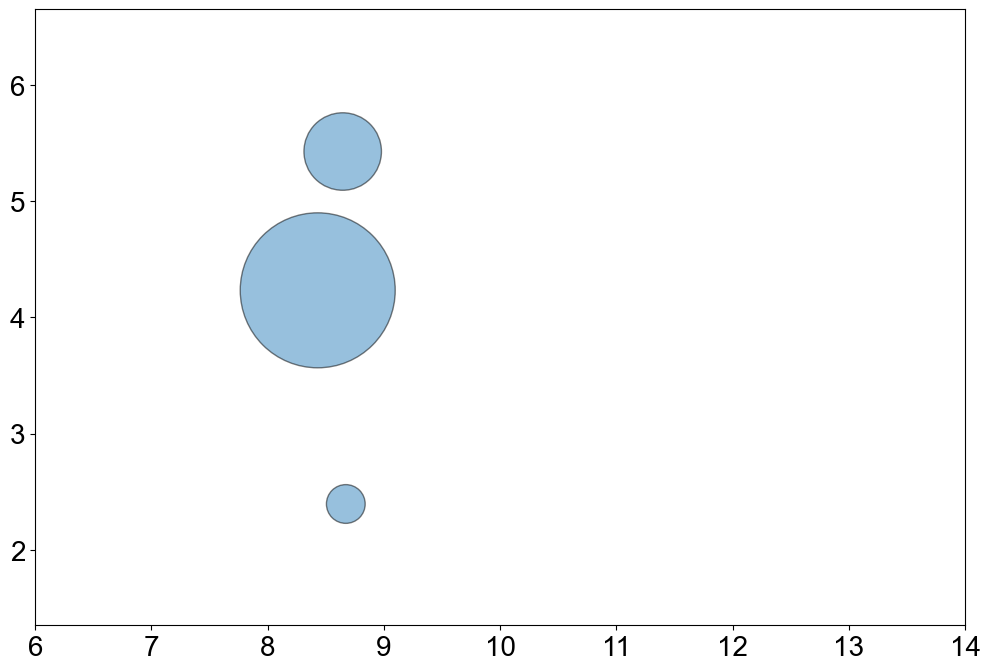

Reading in data for Med density
plotting 7.62012 2.64159 0.25 1.0
plotting 6.54037 1.25455 0.05 0.2
plotting 8.28751 1.27201 0.02857142857142857 0.11428571428571428
plotting 4.80289 2.95475 0.05555555555555555 0.2222222222222222
plotting 6.4627 3.00458 0.2 0.8
plotting 8.22329 3.02734 0.2 0.8
plotting 6.55808 4.68911 0.03571428571428571 0.14285714285714285


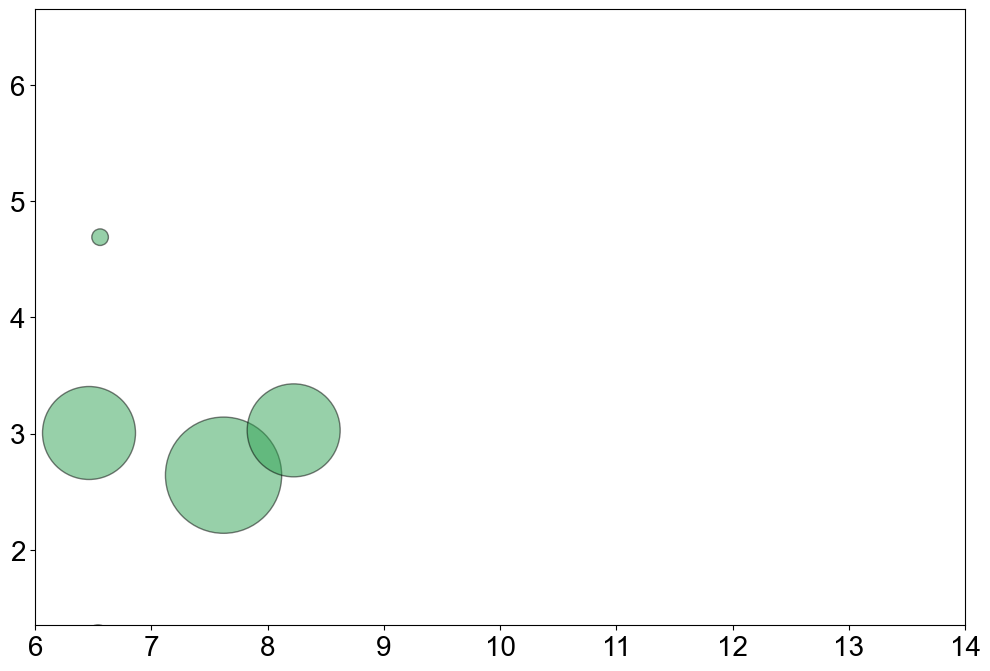

Reading in data for Med density
plotting 7.93266 4.6816 0.3333333333333333 1.0
plotting 4.80182 3.00646 0.0196078431372549 0.058823529411764705
plotting 6.45507 3.03085 0.07692307692307693 0.23076923076923078
plotting 8.23893 2.97545 0.08333333333333333 0.25
plotting 4.684 4.70671 0.024390243902439025 0.07317073170731708
plotting 6.4835 4.7056 0.2 0.6000000000000001
plotting 8.24246 4.78213 0.3333333333333333 1.0
plotting 9.9495 4.76981 0.06666666666666667 0.2
plotting 6.45697 6.49112 0.00024378352023403217 0.0007313505607020966
plotting 8.2495 6.49602 0.02857142857142857 0.08571428571428572


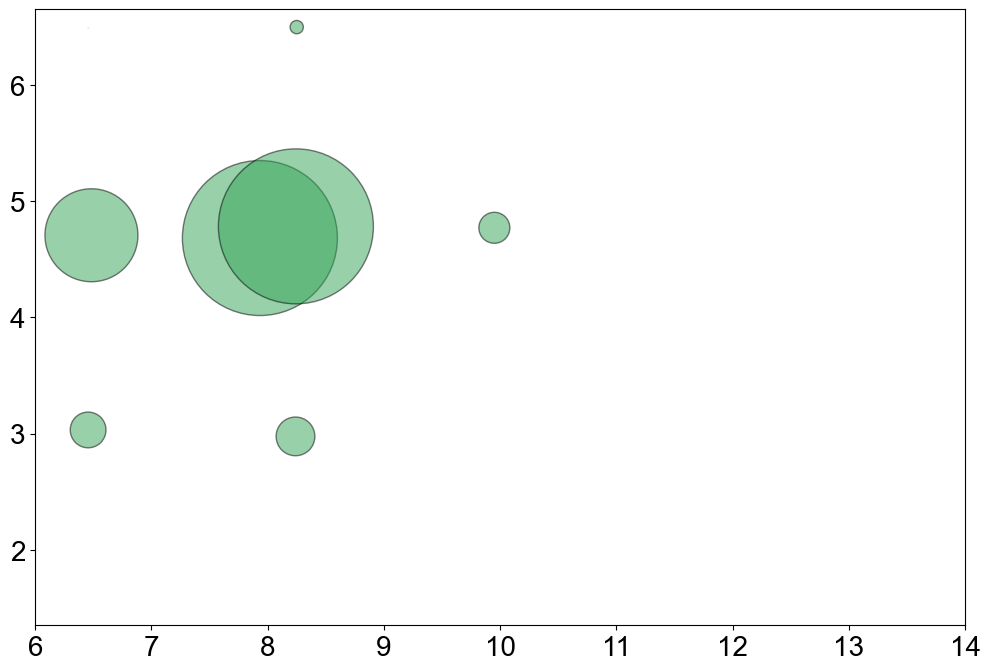

Reading in data for Med density
plotting 7.94645 6.44402 0.5 1.0
plotting 4.79653 4.74 0.03225806451612903 0.06451612903225806
plotting 6.50706 4.76667 0.125 0.25
plotting 8.28283 4.70886 0.14285714285714285 0.2857142857142857
plotting 10.0413 4.77071 0.058823529411764705 0.11764705882352941
plotting 4.71664 6.49192 0.05 0.1
plotting 6.50021 6.48889 0.25 0.5
plotting 8.29011 6.51748 0.3333333333333333 0.6666666666666666
plotting 10.0355 6.53192 0.16666666666666666 0.3333333333333333
plotting 11.7388 6.5319 0.012048192771084338 0.024096385542168676
plotting 8.19948 8.23918 0.09090909090909091 0.18181818181818182
plotting 9.99454 8.2793 0.0 0


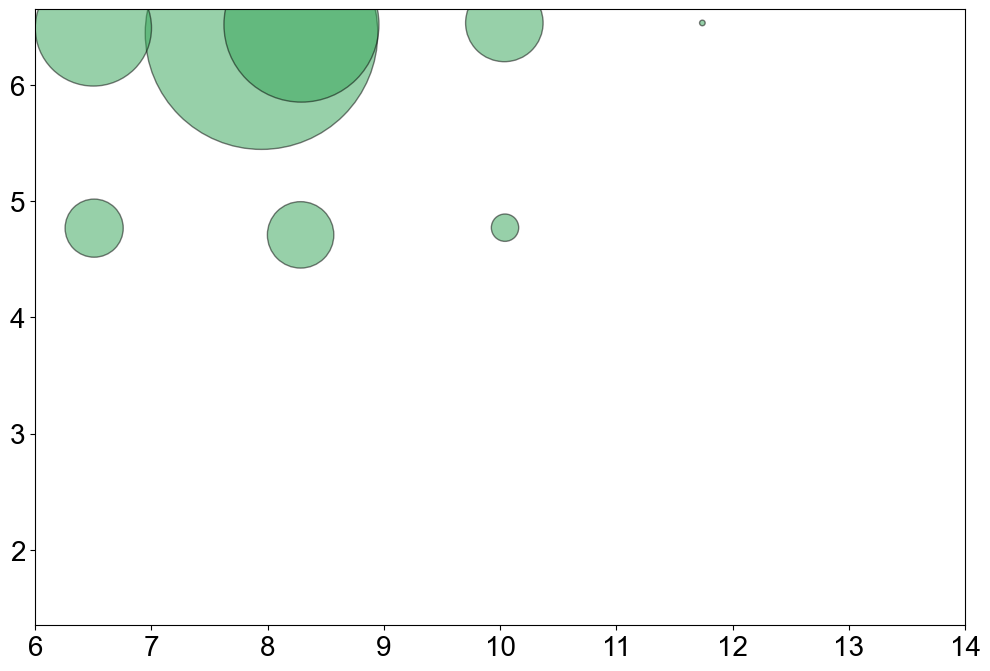

Reading in data for Med density
plotting 7.19751 3.10237 0.5 1.0
plotting 6.47137 1.2491 0.06666666666666667 0.13333333333333333
plotting 8.2382 1.28127 0.07692307692307693 0.15384615384615385
plotting 4.82124 2.97742 0.1 0.2
plotting 6.55387 2.99519 0.3333333333333333 0.6666666666666666
plotting 8.25873 2.99353 0.25 0.5
plotting 9.97105 2.96623 0.01639344262295082 0.03278688524590164
plotting 4.79485 4.773 0.058823529411764705 0.11764705882352941
plotting 6.4971 4.79322 0.125 0.25
plotting 8.24877 4.76596 0.07692307692307693 0.15384615384615385


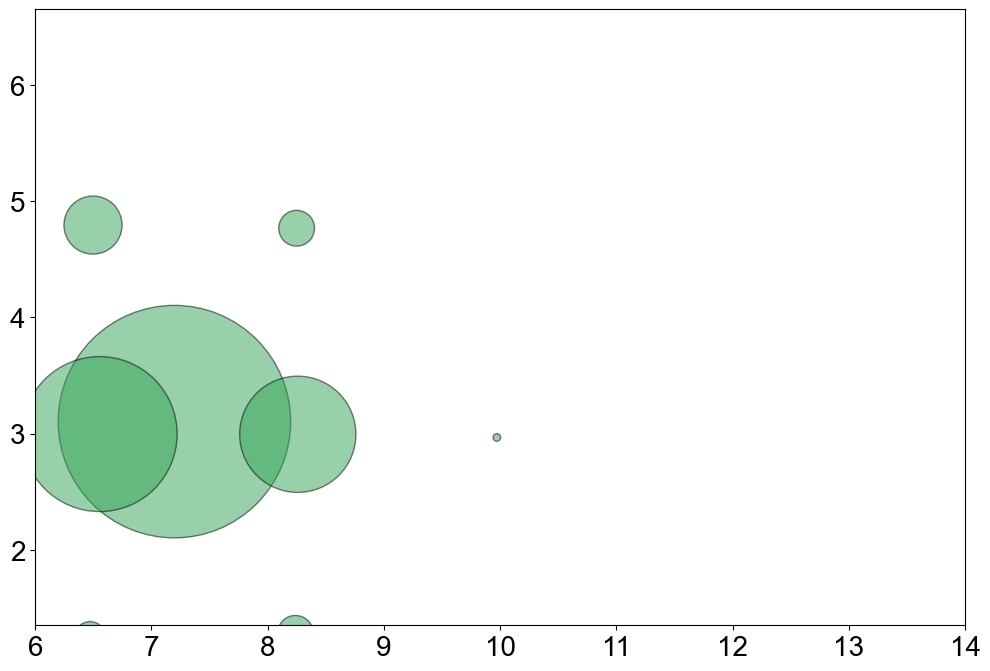

Reading in data for Med density
plotting 8.43014 4.23195 0.5 1.0
plotting 6.68924 2.9413 0.125 0.25
plotting 8.39634 2.96338 0.25 0.5
plotting 10.1359 2.92532 0.125 0.25
plotting 4.91304 4.67608 0.07692307692307693 0.15384615384615385
plotting 6.73923 4.68586 0.25 0.5
plotting 8.45458 4.69988 0.3333333333333333 0.6666666666666666
plotting 10.1773 4.74275 0.2 0.4
plotting 6.74423 6.4771 0.05 0.1
plotting 8.3891 6.45934 0.08333333333333333 0.16666666666666666


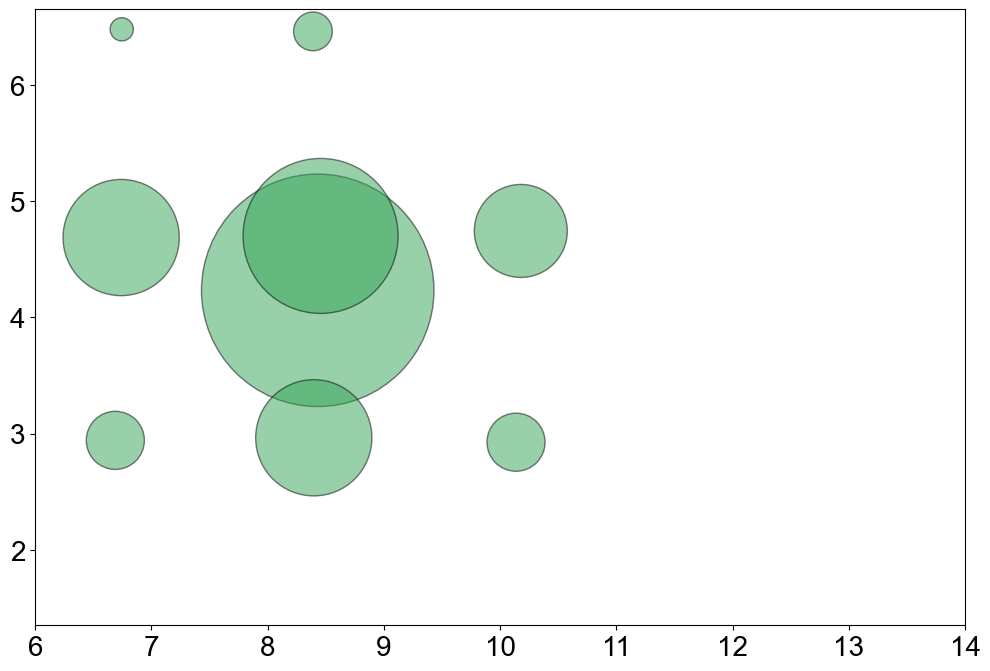

Reading in data for Med density
plotting 7.62012 2.64159 0.2 1.0
plotting 6.54037 1.25455 0.030303030303030304 0.15151515151515152
plotting 8.28751 1.27201 0.017241379310344827 0.08620689655172413
plotting 4.80289 2.95475 0.034482758620689655 0.17241379310344826
plotting 6.4627 3.00458 0.14285714285714285 0.7142857142857142
plotting 8.22329 3.02734 0.14285714285714285 0.7142857142857142
plotting 6.55808 4.68911 0.021739130434782608 0.10869565217391304


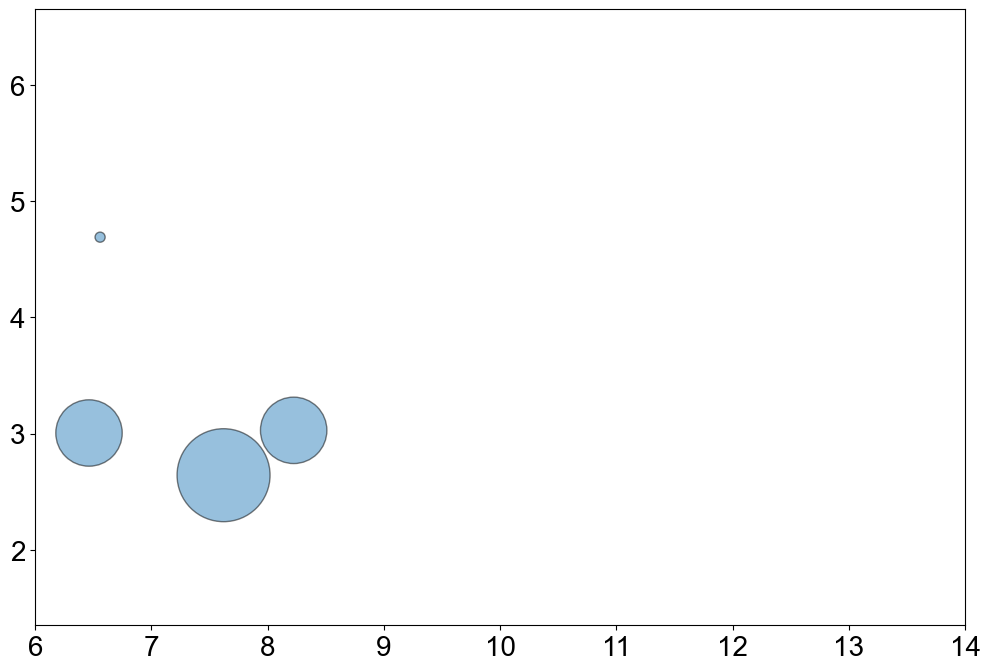

Reading in data for Med density
plotting 7.93266 4.6816 0.2 1.0
plotting 4.80182 3.00646 0.010752688172043012 0.053763440860215055
plotting 6.45507 3.03085 0.047619047619047616 0.23809523809523808
plotting 8.23893 2.97545 0.05263157894736842 0.2631578947368421
plotting 4.684 4.70671 0.014084507042253521 0.07042253521126761
plotting 6.4835 4.7056 0.125 0.625
plotting 8.24246 4.78213 0.2 1.0
plotting 9.9495 4.76981 0.04 0.19999999999999998
plotting 8.2495 6.49602 0.01639344262295082 0.08196721311475409


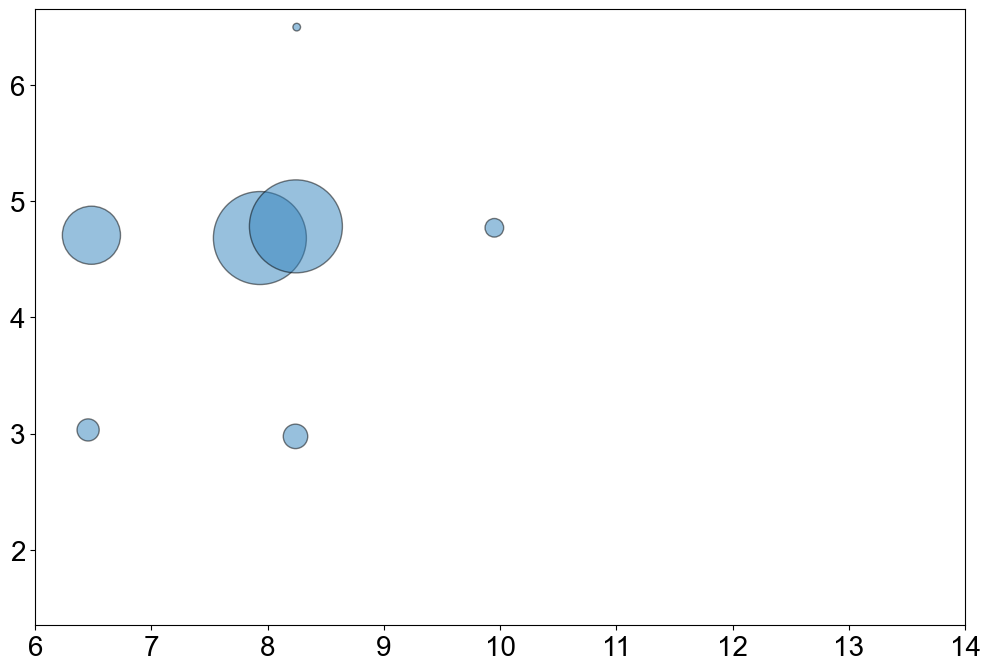

Reading in data for Med density
plotting 7.94645 6.44402 0.25 1.0
plotting 4.79653 4.74 0.017543859649122806 0.07017543859649122
plotting 6.50706 4.76667 0.07692307692307693 0.3076923076923077
plotting 8.28283 4.70886 0.09090909090909091 0.36363636363636365
plotting 10.0413 4.77071 0.034482758620689655 0.13793103448275862
plotting 4.71664 6.49192 0.027777777777777776 0.1111111111111111
plotting 6.50021 6.48889 0.14285714285714285 0.5714285714285714
plotting 8.29011 6.51748 0.25 1.0
plotting 10.0355 6.53192 0.09090909090909091 0.36363636363636365
plotting 11.7388 6.5319 0.0055248618784530384 0.022099447513812154
plotting 8.19948 8.23918 0.05 0.2


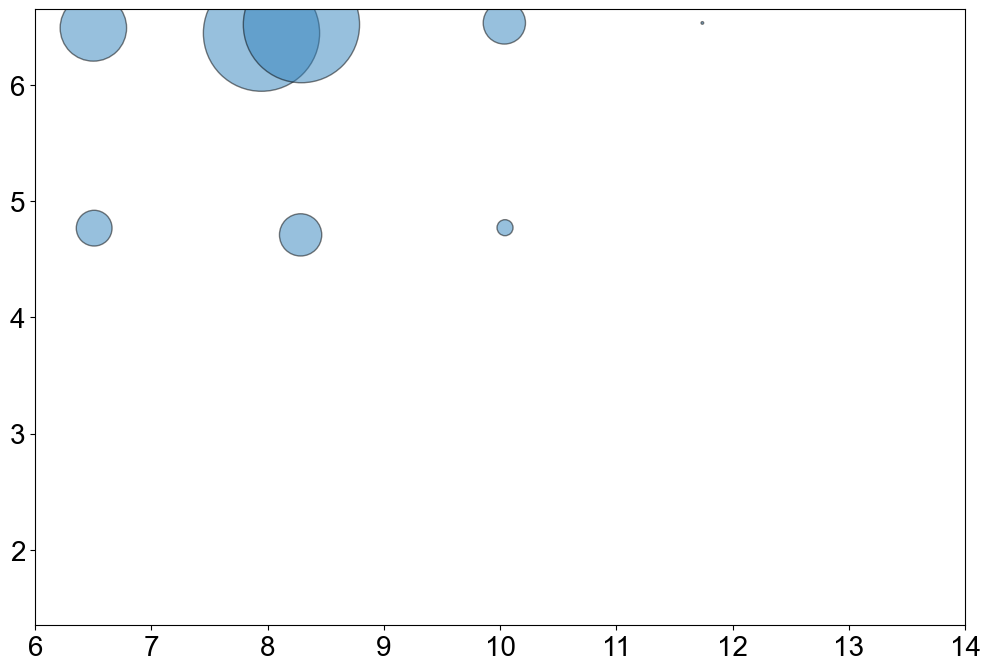

Reading in data for Med density
plotting 7.19751 3.10237 0.25 1.0
plotting 6.47137 1.2491 0.041666666666666664 0.16666666666666666
plotting 8.2382 1.28127 0.05 0.2
plotting 4.82124 2.97742 0.06666666666666667 0.26666666666666666
plotting 6.55387 2.99519 0.25 1.0
plotting 8.25873 2.99353 0.2 0.8
plotting 9.97105 2.96623 0.008849557522123894 0.035398230088495575
plotting 4.79485 4.773 0.03571428571428571 0.14285714285714285
plotting 6.4971 4.79322 0.08333333333333333 0.3333333333333333
plotting 8.24877 4.76596 0.05 0.2


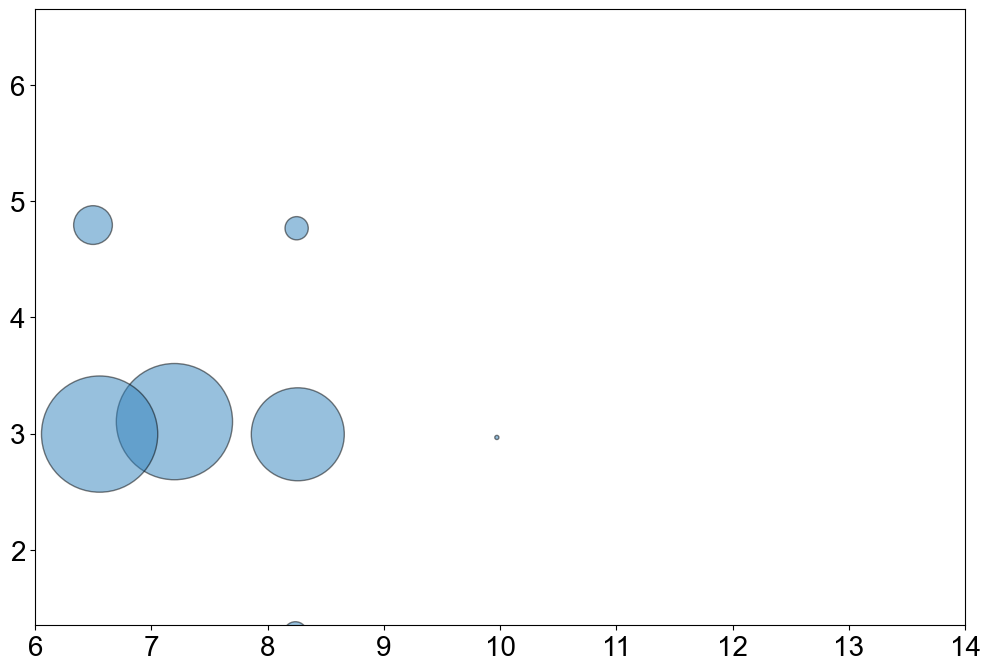

Reading in data for Med density
plotting 8.43014 4.23195 0.3333333333333333 1.0
plotting 6.68924 2.9413 0.07692307692307693 0.23076923076923078
plotting 8.39634 2.96338 0.14285714285714285 0.42857142857142855
plotting 10.1359 2.92532 0.08333333333333333 0.25
plotting 4.91304 4.67608 0.05 0.15000000000000002
plotting 6.73923 4.68586 0.16666666666666666 0.5
plotting 8.45458 4.69988 0.25 0.75
plotting 10.1773 4.74275 0.125 0.375
plotting 6.74423 6.4771 0.030303030303030304 0.09090909090909091
plotting 8.3891 6.45934 0.05263157894736842 0.15789473684210525


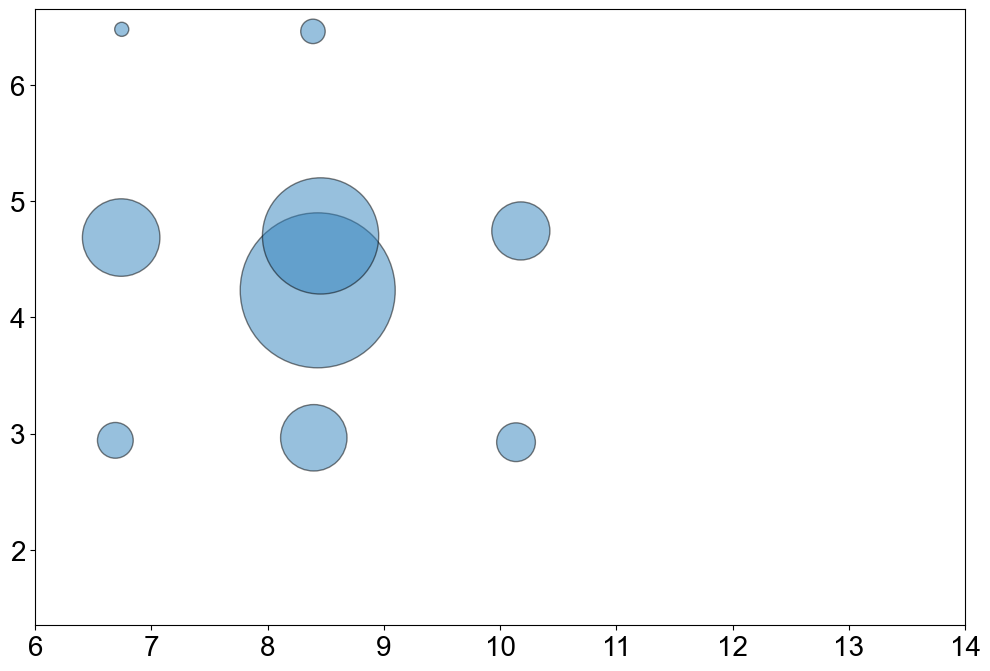

Reading in data for High density
plotting 7.62012 2.64159 0.25 0.75
plotting 5.98079 1.45272 0.043478260869565216 0.13043478260869565
plotting 6.5207 1.47504 0.08333333333333333 0.25
plotting 7.03821 1.49462 0.1111111111111111 0.3333333333333333
plotting 7.54805 1.51331 0.1111111111111111 0.3333333333333333
plotting 8.03687 1.52799 0.09090909090909091 0.27272727272727276
plotting 8.51003 1.54147 0.05 0.15000000000000002
plotting 5.48232 1.97453 0.045454545454545456 0.13636363636363638
plotting 6.0086 1.99269 0.1 0.30000000000000004
plotting 6.52094 2.01074 0.16666666666666666 0.5
plotting 7.01865 2.02869 0.2 0.6000000000000001
plotting 7.51464 2.04114 0.25 0.75
plotting 7.9601 1.95566 0.16666666666666666 0.5
plotting 8.5433 1.94604 0.09090909090909091 0.27272727272727276
plotting 9.00266 1.95679 0.029411764705882353 0.08823529411764706
plotting 4.99441 2.49972 0.037037037037037035 0.1111111111111111
plotting 5.52104 2.53415 0.1111111111111111 0.3333333333333333
plotting 5.97305 2.42832

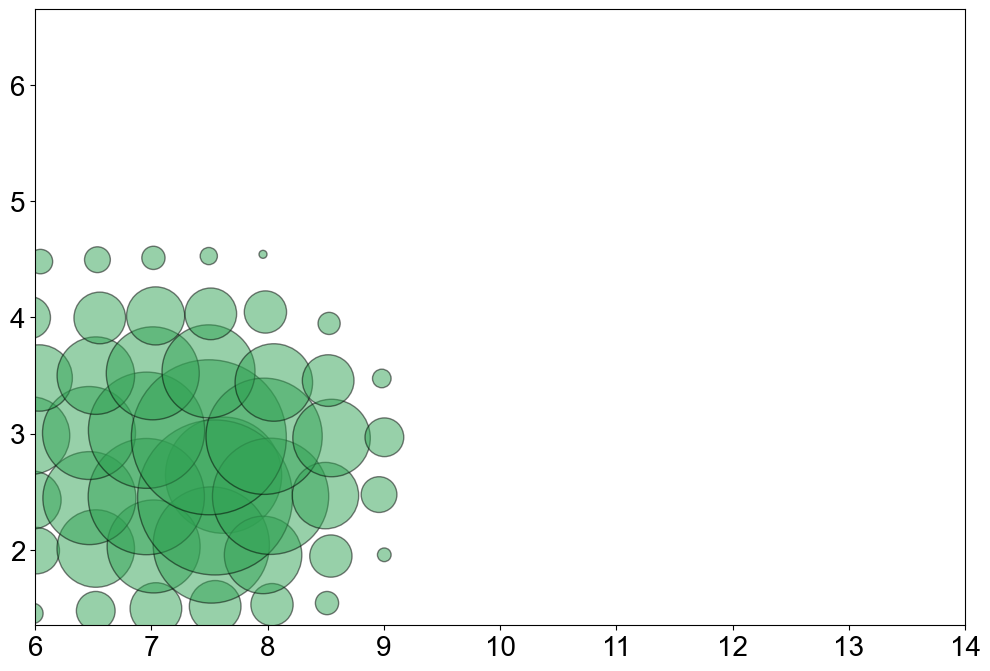

Reading in data for High density
plotting 7.93266 4.6816 0.3333333333333333 1.0
plotting 5.46216 2.45279 0.01098901098901099 0.032967032967032975
plotting 5.97036 2.49433 0.022222222222222223 0.06666666666666668
plotting 6.46537 2.53412 0.03571428571428571 0.10714285714285714
plotting 6.95417 2.47433 0.03571428571428571 0.10714285714285714
plotting 7.44011 2.51521 0.037037037037037035 0.1111111111111111
plotting 8.03575 2.46706 0.021739130434782608 0.06521739130434782
plotting 8.49857 2.50772 0.007936507936507936 0.023809523809523808
plotting 4.53133 2.98558 0.009523809523809525 0.028571428571428574
plotting 4.93662 3.01585 0.022727272727272728 0.06818181818181819
plotting 5.46985 2.95435 0.03571428571428571 0.10714285714285714
plotting 5.96329 2.99194 0.058823529411764705 0.17647058823529413
plotting 6.45507 3.03085 0.07692307692307693 0.23076923076923078
plotting 7.05727 2.97939 0.09090909090909091 0.27272727272727276
plotting 7.53157 3.01628 0.1 0.30000000000000004
plotting 8.00908 

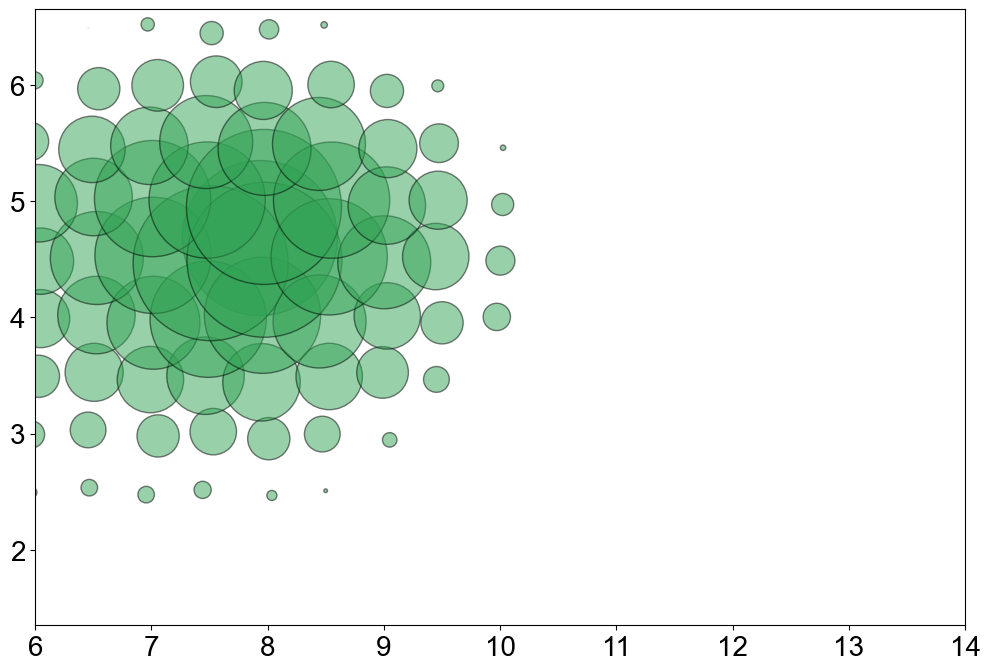

Reading in data for High density
plotting 7.94645 6.44402 0.5 1.0
plotting 7.03214 3.54011 0.008 0.016
plotting 7.53995 3.43975 0.011904761904761904 0.023809523809523808
plotting 8.02003 3.53891 0.022727272727272728 0.045454545454545456
plotting 8.50202 3.53912 0.00819672131147541 0.01639344262295082
plotting 4.56383 3.97478 0.01 0.02
plotting 5.47307 3.94841 0.011904761904761904 0.023809523809523808
plotting 6.04243 3.95618 0.03225806451612903 0.06451612903225806
plotting 6.45622 3.93996 0.045454545454545456 0.09090909090909091
plotting 6.98467 3.94454 0.05263157894736842 0.10526315789473684
plotting 7.49138 3.94266 0.0625 0.125
plotting 7.97418 3.94004 0.06666666666666667 0.13333333333333333
plotting 8.57099 3.96121 0.058823529411764705 0.11764705882352941
plotting 9.04796 3.95753 0.041666666666666664 0.08333333333333333
plotting 9.5183 3.95537 0.023255813953488372 0.046511627906976744
plotting 16.0046 4.05861 0.015384615384615385 0.03076923076923077
plotting 16.0046 4.05861 0.015384

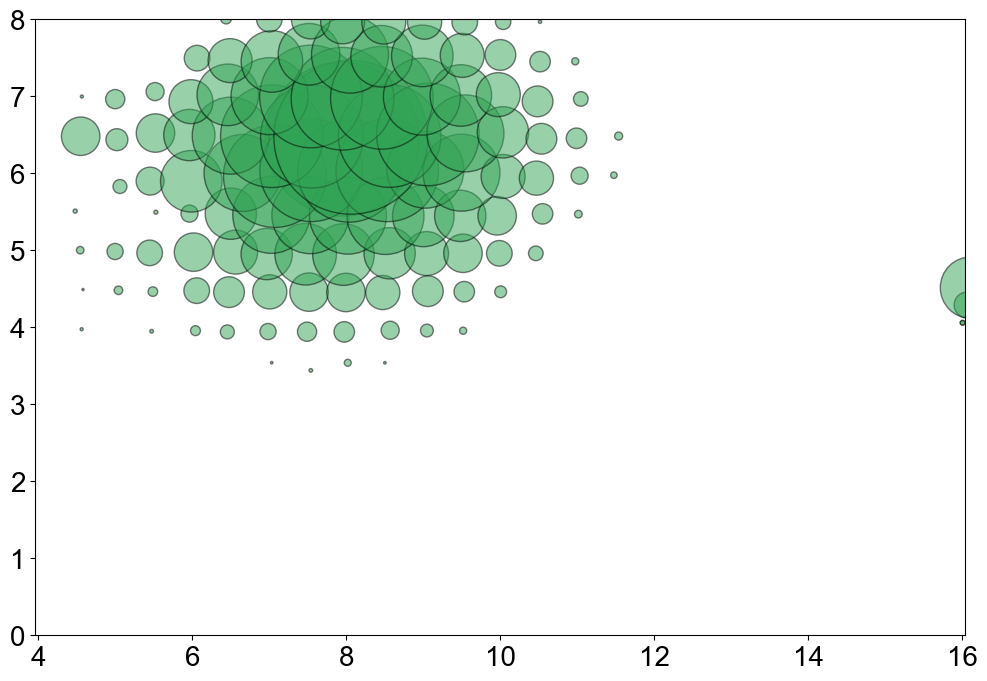

Reading in data for High density
plotting 7.19751 3.10237 0.5 1.0
plotting 6.99575 0.966976 0.02127659574468085 0.0425531914893617
plotting 7.53588 0.91562 0.008333333333333333 0.016666666666666666
plotting 8.03103 0.995941 0.022222222222222223 0.044444444444444446
plotting 5.51817 1.543 0.03125 0.0625
plotting 6.06522 1.49393 0.09090909090909091 0.18181818181818182
plotting 6.49342 1.48141 0.125 0.25
plotting 7.04148 1.43071 0.14285714285714285 0.2857142857142857
plotting 7.53436 1.50925 0.16666666666666666 0.3333333333333333
plotting 8.06989 1.45111 0.125 0.25
plotting 8.55227 1.52512 0.1 0.2
plotting 8.96602 1.50685 0.06666666666666667 0.13333333333333333
plotting 4.97972 1.96238 0.02857142857142857 0.05714285714285714
plotting 5.57849 2.00656 0.125 0.25
plotting 5.99055 1.99529 0.2 0.4
plotting 6.53132 1.94411 0.25 0.5
plotting 7.02157 2.02525 0.25 0.5
plotting 7.56009 1.9698 0.25 0.5
plotting 7.97839 1.94576 0.25 0.5
plotting 8.56865 1.97214 0.16666666666666666 0.3333333333333333


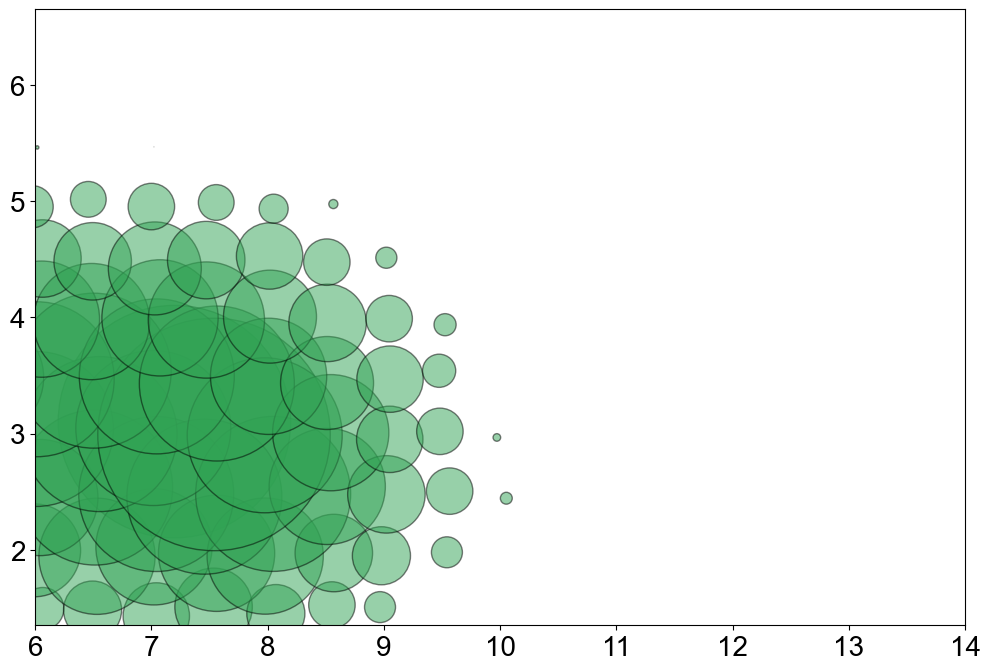

Reading in data for High density
plotting 8.43014 4.23195 0.5 1.0
plotting 7.68628 1.96196 0.029411764705882353 0.058823529411764705
plotting 8.18562 1.90585 0.03333333333333333 0.06666666666666667
plotting 8.7308 1.95261 0.041666666666666664 0.08333333333333333
plotting 9.21706 1.89312 0.010526315789473684 0.021052631578947368
plotting 6.69489 2.39822 0.043478260869565216 0.08695652173913043
plotting 7.12897 2.46111 0.09090909090909091 0.18181818181818182
plotting 7.67966 2.50958 0.125 0.25
plotting 8.17752 2.451 0.14285714285714285 0.2857142857142857
plotting 8.67169 2.39392 0.125 0.25
plotting 9.20902 2.43793 0.125 0.25
plotting 9.73165 2.47288 0.1 0.2
plotting 10.1919 2.40529 0.047619047619047616 0.09523809523809523
plotting 5.20189 2.97892 0.05555555555555555 0.1111111111111111
plotting 6.18597 2.99848 0.07142857142857142 0.14285714285714285
plotting 6.68924 2.9413 0.125 0.25
plotting 7.19238 2.88743 0.16666666666666666 0.3333333333333333
plotting 7.61656 2.94856 0.2 0.4
plotting 

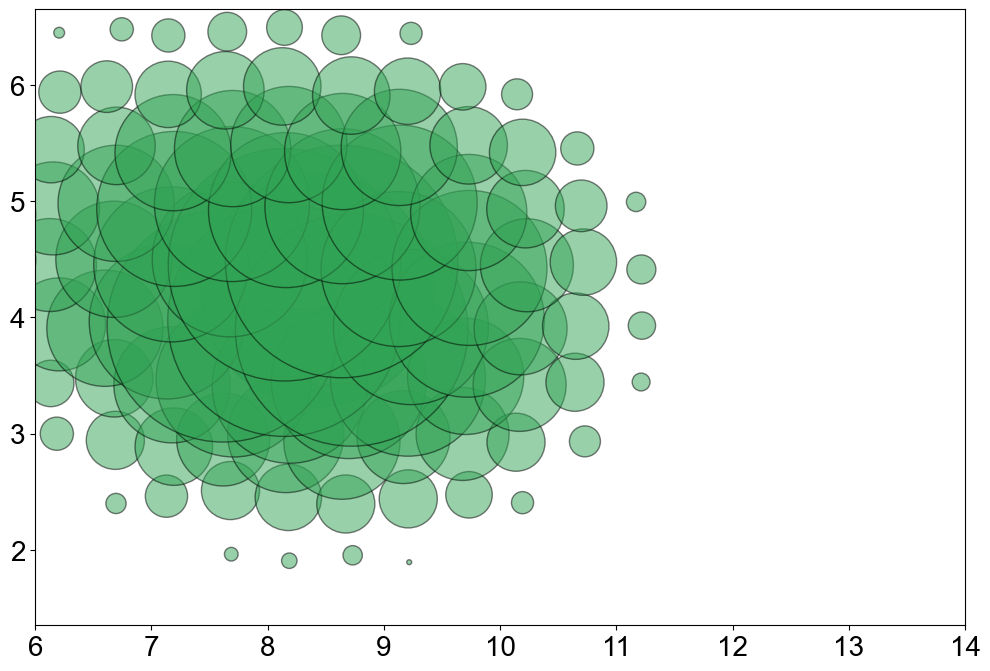

Reading in data for High density
plotting 7.62012 2.64159 0.2 1.0
plotting 5.98079 1.45272 0.02702702702702703 0.13513513513513514
plotting 6.5207 1.47504 0.05555555555555555 0.27777777777777773
plotting 7.03821 1.49462 0.07142857142857142 0.3571428571428571
plotting 7.54805 1.51331 0.07142857142857142 0.3571428571428571
plotting 8.03687 1.52799 0.0625 0.3125
plotting 8.51003 1.54147 0.03125 0.15625
plotting 5.48232 1.97453 0.02857142857142857 0.14285714285714285
plotting 6.0086 1.99269 0.06666666666666667 0.3333333333333333
plotting 6.52094 2.01074 0.1 0.5
plotting 7.01865 2.02869 0.14285714285714285 0.7142857142857142
plotting 7.51464 2.04114 0.14285714285714285 0.7142857142857142
plotting 7.9601 1.95566 0.1111111111111111 0.5555555555555555
plotting 8.5433 1.94604 0.058823529411764705 0.2941176470588235
plotting 9.00266 1.95679 0.01818181818181818 0.0909090909090909
plotting 4.99441 2.49972 0.022727272727272728 0.11363636363636363
plotting 5.52104 2.53415 0.07692307692307693 0.38461

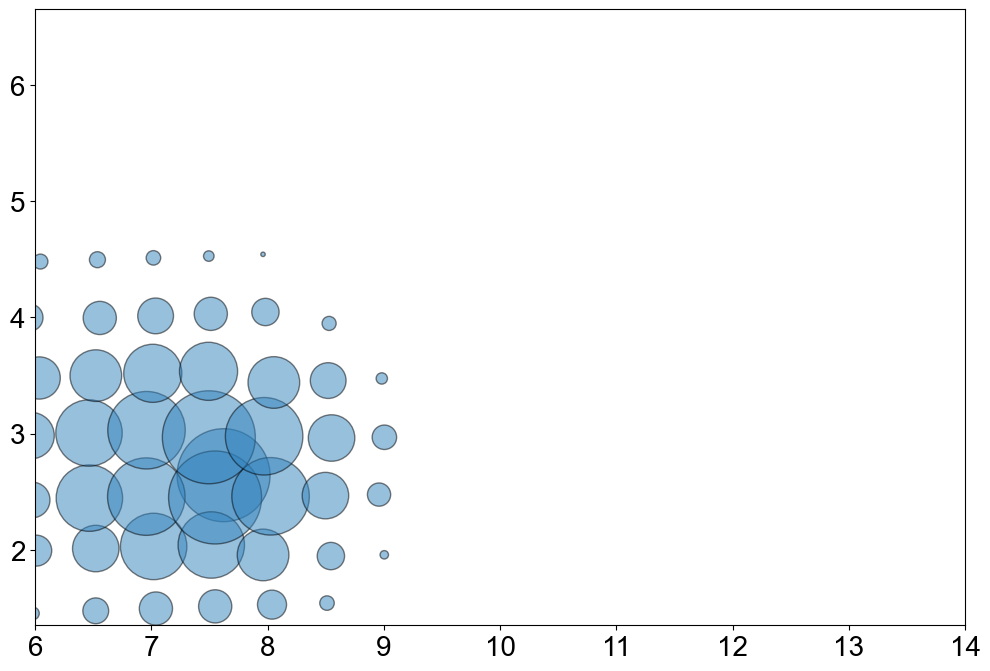

Reading in data for High density
plotting 7.93266 4.6816 0.2 1.0
plotting 5.46216 2.45279 0.00024330900243309004 0.0012165450121654502
plotting 5.97036 2.49433 0.011904761904761904 0.05952380952380952
plotting 6.46537 2.53412 0.02127659574468085 0.10638297872340424
plotting 6.95417 2.47433 0.02127659574468085 0.10638297872340424
plotting 7.44011 2.51521 0.021739130434782608 0.10869565217391304
plotting 8.03575 2.46706 0.011627906976744186 0.05813953488372093
plotting 4.53133 2.98558 0.0002447980416156671 0.0012239902080783353
plotting 4.93662 3.01585 0.01282051282051282 0.0641025641025641
plotting 5.46985 2.95435 0.02127659574468085 0.10638297872340424
plotting 5.96329 2.99194 0.03571428571428571 0.17857142857142855
plotting 6.45507 3.03085 0.047619047619047616 0.23809523809523808
plotting 7.05727 2.97939 0.05555555555555555 0.27777777777777773
plotting 7.53157 3.01628 0.058823529411764705 0.2941176470588235
plotting 8.00908 2.95568 0.05555555555555555 0.27777777777777773
plotting 8.46

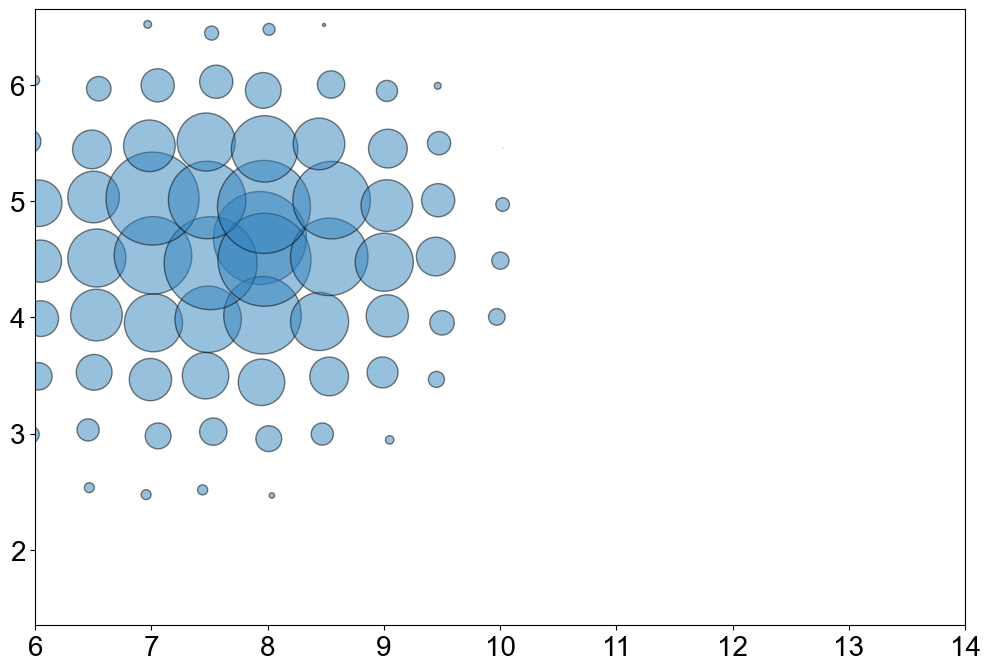

Reading in data for High density
plotting 7.94645 6.44402 0.25 1.0
plotting 7.03214 3.54011 0.0 0
plotting 7.53995 3.43975 0.00023557126030624264 0.0009422850412249705
plotting 8.02003 3.53891 0.012048192771084338 0.04819277108433735
plotting 8.50202 3.53912 0.0 0
plotting 4.56383 3.97478 0.00023452157598499062 0.0009380863039399625
plotting 5.47307 3.94841 0.00023557126030624264 0.0009422850412249705
plotting 6.04243 3.95618 0.017543859649122806 0.07017543859649122
plotting 6.45622 3.93996 0.02564102564102564 0.10256410256410256
plotting 6.98467 3.94454 0.029411764705882353 0.11764705882352941
plotting 7.49138 3.94266 0.034482758620689655 0.13793103448275862
plotting 7.97418 3.94004 0.037037037037037035 0.14814814814814814
plotting 8.57099 3.96121 0.03333333333333333 0.13333333333333333
plotting 9.04796 3.95753 0.023809523809523808 0.09523809523809523
plotting 9.5183 3.95537 0.012195121951219513 0.04878048780487805
plotting 16.0046 4.05861 0.007407407407407408 0.02962962962962963
plot

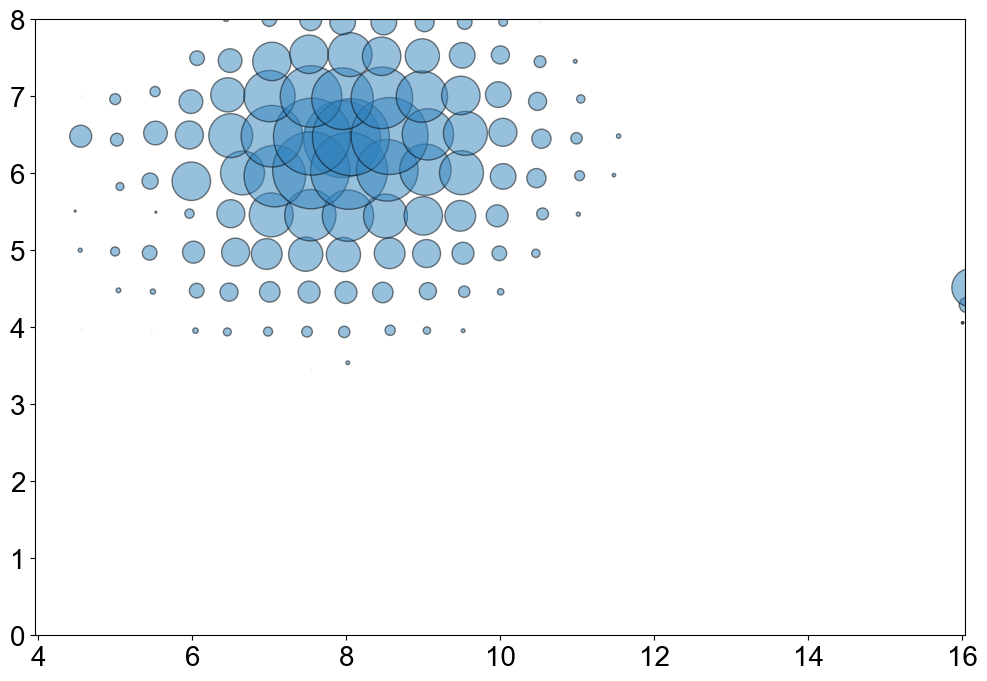

Reading in data for High density
plotting 7.19751 3.10237 0.25 1.0
plotting 6.99575 0.966976 0.012345679012345678 0.04938271604938271
plotting 7.53588 0.91562 0.0 0
plotting 8.03103 0.995941 0.012987012987012988 0.05194805194805195
plotting 5.51817 1.543 0.019230769230769232 0.07692307692307693
plotting 6.06522 1.49393 0.058823529411764705 0.23529411764705882
plotting 6.49342 1.48141 0.08333333333333333 0.3333333333333333
plotting 7.04148 1.43071 0.09090909090909091 0.36363636363636365
plotting 7.53436 1.50925 0.1 0.4
plotting 8.06989 1.45111 0.07692307692307693 0.3076923076923077
plotting 8.55227 1.52512 0.06666666666666667 0.26666666666666666
plotting 8.96602 1.50685 0.041666666666666664 0.16666666666666666
plotting 4.97972 1.96238 0.01694915254237288 0.06779661016949153
plotting 5.57849 2.00656 0.08333333333333333 0.3333333333333333
plotting 5.99055 1.99529 0.125 0.5
plotting 6.53132 1.94411 0.14285714285714285 0.5714285714285714
plotting 7.02157 2.02525 0.16666666666666666 0.666666

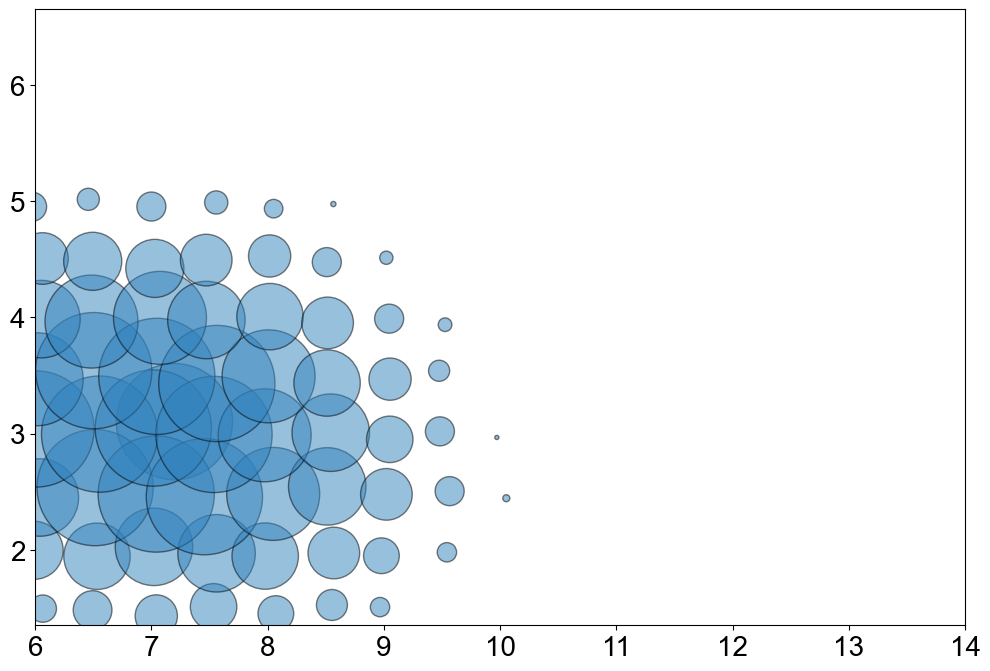

Reading in data for High density
plotting 8.43014 4.23195 0.3333333333333333 1.0
plotting 7.68628 1.96196 0.017241379310344827 0.05172413793103448
plotting 8.18562 1.90585 0.0196078431372549 0.058823529411764705
plotting 8.7308 1.95261 0.02564102564102564 0.07692307692307693
plotting 9.21706 1.89312 0.00024937655860349125 0.0007481296758104738
plotting 6.69489 2.39822 0.02631578947368421 0.07894736842105263
plotting 7.12897 2.46111 0.05555555555555555 0.16666666666666666
plotting 7.67966 2.50958 0.08333333333333333 0.25
plotting 8.17752 2.451 0.09090909090909091 0.27272727272727276
plotting 8.67169 2.39392 0.08333333333333333 0.25
plotting 9.20902 2.43793 0.07692307692307693 0.23076923076923078
plotting 9.73165 2.47288 0.0625 0.1875
plotting 10.1919 2.40529 0.029411764705882353 0.08823529411764706
plotting 5.20189 2.97892 0.034482758620689655 0.10344827586206896
plotting 6.18597 2.99848 0.043478260869565216 0.13043478260869565
plotting 6.68924 2.9413 0.07692307692307693 0.2307692307692

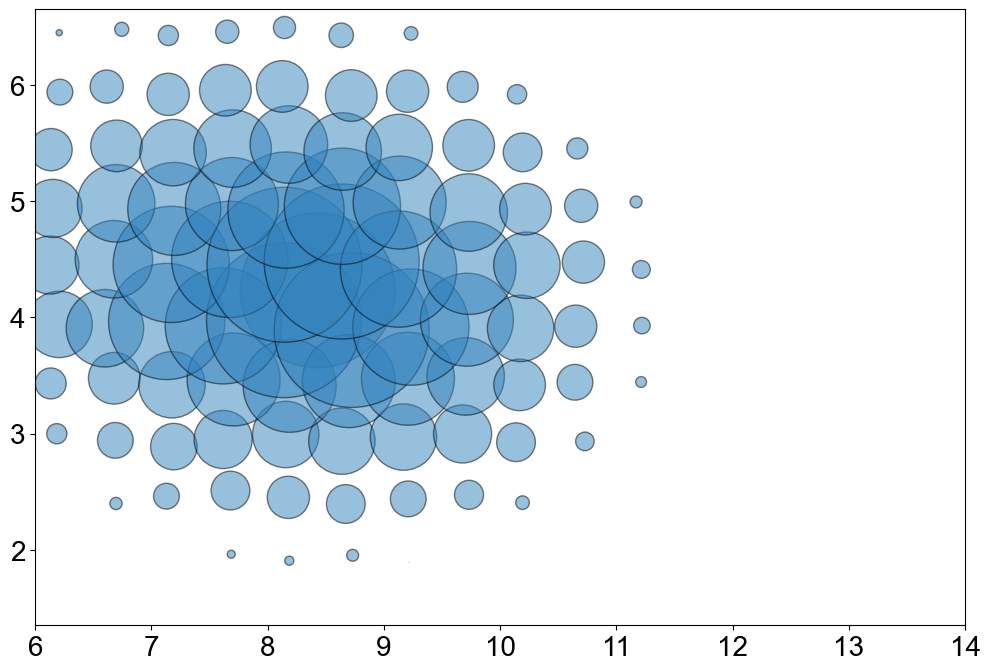

Reading in data for Realistic density
plotting 7.62012 2.64159 0.25 1.0
plotting 5.54576 1.85384 0.04 0.16
plotting 6.70757 1.87233 0.16666666666666666 0.6666666666666666
plotting 7.92439 1.85912 0.16666666666666666 0.6666666666666666
plotting 9.10684 1.93556 0.011235955056179775 0.0449438202247191
plotting 4.34839 3.12617 0.03125 0.125
plotting 5.49658 3.05579 0.1111111111111111 0.4444444444444444
plotting 6.72428 3.06161 0.25 1.0
plotting 7.89256 3.09245 0.25 1.0
plotting 9.11829 3.15286 0.045454545454545456 0.18181818181818182
plotting 4.34446 4.25557 0.008403361344537815 0.03361344537815126
plotting 5.51816 4.26853 0.045454545454545456 0.18181818181818182
plotting 6.735 4.26303 0.08333333333333333 0.3333333333333333
plotting 7.91051 4.25534 0.0625 0.25


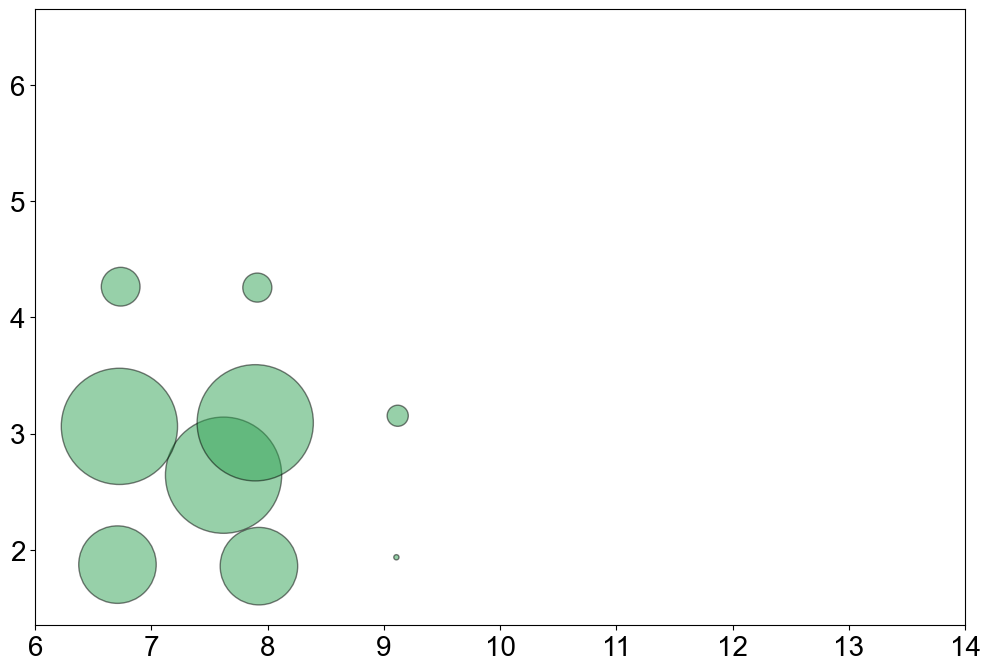

Reading in data for Realistic density
plotting 7.93266 4.6816 0.3333333333333333 1.0
plotting 5.46313 3.05285 0.041666666666666664 0.125
plotting 6.69179 3.05047 0.08333333333333333 0.25
plotting 7.8832 3.04361 0.1 0.30000000000000004
plotting 9.15326 3.05226 0.037037037037037035 0.1111111111111111
plotting 4.27617 4.27822 0.007246376811594203 0.02173913043478261
plotting 5.47734 4.25076 0.08333333333333333 0.25
plotting 6.69716 4.32242 0.2 0.6000000000000001
plotting 7.90142 4.30174 0.25 0.75
plotting 9.14965 4.29783 0.16666666666666666 0.5
plotting 10.2432 4.32136 0.027777777777777776 0.08333333333333333
plotting 5.44323 5.47563 0.047619047619047616 0.14285714285714285
plotting 6.73601 5.45902 0.16666666666666666 0.5
plotting 7.85474 5.43757 0.2 0.6000000000000001
plotting 9.1456 5.46209 0.125 0.375


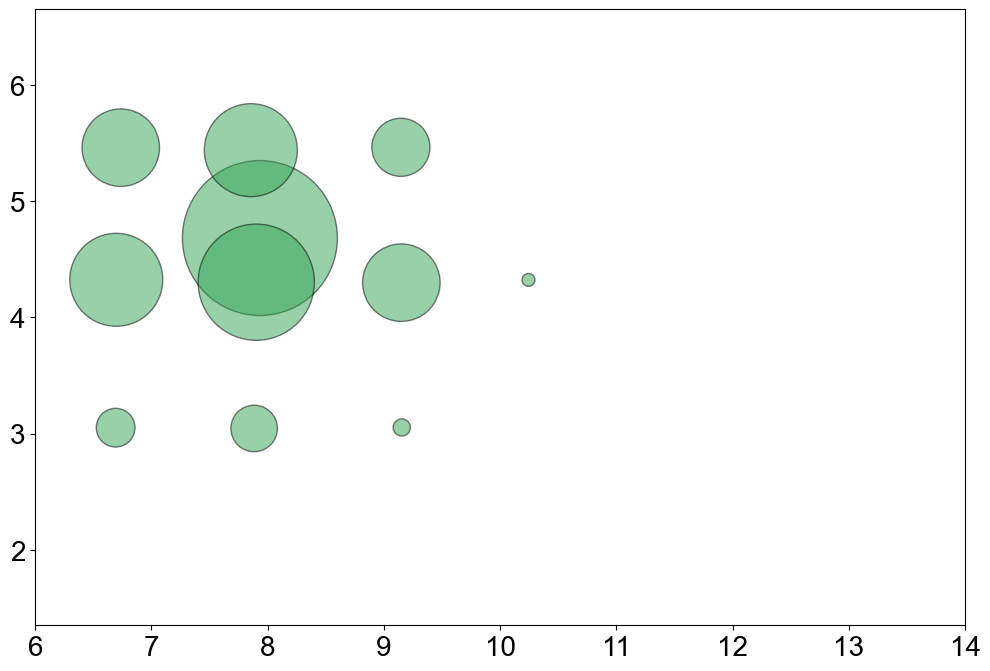

Reading in data for Realistic density
plotting 7.94645 6.44402 0.5 1.0
plotting 5.54433 4.26898 0.02702702702702703 0.05405405405405406
plotting 6.65734 4.28635 0.08333333333333333 0.16666666666666666
plotting 7.90474 4.33134 0.1111111111111111 0.2222222222222222
plotting 9.10326 4.27534 0.07692307692307693 0.15384615384615385
plotting 10.2641 4.31712 0.00023485204321277596 0.0004697040864255519
plotting 16.0614 4.28995 0.08333333333333333 0.16666666666666666
plotting 4.33866 5.48208 0.03225806451612903 0.06451612903225806
plotting 5.52779 5.4947 0.013333333333333334 0.02666666666666667
plotting 6.75577 5.52342 0.16666666666666666 0.3333333333333333
plotting 7.87945 5.52285 0.25 0.5
plotting 9.11383 5.47105 0.2 0.4
plotting 10.2967 5.51889 0.09090909090909091 0.18181818181818182
plotting 5.53841 6.73199 0.125 0.25
plotting 6.68041 6.63126 0.25 0.5
plotting 7.92933 6.73935 0.3333333333333333 0.6666666666666666
plotting 9.1007 6.71723 0.25 0.5
plotting 10.3333 6.69974 0.125 0.25
plotting

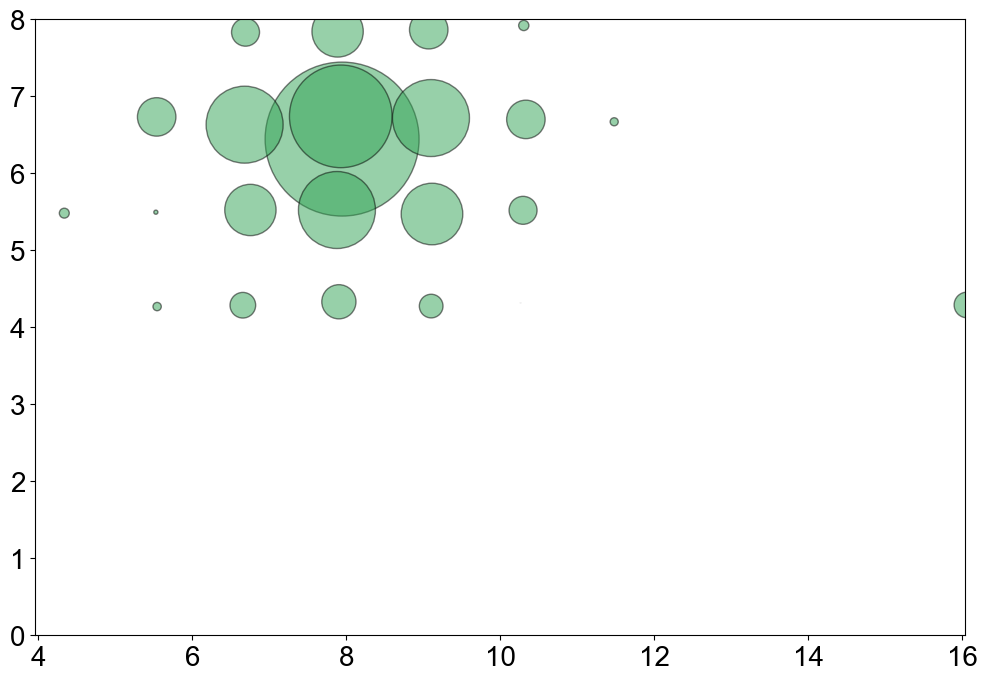

Reading in data for Realistic density
plotting 7.19751 3.10237 0.5 1.0
plotting 5.50999 1.9105 0.1 0.2
plotting 6.7703 1.87027 0.25 0.5
plotting 7.91493 1.8524 0.2 0.4
plotting 9.09411 1.91034 0.1 0.2
plotting 4.35023 3.13346 0.05555555555555555 0.1111111111111111
plotting 5.57332 3.04896 0.25 0.5
plotting 6.73715 3.05291 0.5 1.0
plotting 7.914 3.10962 0.3333333333333333 0.6666666666666666
plotting 9.09808 3.03907 0.14285714285714285 0.2857142857142857
plotting 4.3546 4.25727 0.07142857142857142 0.14285714285714285
plotting 5.45843 4.26206 0.16666666666666666 0.3333333333333333
plotting 6.69233 4.31759 0.2 0.4
plotting 7.88517 4.25574 0.2 0.4
plotting 9.16425 4.25964 0.058823529411764705 0.11764705882352941
plotting 6.74392 5.44946 0.016666666666666666 0.03333333333333333


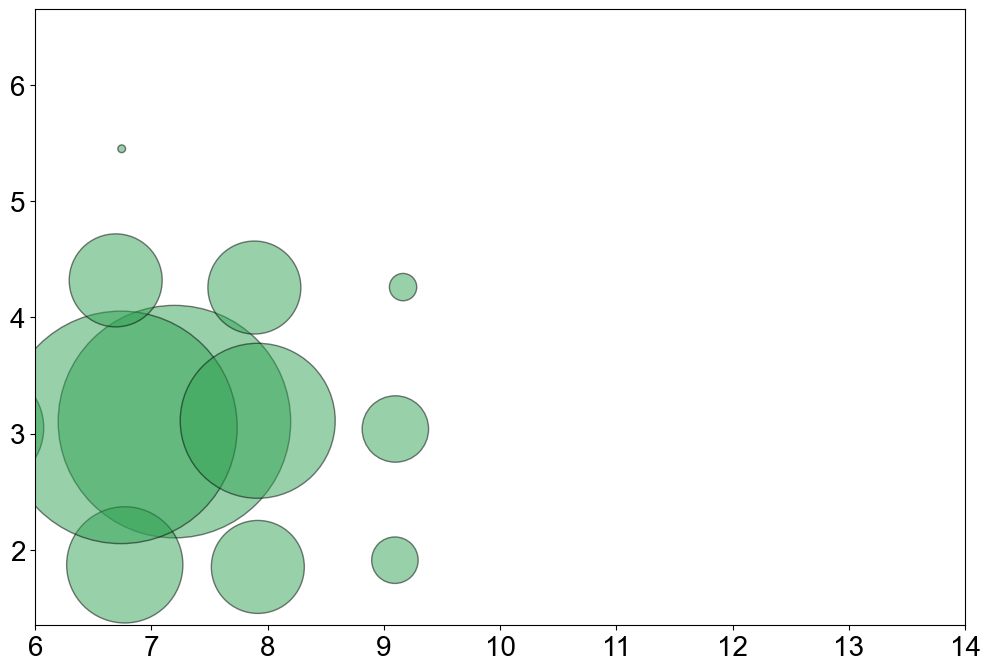

Reading in data for Realistic density
plotting 8.43014 4.23195 0.5 1.0
plotting 8.13339 1.80163 0.0002486943546381497 0.0004973887092762995
plotting 5.64628 3.04769 0.1 0.2
plotting 6.86357 3.02861 0.14285714285714285 0.2857142857142857
plotting 8.07345 3.10709 0.25 0.5
plotting 9.3233 3.05282 0.25 0.5
plotting 10.5362 3.06278 0.1 0.2
plotting 4.47432 4.31264 0.03125 0.0625
plotting 5.64708 4.29462 0.14285714285714285 0.2857142857142857
plotting 6.86392 4.28157 0.3333333333333333 0.6666666666666666
plotting 8.08744 4.26534 0.5 1.0
plotting 9.30704 4.193 0.3333333333333333 0.6666666666666666
plotting 10.4904 4.23928 0.16666666666666666 0.3333333333333333
plotting 4.50305 5.43712 0.010638297872340425 0.02127659574468085
plotting 5.69895 5.39752 0.1111111111111111 0.2222222222222222
plotting 6.82757 5.45924 0.2 0.4
plotting 8.04707 5.4082 0.25 0.5
plotting 9.24778 5.44658 0.25 0.5
plotting 10.438 5.48406 0.1 0.2
plotting 6.86035 6.66669 0.022222222222222223 0.044444444444444446
plotting 8

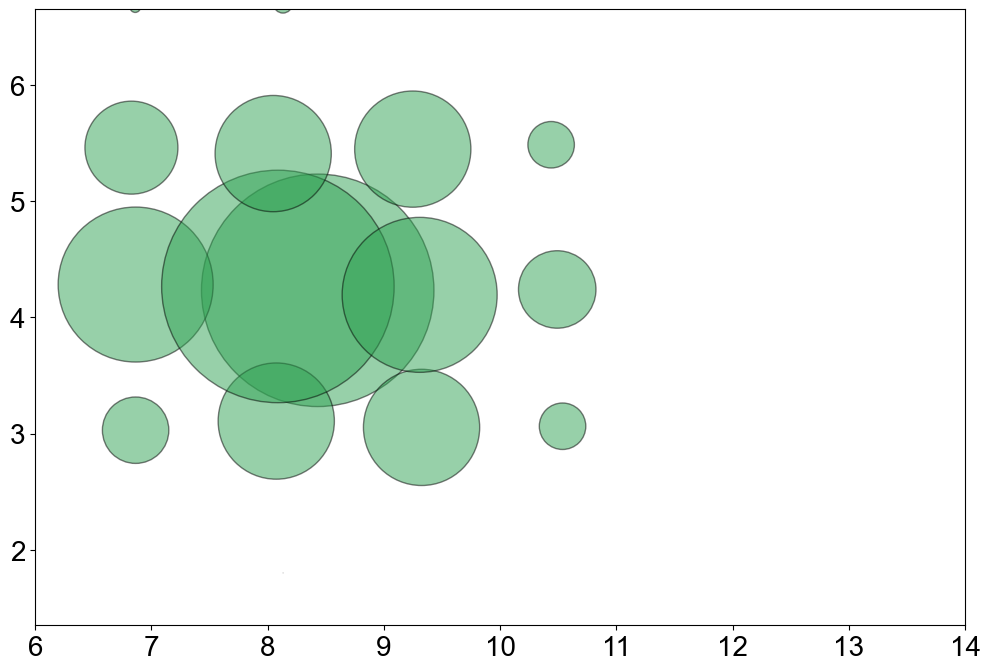

Reading in data for Realistic density
plotting 7.62012 2.64159 0.2 1.0
plotting 5.54576 1.85384 0.024390243902439025 0.12195121951219512
plotting 6.70757 1.87233 0.1111111111111111 0.5555555555555555
plotting 7.92439 1.85912 0.1 0.5
plotting 9.10684 1.93556 0.0 0
plotting 4.34839 3.12617 0.019230769230769232 0.09615384615384616
plotting 5.49658 3.05579 0.07142857142857142 0.3571428571428571
plotting 6.72428 3.06161 0.14285714285714285 0.7142857142857142
plotting 7.89256 3.09245 0.16666666666666666 0.8333333333333333
plotting 9.11829 3.15286 0.02857142857142857 0.14285714285714285
plotting 4.34446 4.25557 0.0 0
plotting 5.51816 4.26853 0.02857142857142857 0.14285714285714285
plotting 6.735 4.26303 0.05555555555555555 0.27777777777777773
plotting 7.91051 4.25534 0.038461538461538464 0.19230769230769232


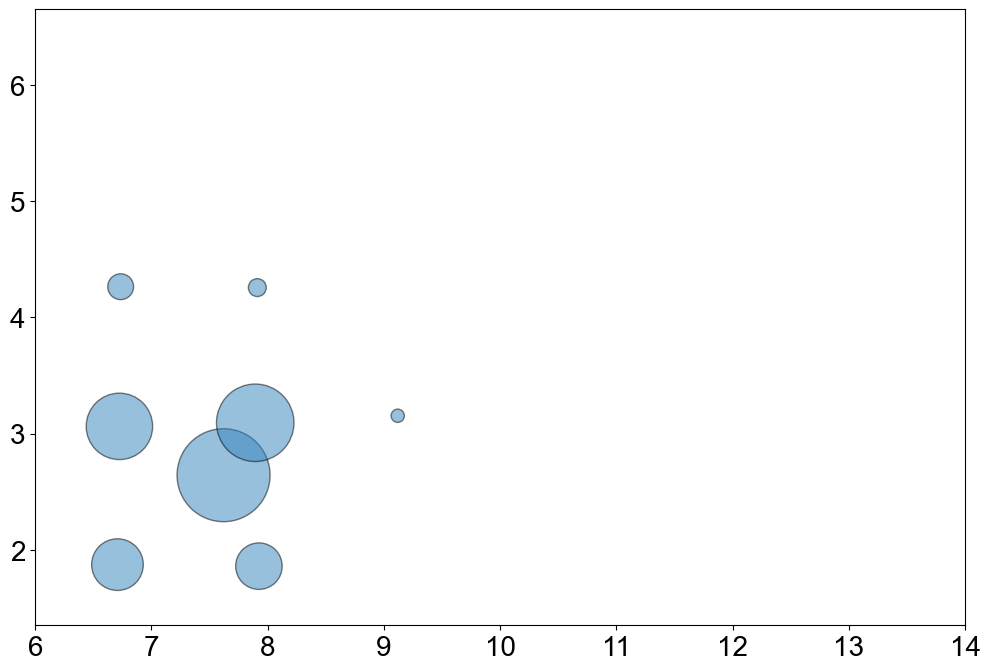

Reading in data for Realistic density
plotting 7.93266 4.6816 0.2 1.0
plotting 5.46313 3.05285 0.025 0.125
plotting 6.69179 3.05047 0.05263157894736842 0.2631578947368421
plotting 7.8832 3.04361 0.0625 0.3125
plotting 9.15326 3.05226 0.021739130434782608 0.10869565217391304
plotting 5.47734 4.25076 0.05263157894736842 0.2631578947368421
plotting 6.69716 4.32242 0.14285714285714285 0.7142857142857142
plotting 7.90142 4.30174 0.16666666666666666 0.8333333333333333
plotting 9.14965 4.29783 0.1111111111111111 0.5555555555555555
plotting 10.2432 4.32136 0.016129032258064516 0.08064516129032258
plotting 5.44323 5.47563 0.02857142857142857 0.14285714285714285
plotting 6.73601 5.45902 0.1 0.5
plotting 7.85474 5.43757 0.14285714285714285 0.7142857142857142
plotting 9.1456 5.46209 0.07692307692307693 0.38461538461538464


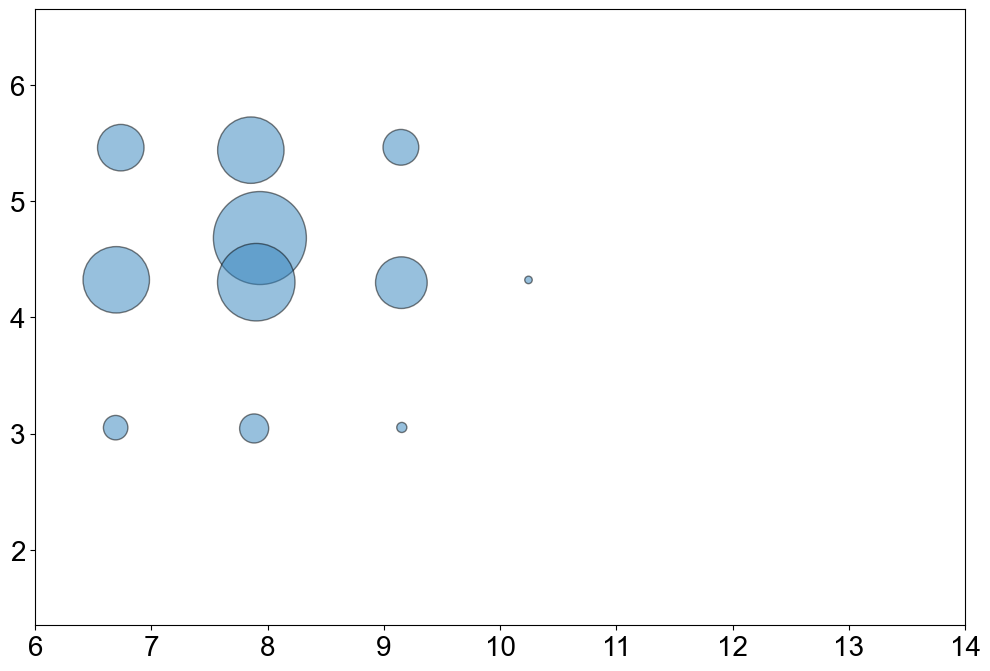

Reading in data for Realistic density
plotting 7.94645 6.44402 0.25 1.0
plotting 5.54433 4.26898 0.014492753623188406 0.057971014492753624
plotting 6.65734 4.28635 0.047619047619047616 0.19047619047619047
plotting 7.90474 4.33134 0.0625 0.25
plotting 9.10326 4.27534 0.043478260869565216 0.17391304347826086
plotting 16.0614 4.28995 0.05 0.2
plotting 4.33866 5.48208 0.017857142857142856 0.07142857142857142
plotting 5.52779 5.4947 0.006329113924050633 0.02531645569620253
plotting 6.75577 5.52342 0.1 0.4
plotting 7.87945 5.52285 0.16666666666666666 0.6666666666666666
plotting 9.11383 5.47105 0.125 0.5
plotting 10.2967 5.51889 0.05263157894736842 0.21052631578947367
plotting 5.53841 6.73199 0.07142857142857142 0.2857142857142857
plotting 6.68041 6.63126 0.14285714285714285 0.5714285714285714
plotting 7.92933 6.73935 0.25 1.0
plotting 9.1007 6.71723 0.16666666666666666 0.6666666666666666
plotting 10.3333 6.69974 0.07142857142857142 0.2857142857142857
plotting 11.4802 6.66896 0.01408450704225

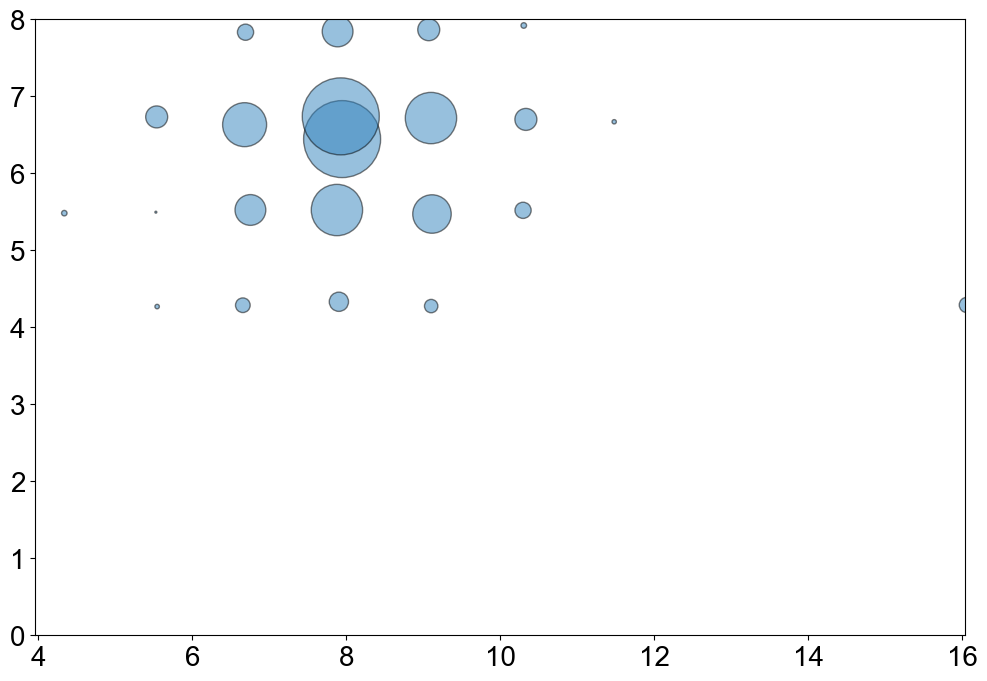

Reading in data for Realistic density
plotting 7.19751 3.10237 0.25 1.0
plotting 5.50999 1.9105 0.0625 0.25
plotting 6.7703 1.87027 0.14285714285714285 0.5714285714285714
plotting 7.91493 1.8524 0.14285714285714285 0.5714285714285714
plotting 9.09411 1.91034 0.06666666666666667 0.26666666666666666
plotting 4.35023 3.13346 0.03571428571428571 0.14285714285714285
plotting 5.57332 3.04896 0.2 0.8
plotting 6.73715 3.05291 0.25 1.0
plotting 7.914 3.10962 0.25 1.0
plotting 9.09808 3.03907 0.1 0.4
plotting 4.3546 4.25727 0.045454545454545456 0.18181818181818182
plotting 5.45843 4.26206 0.1111111111111111 0.4444444444444444
plotting 6.69233 4.31759 0.14285714285714285 0.5714285714285714
plotting 7.88517 4.25574 0.125 0.5
plotting 9.16425 4.25964 0.038461538461538464 0.15384615384615385
plotting 6.74392 5.44946 0.008928571428571428 0.03571428571428571


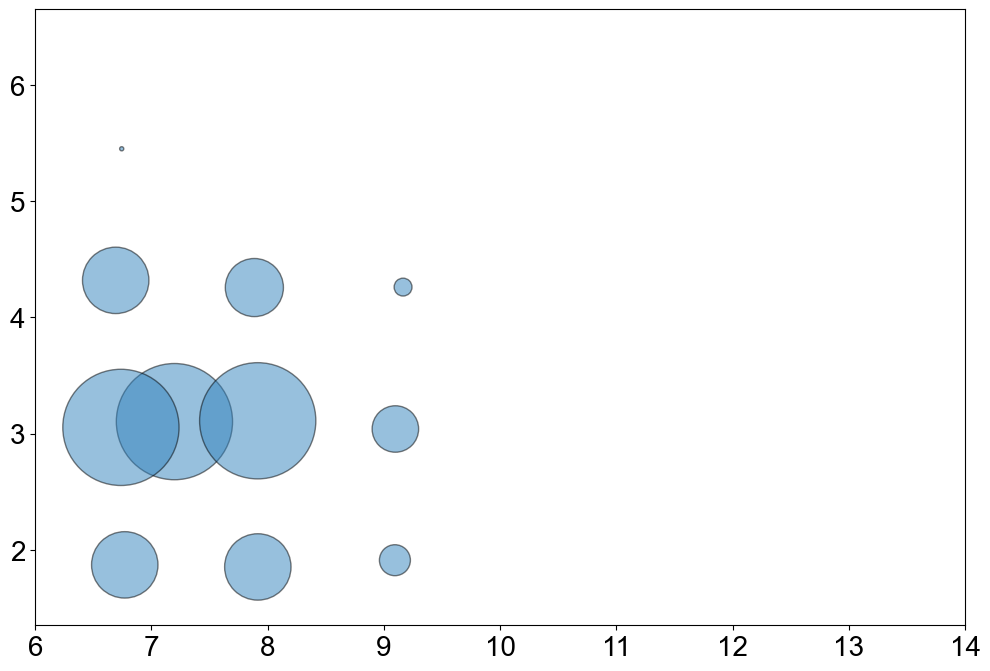

Reading in data for Realistic density
plotting 8.43014 4.23195 0.3333333333333333 1.0
plotting 5.64628 3.04769 0.0625 0.1875
plotting 6.86357 3.02861 0.09090909090909091 0.27272727272727276
plotting 8.07345 3.10709 0.16666666666666666 0.5
plotting 9.3233 3.05282 0.14285714285714285 0.42857142857142855
plotting 10.5362 3.06278 0.0625 0.1875
plotting 4.47432 4.31264 0.01818181818181818 0.05454545454545454
plotting 5.64708 4.29462 0.09090909090909091 0.27272727272727276
plotting 6.86392 4.28157 0.2 0.6000000000000001
plotting 8.08744 4.26534 0.3333333333333333 1.0
plotting 9.30704 4.193 0.25 0.75
plotting 10.4904 4.23928 0.1111111111111111 0.3333333333333333
plotting 4.50305 5.43712 0.00024937655860349125 0.0007481296758104738
plotting 5.69895 5.39752 0.06666666666666667 0.2
plotting 6.82757 5.45924 0.125 0.375
plotting 8.04707 5.4082 0.16666666666666666 0.5
plotting 9.24778 5.44658 0.14285714285714285 0.42857142857142855
plotting 10.438 5.48406 0.0625 0.1875
plotting 6.86035 6.66669 0.01

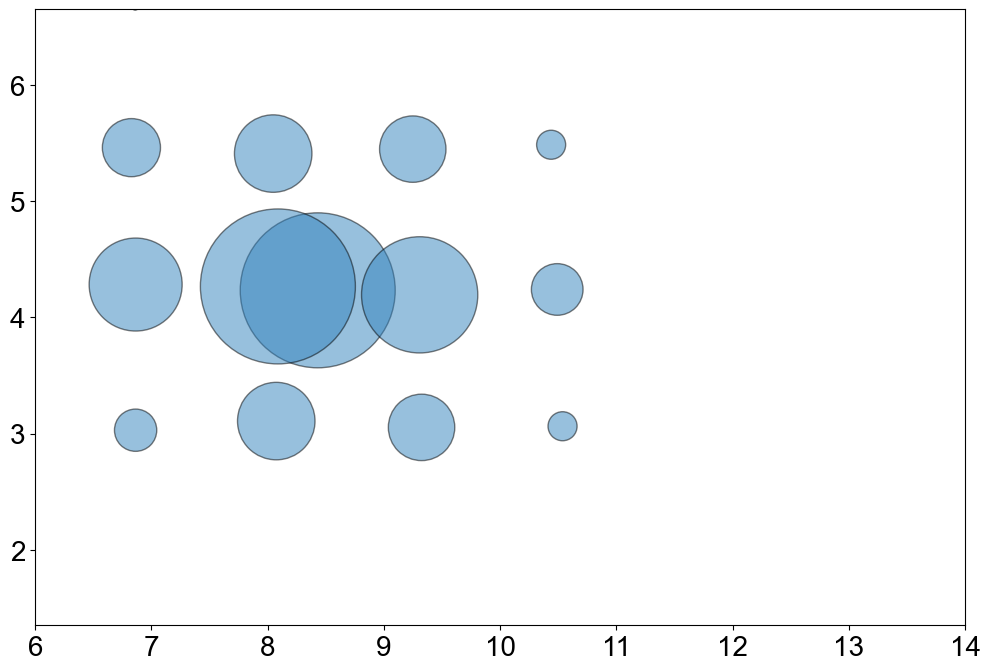

In [14]:
for d in ["low", "med", "high", "realistic"]:
    for aff_type in ["SA", "RA"]:
        for vf_tip in [3.61,4.08,4.17,4.31,4.56]:
            vf_model = VF_Population_Model(vf_tip_size= vf_tip,aff_type= aff_type, scaling_factor= 1.0, density=d)
            vf_model.radial_stress_vf_model()
            vf_model.run_single_unit_model_combined_graph(plot = False)
            vf_model.spatial_stress_vf_model()
            vf_model.plot_spatial_coords(label = False)


### Making the population Model over time plots

**Configuring the Von-Frey Population Model**

In [ ]:
iffs = vf_model.get_iffs()

for iff in iffs:
    print(iff)

**Randomly Generating Afferents and setting up the configuration for the Simulation**

In [ ]:
tongue_size = (10,18)  # in mm
density_ratio = (1, 0)  # Ratio of SA and RA afferents
n_afferents = 1500
rf_sizes = {
    'SA': [1],
    'RA': [1]
}

config = SimulationConfig(tongue_size, density_ratio, n_afferents, rf_sizes,
                          stimulus_diameter=None, 
                          x_stimulus=None, y_stimulus=None,
                          stress=None)

simulation = Simulation(config)

afferents = simulation.get_afferents()


**Getting Stress & Firing Data for the Afferents**